Rosenbrock synthetic function:

GP EI: (exact GP EI gradients) vs. GP ERM: (exact GP ERM gradients)

https://www.sfu.ca/~ssurjano/rosen.html

In [1]:
!pip install pyGPGO

  Created wheel for pyGPGO: filename=pyGPGO-0.4.0.dev1-cp37-none-any.whl size=19866 sha256=c4361ae17b2cc79a305ba9397d07bc350465bf9b351077802b1950b4499ca489
  Stored in directory: /root/.cache/pip/wheels/d1/27/04/c4fa3bfe194d36e3cd51542132f43415a6813114a5e8301acb
Successfully built pyGPGO


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
n_start_AcqFunc = 250 #multi-start iterations to avoid local optima in AcqFunc optimization

In [4]:
### Inputs:

obj_func = 'Rosenbrock'
n_test = n_start_AcqFunc # test points
df = 3 # nu

util_loser = 'dEI_GP'
util_winner = 'dERM_GP'
n_init = 5 # random initialisations

In [5]:
### Objective function:

if obj_func == 'Rosenbrock':
            
    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = -2.048 
    ub = +2.048 
    
# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}
    
    max_iter = 100  # iterations of Bayesian optimisation
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))
    
    def f_syn_polarity(x1_training, x2_training):
        return operator * (100 * (x2_training - x1_training ** 2) ** 2 + (x1_training - 1) ** 2)

In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list

In [7]:
### Set-seeds:

run_num_1 = 111
run_num_2 = 113
run_num_3 = 3333
run_num_4 = 444
run_num_5 = 5555
run_num_6 = 6
run_num_7 = 777
run_num_8 = 887
run_num_9 = 999
run_num_10 = 1000
run_num_11 = 1113
run_num_12 = 1234
run_num_13 = 2345
run_num_14 = 88
run_num_15 = 1556
run_num_16 = 1666
run_num_17 = 717
run_num_18 = 8
run_num_19 = 1998
run_num_20 = 2000

In [8]:
### Derivatives - Squared-exponential covariance function:

def l2norm_(X, Xstar):
    
    return cdist(X, Xstar)

def kronDelta(X, Xstar):

    return cdist(X, Xstar) < np.finfo(np.float32).eps

class squaredExponentialDeriv(squaredExponential):
    
    def K(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        K = self.sigmaf * np.exp(-1/2*r **2) + self.sigman * kronDelta(X, Xstar)
        return K
    
    def dK(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        dK = self.sigmaf/self.l**2 * np.exp(-1/2 * r **2) * l2norm_(X, Xstar)
        return dK
    
        
    def d2K(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        d2K = self.sigmaf/self.l**2 * np.exp(-1/2 * r **2) * (r**2-1)
        return d2K
    
cov_func = squaredExponential()
d_cov_func = squaredExponentialDeriv()

In [9]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-08, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP,
            'dERM_GP': self.dERM_GP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm, dvdv, d2v, d2m):
        z = -1 * (tau - mean - self.eps) / (std + self.eps)
        
        dsdx = ds / 2 * (std + self.eps)
        d2sdx = -dsdx**2 / ((std + self.eps)) - dvdv / (std + self.eps) - d2v / (std + self.eps)
        dmdx = (dm - z * dsdx) / (std + self.eps)
        d2mdx = (d2m - (z * d2sdx + 2 * dmdx * dsdx)) / (std + self.eps)
        
        f = (std + self.eps) * (z * norm.cdf(z) + norm.pdf(z)[0])
        df = (f / (std + self.eps) * dsdx + (std + self.eps) * norm.cdf(z) * dmdx)
        d2f = (f / (std + self.eps) * d2sdx + dsdx * dmdx * norm.cdf(z) \
            + d2mdx * (std + self.eps) * norm.cdf(z) + dsdx * norm.cdf(z) * dmdx \
            + norm.pdf(z)[0] * (std + self.eps) * dmdx)
            
        return f, df, d2f

    def dERM_GP(self, tau, mean, std, ds, dm, dvdv, d2v, d2m):
        z = -1 * (y_global_orig - mean - self.eps) / (std + self.eps)
        
        dsdx = ds / 2 * (std + self.eps)
        d2sdx = -dsdx**2 / ((std + self.eps)) - dvdv / (std + self.eps) - d2v / (std + self.eps)
        dmdx = (dm - z * dsdx) / (std + self.eps)
        d2mdx = (d2m - (z * d2sdx + 2 * dmdx * dsdx)) / (std + self.eps)
        
        f = (std + self.eps) * (z * norm.cdf(z) + norm.pdf(z)[0])
        df = (f / (std + self.eps) * dsdx + (std + self.eps) * norm.cdf(z) * dmdx)
        d2f = (f / (std + self.eps) * d2sdx + dsdx * dmdx * norm.cdf(z) \
            + d2mdx * (std + self.eps) * norm.cdf(z) + dsdx * norm.cdf(z) * dmdx \
            + norm.pdf(z)[0] * (std + self.eps) * dmdx)
            
        return f, df, d2f
    
    def _eval(self, tau, mean, std):
    
        return self.f(tau, mean, std, **self.params)
    
    def d_eval(self, tau, mean, std, ds, dm, dvdv, d2v, d2m):
    
        return self.f(tau, mean, std, ds, dm, dvdv, d2v, d2m, **self.params)

    def d_eval_stp(self, tau, mean, std, ds, dm, dvdv, d2v, d2m, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, dvdv, d2v, d2m, nu=3.0, **self.params)

In [10]:
### Surrogate derivatives: 

from scipy.linalg import cholesky, solve

class dGaussianProcess(GaussianProcess):
    l = 1
    sigmaf = 1
    sigman = 1e-6

    def AcqGrad(self, Xstar, return_std=False):
        r_X = l2norm_(self.X, self.X)/self.l
        K = self.sigmaf * np.exp(-1/2*r_X **2) + self.sigman * kronDelta(self.X, self.X)
        L = cholesky(K).T
        alpha = solve(L.T, solve(L, self.y))
        Xstar = np.atleast_2d(Xstar)
        Kstar = squaredExponentialDeriv.K(self, self.X, Xstar).T
        dKstar = squaredExponentialDeriv.dK(self, self.X, Xstar).T
        d2Kstar = squaredExponentialDeriv.d2K(self, self.X, Xstar).T
        v = solve(self.L, Kstar.T)
        dv = solve(self.L, dKstar.T)
        d2v = solve(self.L, d2Kstar.T)
        
        ds = -2 * np.dot(dv.T, v)
        dvdv = np.dot(dv.T, dv)
        d2s = -2 * (dvdv + d2v)
        
        dm = np.dot(dKstar, alpha)
        d2m = np.dot(d2Kstar, alpha)
        return ds, dm, dvdv, d2v, d2m

class dtStudentProcess(tStudentProcess):
    l = 1
    sigmaf = 1
    sigman = 1e-6
    
    def AcqGrad(self, Xstar, return_std=False):
        r_X = l2norm_(self.X, self.X)/self.l
        K = self.sigmaf * np.exp(-1/2*r_X **2) + self.sigman * kronDelta(self.X, self.X)
        L = cholesky(self.K11).T
        alpha = solve(L.T, solve(L, self.y))
        Xstar = np.atleast_2d(Xstar)
        Kstar = squaredExponentialDeriv.K(self, self.X, Xstar).T
        dKstar = squaredExponentialDeriv.dK(self, self.X, Xstar).T
        d2Kstar = squaredExponentialDeriv.d2K(self, self.X, Xstar).T
        v = solve(L, Kstar.T)
        dv = solve(L, dKstar.T)
        d2v = solve(L, d2Kstar.T)
        
        ds = -2 * np.dot(dv.T, v)
        dvdv = np.dot(dv.T, dv)
        d2s = -2 * (dvdv + d2v)
        
        dm = np.dot(dKstar, alpha)
        d2m = np.dot(d2Kstar, alpha)
        return ds, dm, dvdv, d2v, d2m

In [11]:
class dGPGO(GPGO):  
    n_start = n_start_AcqFunc
    eps = 1e-08
        
    def func(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
        f  = np.empty((self.n_start,))
        df = np.empty((self.n_start,))
        f  = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[0]
        df = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[1]
        df_array = np.full((len(xnew),),df)
        return f, df_array
        
    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.func,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

In [12]:
## dGPGO_stp - BayesOpt derivatives' class: Student's-t

class dGPGO_stp(GPGO):  
    n_start = 100
        
    def func_stp(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
        f  = np.empty((self.n_start,))
        df = np.empty((self.n_start,))
        f  = -self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m, nu=df)[0]
        df = -self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m, nu=df)[1]
        df_array = np.full((len(xnew),),df)
        return f, df_array
        
    def d_optimizeAcq_stp(self, method='L-BFGS-B', n_start=n_start):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.func_stp,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq_stp()
            self.updateGP()
            self.logger._printCurrent(self)

In [13]:
### d2GPGO - BayesOpt class: 

class d2GPGO(GPGO):  
    n_start = 100
    p = np.full((n_start,1),1)
    
    def func(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2s, d2m = self.GP.AcqGrad(xnew, return_std=True)
        f  = np.empty((self.n_start,))
        df = np.empty((self.n_start,))
        f  = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2s=d2s, d2m=d2m)[0]
        df = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2s=d2s, d2m=d2m)[1]
        df_array = np.full((len(xnew),),df)
        return f, df_array
    
    def hessp_nonzero(self, xnew, p):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2s, d2m = self.GP.AcqGrad(xnew, return_std=True)
        df2 = np.empty((self.n_start,))
        df2 = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2s=d2s, d2m=d2m)[2]
        H2 = np.empty((self.n_start,))
        df2 = np.asarray(df2)
        p = np.asarray(p)
        H2 = np.multiply(df2,p)
        return H2
    
    def d_optimizeAcq(self, method='Newton-CG', n_start=n_start):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.func,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 hessp = self.hessp_nonzero,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.best = x_best[np.argmin(f_best)]     
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

In [14]:
start_lose = time.time()
start_lose

1615129800.7592247

In [15]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_loser_1 = dGaussianProcess(d_cov_func)

loser_1 = dGPGO(surrogate_loser_1, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_1.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.45944904 -1.35549029]. 	  -245.71064611316496 	 -108.5713485785257
init   	 [-0.26190226  1.10289909]. 	  -108.5713485785257 	 -108.5713485785257
init   	 [-0.83834755 -1.43702853]. 	  -461.2775269355244 	 -108.5713485785257
init   	 [-1.95592878 -0.32676048]. 	  -1732.9949421003257 	 -108.5713485785257
init   	 [-1.07035795 -0.66496024]. 	  -332.12317010404104 	 -108.5713485785257
1      	 [-0.16418989 -0.35655496]. 	  -16.063581388629835 	 -16.063581388629835
2      	 [-0.46725478 -0.31805013]. 	  -30.922881903337014 	 -16.063581388629835
3      	 [0.36410567 1.99516816]. 	  -347.33045841529025 	 -16.063581388629835
4      	 [ 1.88433773 -0.57897707]. 	  -1706.2290269490966 	 -16.063581388629835
5      	 [-0.2797263  -0.65083633]. 	  -54.79392119360623 	 -16.063581388629835
6      	 [-0.36967736 -0.35543443]. 	  -26.09184200624848 	 -16.063581388629835
7      	 [ 0.02629338 -0.17265926]. 	  -3.953147754267091 	 -3

In [16]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_loser_2 = dGaussianProcess(d_cov_func)

loser_2 = dGPGO(surrogate_loser_2, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_2.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.44173258 -1.74529086]. 	  -1462.4037722675753 	 -1.3013277264983028
init   	 [ 1.6176405  -0.26012243]. 	  -828.0271838688934 	 -1.3013277264983028
init   	 [-1.525032    0.31071385]. 	  -412.40181251788414 	 -1.3013277264983028
init   	 [ 1.39456889 -0.26574622]. 	  -488.8170397507174 	 -1.3013277264983028
init   	 [0.80244966 0.75627765]. 	  -1.3013277264983028 	 -1.3013277264983028
1      	 [ 0.33906095 -0.26492231]. 	  -14.868074192108132 	 -1.3013277264983028
2      	 [ 0.63761197 -0.00466461]. 	  -17.040990776479866 	 -1.3013277264983028
3      	 [0.97082692 1.75663077]. 	  -66.28094057138775 	 -1.3013277264983028
4      	 [ 0.2824696  -0.71012934]. 	  -62.91195966330248 	 -1.3013277264983028
5      	 [0.83023894 1.20141882]. 	  -26.25572497486854 	 -1.3013277264983028
6      	 [1.1566147  1.12418388]. 	  -4.5859003313837405 	 -1.3013277264983028
7      	 [-0.74554464 -0.41245325]. 	  -96.80549233062297 	 -1.3

In [17]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_loser_3 = dGaussianProcess(d_cov_func)

loser_3 = dGPGO(surrogate_loser_3, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_3.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.03045369 -1.60050678]. 	  -708.8071948417274 	 -1.118465165857483
init   	 [-0.05684724 -0.0006915 ]. 	  -1.118465165857483 	 -1.118465165857483
init   	 [ 0.64352256 -1.08181622]. 	  -223.90997740226942 	 -1.118465165857483
init   	 [ 0.46200787 -1.55790376]. 	  -314.05929962166397 	 -1.118465165857483
init   	 [ 0.86918061 -0.52199202]. 	  -163.20929387450548 	 -1.118465165857483
1      	 [-0.47032198 -0.98469614]. 	  -147.5810642040628 	 -1.118465165857483
2      	 [ 0.19510124 -0.39571949]. 	  -19.464716969441064 	 -1.118465165857483
3      	 [-0.48374833  1.21060744]. 	  -97.57528626382148 	 -1.118465165857483
4      	 [-0.04142004  0.27493655]. 	  -8.549523360099188 	 -1.118465165857483
5      	 [-0.75508265  0.36868271]. 	  -7.139214187351264 	 -1.118465165857483
6      	 [-0.37659969  0.1941843 ]. 	  -2.169151970106639 	 -1.118465165857483
7      	 [-2.00120028  0.75454632]. 	  -1065.4237754889868 	 -1.11846

In [18]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_loser_4 = dGaussianProcess(d_cov_func)

loser_4 = dGPGO(surrogate_loser_4, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_4.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.39002285 1.31602418]. 	  -38.11488737154776 	 -12.122423820878506
init   	 [0.58248055 0.68494384]. 	  -12.122423820878506 	 -12.122423820878506
init   	 [-1.88768295 -1.7790059 ]. 	  -2862.4120613667637 	 -12.122423820878506
init   	 [-0.91545338 -0.75218738]. 	  -256.5560079635026 	 -12.122423820878506
init   	 [-1.25504548 -1.24070756]. 	  -797.98450090518 	 -12.122423820878506
1      	 [-0.07724009 -1.60241953]. 	  -259.85085705484 	 -12.122423820878506
2      	 [0.50582555 1.31540574]. 	  -112.5080347477725 	 -12.122423820878506
3      	 [1.38124473 0.39077049]. 	  -230.29442671843938 	 -12.122423820878506
4      	 [1.97887267 1.83898365]. 	  -432.3317389383738 	 -12.122423820878506
5      	 [0.84233915 0.9518293 ]. 	  -5.89549813715424 	 -5.89549813715424
6      	 [1.0556916  1.08009465]. 	  -0.12136948890890542 	 -0.12136948890890542
7      	 [-0.18308617 -1.34190572]. 	  -190.579434904392 	 -0.121369488908905

In [19]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_loser_5 = dGaussianProcess(d_cov_func)

loser_5 = dGPGO(surrogate_loser_5, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_5.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.23491901 0.17105153]. 	  -1.9278091788796494 	 -1.9278091788796494
init   	 [ 0.24749582 -0.48313101]. 	  -30.201785940713883 	 -1.9278091788796494
init   	 [-1.56019024  1.41721238]. 	  -109.97965348801837 	 -1.9278091788796494
init   	 [0.98198164 1.77093658]. 	  -65.06852657321838 	 -1.9278091788796494
init   	 [1.47180752 0.85239655]. 	  -172.83511538815276 	 -1.9278091788796494
1      	 [-0.22001069  0.22846888]. 	  -4.730736857945067 	 -1.9278091788796494
2      	 [-0.04631006  0.34471263]. 	  -12.830048576914852 	 -1.9278091788796494
3      	 [-1.24874396 -0.40718067]. 	  -391.7856478877513 	 -1.9278091788796494
4      	 [ 0.02295425 -0.00498953]. 	  -0.9576614962030955 	 -0.9576614962030955
5      	 [ 0.9852452  -0.41754642]. 	  -192.72527827698983 	 -0.9576614962030955
6      	 [ 0.17833193 -1.94470778]. 	  -391.33433945839664 	 -0.9576614962030955
7      	 [-1.02601459  0.70105493]. 	  -16.470578116788527 	

In [20]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_loser_6 = dGaussianProcess(d_cov_func)

loser_6 = dGPGO(surrogate_loser_6, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_6.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.60915518 -0.68821072]. 	  -1074.6314195925434 	 -3.0269049669752817
init   	 [ 1.31575449 -1.87721062]. 	  -1302.169546932896 	 -3.0269049669752817
init   	 [-1.60703824  0.38933325]. 	  -487.8262244570432 	 -3.0269049669752817
init   	 [ 0.12213192 -0.33256477]. 	  -12.844955340992902 	 -3.0269049669752817
init   	 [-0.67416945  0.50183959]. 	  -3.0269049669752817 	 -3.0269049669752817
1      	 [-0.06756934  0.5044222 ]. 	  -26.125364719936726 	 -3.0269049669752817
2      	 [-0.46927273 -0.51516379]. 	  -56.23723640401884 	 -3.0269049669752817
3      	 [-0.27427447  0.04468444]. 	  -1.7170570344409537 	 -1.7170570344409537
4      	 [-0.7005749   1.50074021]. 	  -104.88882839307404 	 -1.7170570344409537
5      	 [-0.46613674  0.64777826]. 	  -20.68213437104052 	 -1.7170570344409537
6      	 [1.16259188 1.02707415]. 	  -10.559428954318465 	 -1.7170570344409537
7      	 [0.26282348 0.02154315]. 	  -0.7693680794170482 

In [21]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_loser_7 = dGaussianProcess(d_cov_func)

loser_7 = dGPGO(surrogate_loser_7, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_7.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.42268934 -0.80954733]. 	  -808.7939502616841 	 -2.0077595729598063
init   	 [-1.79389885 -0.16441204]. 	  -1151.9264213711547 	 -2.0077595729598063
init   	 [1.37319786 1.74897991]. 	  -2.0077595729598063 	 -2.0077595729598063
init   	 [0.92974688 1.09976052]. 	  -5.543015908052858 	 -2.0077595729598063
init   	 [-0.94533605  0.58994398]. 	  -13.008689168416776 	 -2.0077595729598063
1      	 [-0.37625117  1.06266898]. 	  -86.73733152643135 	 -2.0077595729598063
2      	 [ 0.03555281 -0.06681774]. 	  -1.3936707114630122 	 -1.3936707114630122
3      	 [1.70981563 0.62552629]. 	  -528.5581328002694 	 -1.3936707114630122
4      	 [1.00342219 1.66585077]. 	  -43.427410777261855 	 -1.3936707114630122
5      	 [-0.28030133  0.4011523 ]. 	  -12.045180746113228 	 -1.3936707114630122
6      	 [-1.54963585  1.50677465]. 	  -86.5309531618843 	 -1.3936707114630122
7      	 [ 0.11233166 -1.46148808]. 	  -218.0869481450979 	 -1.39

In [22]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_loser_8 = dGaussianProcess(d_cov_func)

loser_8 = dGPGO(surrogate_loser_8, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_8.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.59948851 -1.8750873 ]. 	  -1972.3059423071145 	 -7.238275380208551
init   	 [ 0.40834083 -0.81972959]. 	  -97.66272647293047 	 -7.238275380208551
init   	 [ 1.21492186 -0.54806067]. 	  -409.7425700197761 	 -7.238275380208551
init   	 [ 1.55897178 -0.82804067]. 	  -1062.051446884513 	 -7.238275380208551
init   	 [-0.69999303  0.28146449]. 	  -7.238275380208551 	 -7.238275380208551
1      	 [0.61360238 0.32771785]. 	  -0.38734981524274686 	 -0.38734981524274686
2      	 [ 0.44957683 -0.14950718]. 	  -12.667085696146009 	 -0.38734981524274686
3      	 [-1.39188014  0.88003045]. 	  -117.50939285923893 	 -0.38734981524274686
4      	 [1.41566408 0.84930114]. 	  -133.52992403681057 	 -0.38734981524274686
5      	 [-0.6916621   0.64393699]. 	  -5.60208758511781 	 -0.38734981524274686
6      	 [0.75922499 0.1685607 ]. 	  -16.69310442272994 	 -0.38734981524274686
7      	 [0.35625505 1.43304671]. 	  -171.0117160875193 	 -0.3

In [23]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_loser_9 = dGaussianProcess(d_cov_func)

loser_9 = dGPGO(surrogate_loser_9, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_9.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.24284125 0.11273132]. 	  -205.0993354093405 	 -3.486729021084656
init   	 [-1.56011944  0.5721352 ]. 	  -353.19808767458017 	 -3.486729021084656
init   	 [-1.67557012 -0.68720361]. 	  -1228.4786390381805 	 -3.486729021084656
init   	 [-0.29744764  0.22276429]. 	  -3.486729021084656 	 -3.486729021084656
init   	 [0.52480624 0.8085215 ]. 	  -28.645360944397154 	 -3.486729021084656
1      	 [-0.42084996  1.1040236 ]. 	  -87.93482613667966 	 -3.486729021084656
2      	 [0.09130205 0.2771249 ]. 	  -8.050476078634611 	 -3.486729021084656
3      	 [1.34027586 1.76760892]. 	  -0.19833152756144756 	 -0.19833152756144756
4      	 [-0.18756391  0.42579889]. 	  -16.66860272011216 	 -0.19833152756144756
5      	 [0.88246179 1.50452626]. 	  -52.69055737972176 	 -0.19833152756144756
6      	 [2.048 2.048]. 	  -461.7603900415999 	 -0.19833152756144756
7      	 [1.27982732 1.09230691]. 	  -29.851811719281347 	 -0.19833152756144756
8 

In [24]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_loser_10 = dGaussianProcess(d_cov_func)

loser_10 = dGPGO(surrogate_loser_10, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_10.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.62910294 -1.57693156]. 	  -389.29291138113445 	 -8.580376531587937
init   	 [ 1.84435861 -0.07294402]. 	  -1207.999341247548 	 -8.580376531587937
init   	 [ 1.5256557  -1.17828534]. 	  -1229.4172568797705 	 -8.580376531587937
init   	 [-1.88125338 -0.42109149]. 	  -1576.6245828972787 	 -8.580376531587937
init   	 [-1.09309052  1.39977001]. 	  -8.580376531587937 	 -8.580376531587937
1      	 [-0.86019812  2.03750805]. 	  -171.82841453589126 	 -8.580376531587937
2      	 [-0.09725394 -1.98440571]. 	  -398.75334498229967 	 -8.580376531587937
3      	 [-0.71787532  1.26192598]. 	  -58.689416526596894 	 -8.580376531587937
4      	 [-1.66940512  1.65929749]. 	  -134.27750112819044 	 -8.580376531587937
5      	 [-0.21590304  1.35197276]. 	  -171.8745365573776 	 -8.580376531587937
6      	 [ 0.55073144 -1.79055537]. 	  -438.6270149029219 	 -8.580376531587937
7      	 [0.98226372 1.2697215 ]. 	  -9.295464012565606 	 -8.58037

In [25]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_loser_11 = dGaussianProcess(d_cov_func)

loser_11 = dGPGO(surrogate_loser_11, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_11.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.97032207 1.31583119]. 	  -659.5505379977991 	 -45.00854175284071
init   	 [ 0.59758024 -0.3125739 ]. 	  -45.00854175284071 	 -45.00854175284071
init   	 [-1.21933423 -0.03314987]. 	  -235.94289844157058 	 -45.00854175284071
init   	 [-1.48046507 -0.19447384]. 	  -575.5719351651762 	 -45.00854175284071
init   	 [-1.58214297 -2.0360213 ]. 	  -2067.0989998073865 	 -45.00854175284071
1      	 [-0.59782787  0.66030788]. 	  -11.728483422473923 	 -11.728483422473923
2      	 [-0.44273339  0.04021619]. 	  -4.508739622784907 	 -4.508739622784907
3      	 [-1.11955987  0.65043597]. 	  -40.85082114690448 	 -4.508739622784907
4      	 [ 1.30792565 -1.05782521]. 	  -766.5511117868322 	 -4.508739622784907
5      	 [0.38613963 0.10451944]. 	  -0.5756012078214707 	 -0.5756012078214707
6      	 [-0.80037406  0.38397636]. 	  -9.826845764091287 	 -0.5756012078214707
7      	 [-0.36159767  1.94598938]. 	  -331.36230478725497 	 -0.575601

In [26]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_loser_12 = dGaussianProcess(d_cov_func)

loser_12 = dGPGO(surrogate_loser_12, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_12.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.26353633  0.50015753]. 	  -125.32555445527122 	 -19.52113145175031
init   	 [-0.25506718  1.16882876]. 	  -123.40590278793995 	 -19.52113145175031
init   	 [ 1.14678091 -0.93146069]. 	  -504.72793807789463 	 -19.52113145175031
init   	 [-0.91560241  1.23646844]. 	  -19.52113145175031 	 -19.52113145175031
init   	 [1.87653879 1.53982007]. 	  -393.43336554061835 	 -19.52113145175031
1      	 [-1.50623477  1.94347507]. 	  -16.861146488467053 	 -16.861146488467053
2      	 [-1.17298972  1.69858754]. 	  -15.134293586652838 	 -15.134293586652838
3      	 [-1.88219337  1.81269391]. 	  -307.58250276319126 	 -15.134293586652838
4      	 [-0.74187204  1.95815573]. 	  -201.21902316932247 	 -15.134293586652838
5      	 [-0.46123599  0.48505636]. 	  -9.550904750813473 	 -9.550904750813473
6      	 [-0.71357184  0.79843935]. 	  -11.303149762215897 	 -9.550904750813473
7      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -9.55090475

In [27]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_loser_13 = dGaussianProcess(d_cov_func)

loser_13 = dGPGO(surrogate_loser_13, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_13.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.65799909 -0.35389173]. 	  -62.0309701572776 	 -62.0309701572776
init   	 [ 0.68854808 -1.10615174]. 	  -249.81607110978882 	 -62.0309701572776
init   	 [1.26025046 0.56040843]. 	  -105.7097019264073 	 -62.0309701572776
init   	 [-1.34269398 -0.98145948]. 	  -780.713409392333 	 -62.0309701572776
init   	 [ 1.70115068 -0.15230767]. 	  -928.4380405275942 	 -62.0309701572776
1      	 [0.41169197 0.76902621]. 	  -36.290440627725864 	 -36.290440627725864
2      	 [1.56732557 1.62159952]. 	  -70.02931566657841 	 -36.290440627725864
3      	 [0.44708238 0.08707663]. 	  -1.578237817391173 	 -1.578237817391173
4      	 [0.92702252 0.86460314]. 	  -0.008063513247388177 	 -0.008063513247388177
5      	 [-0.90131356  1.97423118]. 	  -138.6080292653433 	 -0.008063513247388177
6      	 [0.67987852 0.5941335 ]. 	  -1.8422045489389927 	 -0.008063513247388177
7      	 [ 0.85956863 -0.72063444]. 	  -213.0316067957737 	 -0.008063513247

In [28]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_loser_14 = dGaussianProcess(d_cov_func)

loser_14 = dGPGO(surrogate_loser_14, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_14.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.6043691  0.02928512]. 	  -11.444570460525577 	 -4.306489127802793
init   	 [0.11608629 1.6231842 ]. 	  -259.89734211112767 	 -4.306489127802793
init   	 [0.81916392 0.87776093]. 	  -4.306489127802793 	 -4.306489127802793
init   	 [ 0.89021801 -1.13533148]. 	  -371.66089065122344 	 -4.306489127802793
init   	 [-1.33056707 -0.17677726]. 	  -384.58487399689074 	 -4.306489127802793
1      	 [1.20014634 0.52224222]. 	  -84.33247643037394 	 -4.306489127802793
2      	 [0.3990925  0.43403903]. 	  -7.910626836147134 	 -4.306489127802793
3      	 [0.51527608 0.27463977]. 	  -0.2432935527026396 	 -0.2432935527026396
4      	 [1.53137544 1.8120952 ]. 	  -28.692917519939073 	 -0.2432935527026396
5      	 [1.11969363 1.26054942]. 	  -0.018999105716718055 	 -0.018999105716718055
6      	 [1.02729802 1.2165308 ]. 	  -2.5989529034397827 	 -0.018999105716718055
7      	 [1.44865337 1.35082366]. 	  -56.1177263844637 	 -0.0189991057167

In [29]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_loser_15 = dGaussianProcess(d_cov_func)

loser_15 = dGPGO(surrogate_loser_15, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_15.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.31900409 -1.00146655]. 	  -122.17543449532224 	 -6.867717811955245
init   	 [-1.01364994  0.85976824]. 	  -6.867717811955245 	 -6.867717811955245
init   	 [-0.21482552 -1.11844164]. 	  -137.1031718367486 	 -6.867717811955245
init   	 [-0.40259762  1.56572768]. 	  -198.98860193376754 	 -6.867717811955245
init   	 [-0.25717364  1.55002954]. 	  -221.77381285664336 	 -6.867717811955245
1      	 [-1.8012058   0.68545903]. 	  -662.6351334070664 	 -6.867717811955245
2      	 [-0.43724669  0.32410651]. 	  -3.8324996046651183 	 -3.8324996046651183
3      	 [-0.74037338  0.72496404]. 	  -6.155122682350399 	 -3.8324996046651183
4      	 [1.25594009 1.69598967]. 	  -1.4722002702680579 	 -1.4722002702680579
5      	 [0.99642726 0.16862642]. 	  -67.93731254820314 	 -1.4722002702680579
6      	 [-0.32748232 -0.09152068]. 	  -5.712975739964262 	 -1.4722002702680579
7      	 [-1.23315299  1.42836845]. 	  -5.838861619488394 	 -1.4722

In [30]:

### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_loser_16 = dGaussianProcess(d_cov_func)

loser_16 = dGPGO(surrogate_loser_16, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_16.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.49073237 -0.75216486]. 	  -884.9748202573794 	 -21.690996320546372
init   	 [0.70512959 0.03240619]. 	  -21.690996320546372 	 -21.690996320546372
init   	 [ 1.15368111 -0.88603985]. 	  -491.54136063574043 	 -21.690996320546372
init   	 [-1.09072882  0.26132352]. 	  -90.5574614167091 	 -21.690996320546372
init   	 [1.5360998 0.8967902]. 	  -214.26941031258198 	 -21.690996320546372
1      	 [ 0.0221755  -1.04001206]. 	  -109.2209581414894 	 -21.690996320546372
2      	 [0.22984789 0.62935581]. 	  -33.831328641897436 	 -21.690996320546372
3      	 [0.27847476 0.05249583]. 	  -0.5833607298068536 	 -0.5833607298068536
4      	 [-1.89666678  0.44479792]. 	  -1002.2459176523861 	 -0.5833607298068536
5      	 [-0.64908274  0.24042698]. 	  -5.9912828906732205 	 -0.5833607298068536
6      	 [-0.90568542 -0.13633405]. 	  -95.14001721251631 	 -0.5833607298068536
7      	 [-0.70879595  0.54496077]. 	  -3.10119619289842 	 -0.5833

In [31]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_loser_17 = dGaussianProcess(d_cov_func)

loser_17 = dGPGO(surrogate_loser_17, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_17.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.62187122 0.94420838]. 	  -31.22188590191926 	 -31.22188590191926
init   	 [-1.25596728  0.08059797]. 	  -229.14713198618372 	 -31.22188590191926
init   	 [0.72246586 1.2470062 ]. 	  -52.64667111223406 	 -31.22188590191926
init   	 [0.13726869 1.671308  ]. 	  -273.80846401311214 	 -31.22188590191926
init   	 [-0.2315013  -0.99953783]. 	  -112.42501801714917 	 -31.22188590191926
1      	 [1.59286487 0.71471414]. 	  -332.50370461464615 	 -31.22188590191926
2      	 [ 1.90278748 -2.02756811]. 	  -3190.995555019365 	 -31.22188590191926
3      	 [-1.34540721 -1.87107521]. 	  -1360.6211641082973 	 -31.22188590191926
4      	 [-0.05612606 -0.17716441]. 	  -4.366735792685078 	 -4.366735792685078
5      	 [-0.14818959 -0.3550115 ]. 	  -15.52910245168684 	 -4.366735792685078
6      	 [ 0.06392531 -0.23881863]. 	  -6.776523181613979 	 -4.366735792685078
7      	 [0.07863961 0.06826898]. 	  -1.2343570551701712 	 -1.23435705517017

In [32]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_loser_18 = dGaussianProcess(d_cov_func)

loser_18 = dGPGO(surrogate_loser_18, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_18.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.52956683 1.91914255]. 	  -17.95675982372887 	 -1.7663579664225912
init   	 [1.51222084 0.12638491]. 	  -467.0068292530542 	 -1.7663579664225912
init   	 [-1.09474477 -2.0013105 ]. 	  -1028.244988519411 	 -1.7663579664225912
init   	 [-0.28479972 -0.39996883]. 	  -24.79447905426233 	 -1.7663579664225912
init   	 [ 0.09287545 -0.0885072 ]. 	  -1.7663579664225912 	 -1.7663579664225912
1      	 [-0.56813572  0.40153442]. 	  -3.0793038960278705 	 -1.7663579664225912
2      	 [-0.15462805 -0.07652601]. 	  -2.341901869752791 	 -1.7663579664225912
3      	 [-1.20242026  1.32756507]. 	  -6.248947237067588 	 -1.7663579664225912
4      	 [ 0.34076202 -0.76279921]. 	  -77.68427478499966 	 -1.7663579664225912
5      	 [-1.68770408  0.39178462]. 	  -610.6926759353652 	 -1.7663579664225912
6      	 [-0.03540629  1.33846942]. 	  -179.88668010529636 	 -1.7663579664225912
7      	 [-0.8823456   1.11145957]. 	  -14.627184329389557 	 -1

In [33]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_loser_19 = dGaussianProcess(d_cov_func)

loser_19 = dGPGO(surrogate_loser_19, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_19.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.24348908 1.07107119]. 	  -102.94304782477323 	 -4.219752052396591
init   	 [-1.04639875  1.11284007]. 	  -4.219752052396591 	 -4.219752052396591
init   	 [-0.59608235  1.21527255]. 	  -76.50031976976825 	 -4.219752052396591
init   	 [-0.63078391 -0.22989031]. 	  -42.07005958957044 	 -4.219752052396591
init   	 [-0.8056685  -0.23710138]. 	  -81.79603430667063 	 -4.219752052396591
1      	 [ 0.45286922 -0.60514617]. 	  -65.94770306515855 	 -4.219752052396591
2      	 [-1.9115265   1.53808142]. 	  -456.16001072637476 	 -4.219752052396591
3      	 [-0.76878948  0.5483007 ]. 	  -3.311257684438914 	 -3.311257684438914
4      	 [1.50989435 1.30714346]. 	  -94.86236329029082 	 -3.311257684438914
5      	 [-0.06855973 -0.20779091]. 	  -5.6570771189820555 	 -3.311257684438914
6      	 [-0.21718482 -1.25152481]. 	  -170.14216241918132 	 -3.311257684438914
7      	 [-1.12098267  0.71437221]. 	  -33.89989778483975 	 -3.3112576844

In [34]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_loser_20 = dGaussianProcess(d_cov_func)

loser_20 = dGPGO(surrogate_loser_20, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_20.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.2888388  0.26430978]. 	  -3.777577453542735 	 -3.777577453542735
init   	 [-0.04734225 -0.66978712]. 	  -46.25914429040042 	 -3.777577453542735
init   	 [-0.50844394  0.13121892]. 	  -3.895838569726608 	 -3.777577453542735
init   	 [-1.76903664  0.34623103]. 	  -782.3209705533411 	 -3.777577453542735
init   	 [-1.07357076 -1.38954104]. 	  -650.524506936468 	 -3.777577453542735
1      	 [-0.12445779  0.09875914]. 	  -1.9577846182863219 	 -1.9577846182863219
2      	 [1.53218166 0.73906821]. 	  -259.01444417510237 	 -1.9577846182863219
3      	 [ 0.92617356 -1.26728579]. 	  -451.6033360820788 	 -1.9577846182863219
4      	 [0.04098166 1.4092975 ]. 	  -199.05856175553572 	 -1.9577846182863219
5      	 [-0.35605494  0.10030413]. 	  -1.908956308825034 	 -1.908956308825034
6      	 [ 0.44408175 -0.04477678]. 	  -6.1647374965964925 	 -1.908956308825034
7      	 [-0.50597028  0.52152132]. 	  -9.31778908557592 	 -1.9089563088

In [35]:
end_lose = time.time()
end_lose

time_lose = end_lose - start_lose
time_lose

start_win = time.time()
start_win

1615133255.903231

In [36]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_winner_1 = dGaussianProcess(d_cov_func)

winner_1 = dGPGO(surrogate_winner_1, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_1.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.45944904 -1.35549029]. 	  -245.71064611316496 	 -108.5713485785257
init   	 [-0.26190226  1.10289909]. 	  -108.5713485785257 	 -108.5713485785257
init   	 [-0.83834755 -1.43702853]. 	  -461.2775269355244 	 -108.5713485785257
init   	 [-1.95592878 -0.32676048]. 	  -1732.9949421003257 	 -108.5713485785257
init   	 [-1.07035795 -0.66496024]. 	  -332.12317010404104 	 -108.5713485785257
1      	 [-0.27863117 -0.25378189]. 	  -12.618635198822698 	 -12.618635198822698
2      	 [ 2.01512356 -1.72012678]. 	  -3342.8528372665846 	 -12.618635198822698
3      	 [-0.18076915 -0.89040318]. 	  -86.60200720604004 	 -12.618635198822698
4      	 [-0.47497278 -0.25393809]. 	  -25.171139860134154 	 -12.618635198822698
5      	 [1.6733781  1.94437529]. 	  -73.69604806058263 	 -12.618635198822698
6      	 [0.19585914 1.35285458]. 	  -173.43603037699663 	 -12.618635198822698
7      	 [-0.82321339  1.2832978 ]. 	  -40.00136365302549 	 -12.

In [37]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_winner_2 = dGaussianProcess(d_cov_func)

winner_2 = dGPGO(surrogate_winner_2, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_2.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.44173258 -1.74529086]. 	  -1462.4037722675753 	 -1.3013277264983028
init   	 [ 1.6176405  -0.26012243]. 	  -828.0271838688934 	 -1.3013277264983028
init   	 [-1.525032    0.31071385]. 	  -412.40181251788414 	 -1.3013277264983028
init   	 [ 1.39456889 -0.26574622]. 	  -488.8170397507174 	 -1.3013277264983028
init   	 [0.80244966 0.75627765]. 	  -1.3013277264983028 	 -1.3013277264983028
1      	 [ 0.33902339 -0.26495037]. 	  -14.868320436819797 	 -1.3013277264983028
2      	 [ 0.63723347 -0.00495259]. 	  -17.025268728735657 	 -1.3013277264983028
3      	 [0.97082692 1.75663077]. 	  -66.28094057138775 	 -1.3013277264983028
4      	 [ 0.2824696  -0.71012934]. 	  -62.91195966330248 	 -1.3013277264983028
5      	 [0.83001916 1.2011707 ]. 	  -26.267760827047802 	 -1.3013277264983028
6      	 [1.15913032 1.12667404]. 	  -4.730276512247014 	 -1.3013277264983028
7      	 [-0.74569877 -0.4126468 ]. 	  -96.88804112091125 	 -1.3

In [40]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_winner_3 = dGaussianProcess(d_cov_func)

winner_3 = dGPGO(surrogate_winner_3, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_3.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.03045369 -1.60050678]. 	  -708.8071948417274 	 -1.118465165857483
init   	 [-0.05684724 -0.0006915 ]. 	  -1.118465165857483 	 -1.118465165857483
init   	 [ 0.64352256 -1.08181622]. 	  -223.90997740226942 	 -1.118465165857483
init   	 [ 0.46200787 -1.55790376]. 	  -314.05929962166397 	 -1.118465165857483
init   	 [ 0.86918061 -0.52199202]. 	  -163.20929387450548 	 -1.118465165857483
1      	 [-0.56212963 -1.0124551 ]. 	  -178.9168151053094 	 -1.118465165857483
2      	 [ 0.19510124 -0.39571949]. 	  -19.464716969441064 	 -1.118465165857483
3      	 [-0.49748272  1.20436342]. 	  -93.80331056602205 	 -1.118465165857483
4      	 [-0.03748552  0.27949138]. 	  -8.809570650521628 	 -1.118465165857483
5      	 [-0.7505487   0.37715744]. 	  -6.530195027947112 	 -1.118465165857483
6      	 [-0.37659969  0.1941843 ]. 	  -2.169151970106639 	 -1.118465165857483
7      	 [-2.00247703  0.74814527]. 	  -1072.928562346176 	 -1.118465

In [41]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_winner_4 = dGaussianProcess(d_cov_func)

winner_4 = dGPGO(surrogate_winner_4, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_4.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.39002285 1.31602418]. 	  -38.11488737154776 	 -12.122423820878506
init   	 [0.58248055 0.68494384]. 	  -12.122423820878506 	 -12.122423820878506
init   	 [-1.88768295 -1.7790059 ]. 	  -2862.4120613667637 	 -12.122423820878506
init   	 [-0.91545338 -0.75218738]. 	  -256.5560079635026 	 -12.122423820878506
init   	 [-1.25504548 -1.24070756]. 	  -797.98450090518 	 -12.122423820878506
1      	 [-0.07700328 -1.60236599]. 	  -259.8213749889663 	 -12.122423820878506
2      	 [0.59737347 1.19847784]. 	  -70.9949983342334 	 -12.122423820878506
3      	 [1.37794346 0.38842274]. 	  -228.24509739867707 	 -12.122423820878506
4      	 [1.97887267 1.83898365]. 	  -432.3317389383738 	 -12.122423820878506
5      	 [1.08363028 0.84122816]. 	  -11.097654127987353 	 -11.097654127987353
6      	 [0.97677209 1.00055463]. 	  -0.21649406009956415 	 -0.21649406009956415
7      	 [1.14263635 1.00850813]. 	  -8.847762431690139 	 -0.21649406009

In [42]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_winner_5 = dGaussianProcess(d_cov_func)

winner_5 = dGPGO(surrogate_winner_5, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_5.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.23491901 0.17105153]. 	  -1.9278091788796494 	 -1.9278091788796494
init   	 [ 0.24749582 -0.48313101]. 	  -30.201785940713883 	 -1.9278091788796494
init   	 [-1.56019024  1.41721238]. 	  -109.97965348801837 	 -1.9278091788796494
init   	 [0.98198164 1.77093658]. 	  -65.06852657321838 	 -1.9278091788796494
init   	 [1.47180752 0.85239655]. 	  -172.83511538815276 	 -1.9278091788796494
1      	 [-0.22001069  0.22846888]. 	  -4.730736857945067 	 -1.9278091788796494
2      	 [-0.0497627   0.34058552]. 	  -12.533784555540677 	 -1.9278091788796494
3      	 [-1.48105507 -0.4847623 ]. 	  -723.4774422442588 	 -1.9278091788796494
4      	 [0.03340674 0.00532193]. 	  -0.936071503532055 	 -0.936071503532055
5      	 [ 1.14140857 -0.510327  ]. 	  -328.76784953323136 	 -0.936071503532055
6      	 [-0.90124818  0.69681294]. 	  -4.947276273380818 	 -0.936071503532055
7      	 [ 0.18401997 -1.76174727]. 	  -323.0875723555078 	 -0.9360

In [43]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_winner_6 = dGaussianProcess(d_cov_func)

winner_6 = dGPGO(surrogate_winner_6, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_6.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.60915518 -0.68821072]. 	  -1074.6314195925434 	 -3.0269049669752817
init   	 [ 1.31575449 -1.87721062]. 	  -1302.169546932896 	 -3.0269049669752817
init   	 [-1.60703824  0.38933325]. 	  -487.8262244570432 	 -3.0269049669752817
init   	 [ 0.12213192 -0.33256477]. 	  -12.844955340992902 	 -3.0269049669752817
init   	 [-0.67416945  0.50183959]. 	  -3.0269049669752817 	 -3.0269049669752817
1      	 [-0.06756934  0.5044222 ]. 	  -26.125364719936726 	 -3.0269049669752817
2      	 [-0.46957794 -0.51546013]. 	  -56.3238972552609 	 -3.0269049669752817
3      	 [-0.27427447  0.04468444]. 	  -1.7170570344409537 	 -1.7170570344409537
4      	 [-0.70979472  1.4764578 ]. 	  -97.52805611837617 	 -1.7170570344409537
5      	 [-0.46620343  0.64766462]. 	  -20.6671949456617 	 -1.7170570344409537
6      	 [1.14170796 1.00707173]. 	  -8.806878951259257 	 -1.7170570344409537
7      	 [0.26282348 0.02154315]. 	  -0.7693680794170482 	 -0

In [44]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_winner_7 = dGaussianProcess(d_cov_func)

winner_7 = dGPGO(surrogate_winner_7, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_7.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.42268934 -0.80954733]. 	  -808.7939502616841 	 -2.0077595729598063
init   	 [-1.79389885 -0.16441204]. 	  -1151.9264213711547 	 -2.0077595729598063
init   	 [1.37319786 1.74897991]. 	  -2.0077595729598063 	 -2.0077595729598063
init   	 [0.92974688 1.09976052]. 	  -5.543015908052858 	 -2.0077595729598063
init   	 [-0.94533605  0.58994398]. 	  -13.008689168416776 	 -2.0077595729598063
1      	 [-0.37627455  1.06262548]. 	  -86.7261431628382 	 -2.0077595729598063
2      	 [ 0.03487276 -0.06746438]. 	  -1.4031714851152948 	 -1.4031714851152948
3      	 [1.7096368  0.62539905]. 	  -528.3353333844661 	 -1.4031714851152948
4      	 [1.00339051 1.66581221]. 	  -43.43070787489704 	 -1.4031714851152948
5      	 [-0.28032686  0.40111693]. 	  -12.042040934665737 	 -1.4031714851152948
6      	 [-1.54656294  1.52869334]. 	  -80.9901226712704 	 -1.4031714851152948
7      	 [ 0.1042354  -1.46368615]. 	  -218.2325091875684 	 -1.4031

In [45]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_winner_8 = dGaussianProcess(d_cov_func)

winner_8 = dGPGO(surrogate_winner_8, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_8.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.59948851 -1.8750873 ]. 	  -1972.3059423071145 	 -7.238275380208551
init   	 [ 0.40834083 -0.81972959]. 	  -97.66272647293047 	 -7.238275380208551
init   	 [ 1.21492186 -0.54806067]. 	  -409.7425700197761 	 -7.238275380208551
init   	 [ 1.55897178 -0.82804067]. 	  -1062.051446884513 	 -7.238275380208551
init   	 [-0.69999303  0.28146449]. 	  -7.238275380208551 	 -7.238275380208551
1      	 [0.61358515 0.32770247]. 	  -0.38730686645997536 	 -0.38730686645997536
2      	 [ 0.44929913 -0.14971827]. 	  -12.664682151883305 	 -0.38730686645997536
3      	 [-1.39201605  0.8797452 ]. 	  -117.65041497657442 	 -0.38730686645997536
4      	 [1.41566408 0.84930114]. 	  -133.52992403681057 	 -0.38730686645997536
5      	 [-0.69235604  0.64255972]. 	  -5.527585581303217 	 -0.38730686645997536
6      	 [0.75907281 0.16844054]. 	  -16.68413317414213 	 -0.38730686645997536
7      	 [0.35649834 1.43339895]. 	  -171.05812419025793 	 -0

In [46]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_winner_9 = dGaussianProcess(d_cov_func)

winner_9 = dGPGO(surrogate_winner_9, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_9.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.24284125 0.11273132]. 	  -205.0993354093405 	 -3.486729021084656
init   	 [-1.56011944  0.5721352 ]. 	  -353.19808767458017 	 -3.486729021084656
init   	 [-1.67557012 -0.68720361]. 	  -1228.4786390381805 	 -3.486729021084656
init   	 [-0.29744764  0.22276429]. 	  -3.486729021084656 	 -3.486729021084656
init   	 [0.52480624 0.8085215 ]. 	  -28.645360944397154 	 -3.486729021084656
1      	 [-0.42042294  1.10485081]. 	  -88.1537008084973 	 -3.486729021084656
2      	 [0.09141118 0.27724351]. 	  -8.055583032200332 	 -3.486729021084656
3      	 [1.34027586 1.76760892]. 	  -0.19833152756144756 	 -0.19833152756144756
4      	 [-0.18773603  0.42557002]. 	  -16.646093525515155 	 -0.19833152756144756
5      	 [0.88242309 1.50447934]. 	  -52.69367137402105 	 -0.19833152756144756
6      	 [2.048 2.048]. 	  -461.7603900415999 	 -0.19833152756144756
7      	 [1.27982732 1.09230691]. 	  -29.851811719281347 	 -0.19833152756144756
8 

In [47]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_winner_10 = dGaussianProcess(d_cov_func)

winner_10 = dGPGO(surrogate_winner_10, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_10.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.62910294 -1.57693156]. 	  -389.29291138113445 	 -8.580376531587937
init   	 [ 1.84435861 -0.07294402]. 	  -1207.999341247548 	 -8.580376531587937
init   	 [ 1.5256557  -1.17828534]. 	  -1229.4172568797705 	 -8.580376531587937
init   	 [-1.88125338 -0.42109149]. 	  -1576.6245828972787 	 -8.580376531587937
init   	 [-1.09309052  1.39977001]. 	  -8.580376531587937 	 -8.580376531587937
1      	 [-0.86019812  2.03750805]. 	  -171.82841453589126 	 -8.580376531587937
2      	 [-0.02273896 -1.98197652]. 	  -394.07407427702145 	 -8.580376531587937
3      	 [-0.69769706  1.31213822]. 	  -71.00359845335805 	 -8.580376531587937
4      	 [-1.66873493  1.66586017]. 	  -132.29708986028288 	 -8.580376531587937
5      	 [-0.21590304  1.35197276]. 	  -171.8745365573776 	 -8.580376531587937
6      	 [ 0.55073144 -1.79055537]. 	  -438.6270149029219 	 -8.580376531587937
7      	 [0.98226372 1.2697215 ]. 	  -9.295464012565606 	 -8.580376

In [48]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_winner_11 = dGaussianProcess(d_cov_func)

winner_11 = dGPGO(surrogate_winner_11, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_11.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.97032207 1.31583119]. 	  -659.5505379977991 	 -45.00854175284071
init   	 [ 0.59758024 -0.3125739 ]. 	  -45.00854175284071 	 -45.00854175284071
init   	 [-1.21933423 -0.03314987]. 	  -235.94289844157058 	 -45.00854175284071
init   	 [-1.48046507 -0.19447384]. 	  -575.5719351651762 	 -45.00854175284071
init   	 [-1.58214297 -2.0360213 ]. 	  -2067.0989998073865 	 -45.00854175284071
1      	 [-0.59782787  0.66030788]. 	  -11.728483422473923 	 -11.728483422473923
2      	 [-0.43844995  0.04578832]. 	  -4.213899636921916 	 -4.213899636921916
3      	 [-1.13505201  0.60692079]. 	  -50.992078170283 	 -4.213899636921916
4      	 [ 1.30792565 -1.05782521]. 	  -766.5511117868322 	 -4.213899636921916
5      	 [0.48464231 0.19162575]. 	  -0.4526706910196805 	 -0.4526706910196805
6      	 [-0.8004777   0.38377433]. 	  -9.846117180705239 	 -0.4526706910196805
7      	 [-0.36159767  1.94598938]. 	  -331.36230478725497 	 -0.45267069

In [49]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_winner_12 = dGaussianProcess(d_cov_func)

winner_12 = dGPGO(surrogate_winner_12, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_12.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.26353633  0.50015753]. 	  -125.32555445527122 	 -19.52113145175031
init   	 [-0.25506718  1.16882876]. 	  -123.40590278793995 	 -19.52113145175031
init   	 [ 1.14678091 -0.93146069]. 	  -504.72793807789463 	 -19.52113145175031
init   	 [-0.91560241  1.23646844]. 	  -19.52113145175031 	 -19.52113145175031
init   	 [1.87653879 1.53982007]. 	  -393.43336554061835 	 -19.52113145175031
1      	 [-1.50623477  1.94347507]. 	  -16.861146488467053 	 -16.861146488467053
2      	 [-1.20192208  1.57470601]. 	  -6.540783929609845 	 -6.540783929609845
3      	 [-1.91012218 -2.00311393]. 	  -3202.61823928594 	 -6.540783929609845
4      	 [-1.77962776  1.29233421]. 	  -359.1916226402331 	 -6.540783929609845
5      	 [-0.66466132  2.03080142]. 	  -255.2716958040872 	 -6.540783929609845
6      	 [-0.47063642  0.25132545]. 	  -2.2517353516123206 	 -2.2517353516123206
7      	 [-0.65475451  0.65572418]. 	  -7.892052597058424 	 -2.25173

In [50]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_winner_13 = dGaussianProcess(d_cov_func)

winner_13 = dGPGO(surrogate_winner_13, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_13.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.65799909 -0.35389173]. 	  -62.0309701572776 	 -62.0309701572776
init   	 [ 0.68854808 -1.10615174]. 	  -249.81607110978882 	 -62.0309701572776
init   	 [1.26025046 0.56040843]. 	  -105.7097019264073 	 -62.0309701572776
init   	 [-1.34269398 -0.98145948]. 	  -780.713409392333 	 -62.0309701572776
init   	 [ 1.70115068 -0.15230767]. 	  -928.4380405275942 	 -62.0309701572776
1      	 [0.39666085 0.75181144]. 	  -35.703667546077746 	 -35.703667546077746
2      	 [1.55724713 1.61136978]. 	  -66.51296774721507 	 -35.703667546077746
3      	 [0.45795266 0.09637848]. 	  -1.5784598330083528 	 -1.5784598330083528
4      	 [0.96213087 0.89897489]. 	  -0.07283487658287202 	 -0.07283487658287202
5      	 [-1.05613246  1.97955428]. 	  -78.90121630773777 	 -0.07283487658287202
6      	 [0.68770831 0.60171718]. 	  -1.7558123270072936 	 -0.07283487658287202
7      	 [ 0.85956863 -0.72063444]. 	  -213.0316067957737 	 -0.07283487658287

In [51]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_winner_14 = dGaussianProcess(d_cov_func)

winner_14 = dGPGO(surrogate_winner_14, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_14.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.6043691  0.02928512]. 	  -11.444570460525577 	 -4.306489127802793
init   	 [0.11608629 1.6231842 ]. 	  -259.89734211112767 	 -4.306489127802793
init   	 [0.81916392 0.87776093]. 	  -4.306489127802793 	 -4.306489127802793
init   	 [ 0.89021801 -1.13533148]. 	  -371.66089065122344 	 -4.306489127802793
init   	 [-1.33056707 -0.17677726]. 	  -384.58487399689074 	 -4.306489127802793
1      	 [1.22616673 0.4906171 ]. 	  -102.64126056482887 	 -4.306489127802793
2      	 [0.39768831 0.43261479]. 	  -7.8955425297502035 	 -4.306489127802793
3      	 [1.48251177 1.88453283]. 	  -10.049028113352751 	 -4.306489127802793
4      	 [0.44231651 0.37003955]. 	  -3.3523954353876624 	 -3.3523954353876624
5      	 [1.11969363 1.26054942]. 	  -0.018999105716874715 	 -0.018999105716874715
6      	 [1.02729802 1.2165308 ]. 	  -2.5989529034397827 	 -0.018999105716874715
7      	 [1.47751334 1.37887618]. 	  -64.89687718089974 	 -0.01899910571

In [52]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_winner_15 = dGaussianProcess(d_cov_func)

winner_15 = dGPGO(surrogate_winner_15, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_15.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.31900409 -1.00146655]. 	  -122.17543449532224 	 -6.867717811955245
init   	 [-1.01364994  0.85976824]. 	  -6.867717811955245 	 -6.867717811955245
init   	 [-0.21482552 -1.11844164]. 	  -137.1031718367486 	 -6.867717811955245
init   	 [-0.40259762  1.56572768]. 	  -198.98860193376754 	 -6.867717811955245
init   	 [-0.25717364  1.55002954]. 	  -221.77381285664336 	 -6.867717811955245
1      	 [-1.80428823  0.65131853]. 	  -686.0172298947007 	 -6.867717811955245
2      	 [-0.39431841  0.38732566]. 	  -7.319039630086051 	 -6.867717811955245
3      	 [-0.74233496  0.72080431]. 	  -5.917003643344755 	 -5.917003643344755
4      	 [1.39526915 1.04631859]. 	  -81.23859217725087 	 -5.917003643344755
5      	 [-1.0740283   1.19307772]. 	  -4.4579419412449655 	 -4.4579419412449655
6      	 [ 0.12931444 -0.16944971]. 	  -4.22409241735088 	 -4.22409241735088
7      	 [-0.31654783 -0.16856539]. 	  -8.956917574982707 	 -4.224092417

In [53]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_winner_16 = dGaussianProcess(d_cov_func)

winner_16 = dGPGO(surrogate_winner_16, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_16.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.49073237 -0.75216486]. 	  -884.9748202573794 	 -21.690996320546372
init   	 [0.70512959 0.03240619]. 	  -21.690996320546372 	 -21.690996320546372
init   	 [ 1.15368111 -0.88603985]. 	  -491.54136063574043 	 -21.690996320546372
init   	 [-1.09072882  0.26132352]. 	  -90.5574614167091 	 -21.690996320546372
init   	 [1.5360998 0.8967902]. 	  -214.26941031258198 	 -21.690996320546372
1      	 [ 0.0206574  -1.04141013]. 	  -109.5015164534733 	 -21.690996320546372
2      	 [0.22660787 0.62554752]. 	  -33.568285031310054 	 -21.690996320546372
3      	 [0.27886845 0.05285128]. 	  -0.5821130603088832 	 -0.5821130603088832
4      	 [-1.89666678  0.44479792]. 	  -1002.2459176523861 	 -0.5821130603088832
5      	 [-0.64960232  0.23957703]. 	  -6.048388281834793 	 -0.5821130603088832
6      	 [-0.90627997 -0.13732903]. 	  -95.53918160157806 	 -0.5821130603088832
7      	 [-0.70879595  0.54496077]. 	  -3.10119619289842 	 -0.58211

In [54]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_winner_17 = dGaussianProcess(d_cov_func)

winner_17 = dGPGO(surrogate_winner_17, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_17.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.62187122 0.94420838]. 	  -31.22188590191926 	 -31.22188590191926
init   	 [-1.25596728  0.08059797]. 	  -229.14713198618372 	 -31.22188590191926
init   	 [0.72246586 1.2470062 ]. 	  -52.64667111223406 	 -31.22188590191926
init   	 [0.13726869 1.671308  ]. 	  -273.80846401311214 	 -31.22188590191926
init   	 [-0.2315013  -0.99953783]. 	  -112.42501801714917 	 -31.22188590191926
1      	 [1.59286487 0.71471414]. 	  -332.5037046146484 	 -31.22188590191926
2      	 [ 1.90278748 -2.02756811]. 	  -3190.995555019365 	 -31.22188590191926
3      	 [-1.33871017 -1.86938878]. 	  -1346.1524660840382 	 -31.22188590191926
4      	 [-0.05951272 -0.18034528]. 	  -4.504011857609685 	 -4.504011857609685
5      	 [-0.14818959 -0.3550115 ]. 	  -15.52910245168684 	 -4.504011857609685
6      	 [ 0.06733315 -0.25229126]. 	  -7.465776236662366 	 -4.504011857609685
7      	 [0.19958071 0.18862031]. 	  -2.8544533831880186 	 -2.854453383188018

In [55]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_winner_18 = dGaussianProcess(d_cov_func)

winner_18 = dGPGO(surrogate_winner_18, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_18.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.52956683 1.91914255]. 	  -17.95675982372887 	 -1.7663579664225912
init   	 [1.51222084 0.12638491]. 	  -467.0068292530542 	 -1.7663579664225912
init   	 [-1.09474477 -2.0013105 ]. 	  -1028.244988519411 	 -1.7663579664225912
init   	 [-0.28479972 -0.39996883]. 	  -24.79447905426233 	 -1.7663579664225912
init   	 [ 0.09287545 -0.0885072 ]. 	  -1.7663579664225912 	 -1.7663579664225912
1      	 [-0.56407431  0.40221499]. 	  -3.152519236956738 	 -1.7663579664225912
2      	 [-0.15472488 -0.07662684]. 	  -2.3447541166733443 	 -1.7663579664225912
3      	 [-1.25150403  1.2743779 ]. 	  -13.588923486938203 	 -1.7663579664225912
4      	 [ 0.3397827  -0.76332611]. 	  -77.66103325486918 	 -1.7663579664225912
5      	 [-0.02047237  1.53024584]. 	  -235.07834459947998 	 -1.7663579664225912
6      	 [-1.56737154  0.39039077]. 	  -433.53558235091447 	 -1.7663579664225912
7      	 [-0.8823456   1.11145957]. 	  -14.627184329389557 	 

In [56]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_winner_19 = dGaussianProcess(d_cov_func)

winner_19 = dGPGO(surrogate_winner_19, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_19.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.24348908 1.07107119]. 	  -102.94304782477323 	 -4.219752052396591
init   	 [-1.04639875  1.11284007]. 	  -4.219752052396591 	 -4.219752052396591
init   	 [-0.59608235  1.21527255]. 	  -76.50031976976825 	 -4.219752052396591
init   	 [-0.63078391 -0.22989031]. 	  -42.07005958957044 	 -4.219752052396591
init   	 [-0.8056685  -0.23710138]. 	  -81.79603430667063 	 -4.219752052396591
1      	 [ 0.44968884 -0.60729629]. 	  -65.83451268210109 	 -4.219752052396591
2      	 [-1.91146227  1.53976904]. 	  -455.3419578559051 	 -4.219752052396591
3      	 [-0.77078409  0.54425243]. 	  -3.3842351790654344 	 -3.3842351790654344
4      	 [1.5102531  1.30748176]. 	  -95.00774018067713 	 -3.3842351790654344
5      	 [-0.05010178 -0.19063127]. 	  -4.833075892256382 	 -3.3842351790654344
6      	 [-0.21883797 -0.94405562]. 	  -99.88118807940927 	 -3.3842351790654344
7      	 [-1.12134615  0.71328909]. 	  -34.10764757777547 	 -3.38423517

In [57]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_winner_20 = dGaussianProcess(d_cov_func)

winner_20 = dGPGO(surrogate_winner_20, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_20.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.2888388  0.26430978]. 	  -3.777577453542735 	 -3.777577453542735
init   	 [-0.04734225 -0.66978712]. 	  -46.25914429040042 	 -3.777577453542735
init   	 [-0.50844394  0.13121892]. 	  -3.895838569726608 	 -3.777577453542735
init   	 [-1.76903664  0.34623103]. 	  -782.3209705533411 	 -3.777577453542735
init   	 [-1.07357076 -1.38954104]. 	  -650.524506936468 	 -3.777577453542735
1      	 [-0.11974724  0.10401632]. 	  -2.0580289031443395 	 -2.0580289031443395
2      	 [1.57560185 0.62167074]. 	  -346.6077544697629 	 -2.0580289031443395
3      	 [-0.17717637  1.32492342]. 	  -168.70823568062502 	 -2.0580289031443395
4      	 [ 0.99329625 -1.29151482]. 	  -518.9978150564089 	 -2.0580289031443395
5      	 [-0.30952852 -0.16999032]. 	  -8.779734388335175 	 -2.0580289031443395
6      	 [-0.25756822  0.14444145]. 	  -2.191439889836391 	 -2.0580289031443395
7      	 [ 0.35053821 -0.02231051]. 	  -2.5297430099047324 	 -2.058028

In [58]:
end_win = time.time()
end_win

time_win = end_win - start_win
time_win

3516.657824754715

In [59]:
### Training regret minimization: run number = 1

loser_output_1 = np.append(np.max(loser_1.GP.y[0:n_init]),loser_1.GP.y[n_init:(n_init+max_iter)]) 
winner_output_1 = np.append(np.max(winner_1.GP.y[0:n_init]),winner_1.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_1 = np.log(y_global_orig - loser_output_1)
regret_winner_1 = np.log(y_global_orig - winner_output_1)

train_regret_loser_1 = min_max_array(regret_loser_1)
train_regret_winner_1 = min_max_array(regret_winner_1)

min_train_regret_loser_1 = min(train_regret_loser_1)
min_train_regret_winner_1 = min(train_regret_winner_1)

min_train_regret_loser_1, min_train_regret_winner_1

(-5.458439884041693, -5.458439884041693)

In [60]:
### Training regret minimization: run number = 2

loser_output_2 = np.append(np.max(loser_2.GP.y[0:n_init]),loser_2.GP.y[n_init:(n_init+max_iter)]) 
winner_output_2 = np.append(np.max(winner_2.GP.y[0:n_init]),winner_2.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_2 = np.log(y_global_orig - loser_output_2)
regret_winner_2 = np.log(y_global_orig - winner_output_2)

train_regret_loser_2 = min_max_array(regret_loser_2)
train_regret_winner_2 = min_max_array(regret_winner_2)

min_train_regret_loser_2 = min(train_regret_loser_2)
min_train_regret_winner_2 = min(train_regret_winner_2)

min_train_regret_loser_2, min_train_regret_winner_2

(-3.63379973658395, -4.7083536917972735)

In [61]:
### Training regret minimization: run number = 3

loser_output_3 = np.append(np.max(loser_3.GP.y[0:n_init]),loser_3.GP.y[n_init:(n_init+max_iter)]) 
winner_output_3 = np.append(np.max(winner_3.GP.y[0:n_init]),winner_3.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_3 = np.log(y_global_orig - loser_output_3)
regret_winner_3 = np.log(y_global_orig - winner_output_3)

train_regret_loser_3 = min_max_array(regret_loser_3)
train_regret_winner_3 = min_max_array(regret_winner_3)

min_train_regret_loser_3 = min(train_regret_loser_3)
min_train_regret_winner_3 = min(train_regret_winner_3)

min_train_regret_loser_3, min_train_regret_winner_3

(-5.219348312441808, -5.219348312441808)

In [62]:
### Training regret minimization: run number = 4

loser_output_4 = np.append(np.max(loser_4.GP.y[0:n_init]),loser_4.GP.y[n_init:(n_init+max_iter)]) 
winner_output_4 = np.append(np.max(winner_4.GP.y[0:n_init]),winner_4.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_4 = np.log(y_global_orig - loser_output_4)
regret_winner_4 = np.log(y_global_orig - winner_output_4)

train_regret_loser_4 = min_max_array(regret_loser_4)
train_regret_winner_4 = min_max_array(regret_winner_4)

min_train_regret_loser_4 = min(train_regret_loser_4)
min_train_regret_winner_4 = min(train_regret_winner_4)

min_train_regret_loser_4, min_train_regret_winner_4

(-5.581305235262819, -4.444708804133774)

In [63]:
### Training regret minimization: run number = 5

loser_output_5 = np.append(np.max(loser_5.GP.y[0:n_init]),loser_5.GP.y[n_init:(n_init+max_iter)]) 
winner_output_5 = np.append(np.max(winner_5.GP.y[0:n_init]),winner_5.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_5 = np.log(y_global_orig - loser_output_5)
regret_winner_5 = np.log(y_global_orig - winner_output_5)

train_regret_loser_5 = min_max_array(regret_loser_5)
train_regret_winner_5 = min_max_array(regret_winner_5)

min_train_regret_loser_5 = min(train_regret_loser_5)
min_train_regret_winner_5 = min(train_regret_winner_5)

min_train_regret_loser_5, min_train_regret_winner_5

(-5.667298642056275, -5.667298642056275)

In [64]:
### Training regret minimization: run number = 6

loser_output_6 = np.append(np.max(loser_6.GP.y[0:n_init]),loser_6.GP.y[n_init:(n_init+max_iter)]) 
winner_output_6 = np.append(np.max(winner_6.GP.y[0:n_init]),winner_6.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_6 = np.log(y_global_orig - loser_output_6)
regret_winner_6 = np.log(y_global_orig - winner_output_6)

train_regret_loser_6 = min_max_array(regret_loser_6)
train_regret_winner_6 = min_max_array(regret_winner_6)

min_train_regret_loser_6 = min(train_regret_loser_6)
min_train_regret_winner_6 = min(train_regret_winner_6)

min_train_regret_loser_6, min_train_regret_winner_6

(-6.48362698855227, -4.140158577900879)

In [65]:
### Training regret minimization: run number = 7

loser_output_7 = np.append(np.max(loser_7.GP.y[0:n_init]),loser_7.GP.y[n_init:(n_init+max_iter)]) 
winner_output_7 = np.append(np.max(winner_7.GP.y[0:n_init]),winner_7.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_7 = np.log(y_global_orig - loser_output_7)
regret_winner_7 = np.log(y_global_orig - winner_output_7)

train_regret_loser_7 = min_max_array(regret_loser_7)
train_regret_winner_7 = min_max_array(regret_winner_7)

min_train_regret_loser_7 = min(train_regret_loser_7)
min_train_regret_winner_7 = min(train_regret_winner_7)

min_train_regret_loser_7, min_train_regret_winner_7

(-5.909225293887742, -3.374449411352495)

In [66]:
### Training regret minimization: run number = 8

loser_output_8 = np.append(np.max(loser_8.GP.y[0:n_init]),loser_8.GP.y[n_init:(n_init+max_iter)]) 
winner_output_8 = np.append(np.max(winner_8.GP.y[0:n_init]),winner_8.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_8 = np.log(y_global_orig - loser_output_8)
regret_winner_8 = np.log(y_global_orig - winner_output_8)

train_regret_loser_8 = min_max_array(regret_loser_8)
train_regret_winner_8 = min_max_array(regret_winner_8)

min_train_regret_loser_8 = min(train_regret_loser_8)
min_train_regret_winner_8 = min(train_regret_winner_8)

min_train_regret_loser_8, min_train_regret_winner_8

(-4.753182791297979, -9.464399382009917)

In [67]:
### Training regret minimization: run number = 9

loser_output_9 = np.append(np.max(loser_9.GP.y[0:n_init]),loser_9.GP.y[n_init:(n_init+max_iter)]) 
winner_output_9 = np.append(np.max(winner_9.GP.y[0:n_init]),winner_9.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_9 = np.log(y_global_orig - loser_output_9)
regret_winner_9 = np.log(y_global_orig - winner_output_9)

train_regret_loser_9 = min_max_array(regret_loser_9)
train_regret_winner_9 = min_max_array(regret_winner_9)

min_train_regret_loser_9 = min(train_regret_loser_9)
min_train_regret_winner_9 = min(train_regret_winner_9)

min_train_regret_loser_9, min_train_regret_winner_9

(-5.363942292904479, -4.2137458828883965)

In [68]:
### Training regret minimization: run number = 10

loser_output_10 = np.append(np.max(loser_10.GP.y[0:n_init]),loser_10.GP.y[n_init:(n_init+max_iter)]) 
winner_output_10 = np.append(np.max(winner_10.GP.y[0:n_init]),winner_10.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_10 = np.log(y_global_orig - loser_output_10)
regret_winner_10 = np.log(y_global_orig - winner_output_10)

train_regret_loser_10 = min_max_array(regret_loser_10)
train_regret_winner_10 = min_max_array(regret_winner_10)

min_train_regret_loser_10 = min(train_regret_loser_10)
min_train_regret_winner_10 = min(train_regret_winner_10)

min_train_regret_loser_10, min_train_regret_winner_10

(-5.650906541123928, -5.650906541123928)

In [69]:
### Training regret minimization: run number = 11

loser_output_11 = np.append(np.max(loser_11.GP.y[0:n_init]),loser_11.GP.y[n_init:(n_init+max_iter)]) 
winner_output_11 = np.append(np.max(winner_11.GP.y[0:n_init]),winner_11.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_11 = np.log(y_global_orig - loser_output_11)
regret_winner_11 = np.log(y_global_orig - winner_output_11)

train_regret_loser_11 = min_max_array(regret_loser_11)
train_regret_winner_11 = min_max_array(regret_winner_11)

min_train_regret_loser_11 = min(train_regret_loser_11)
min_train_regret_winner_11 = min(train_regret_winner_11)

min_train_regret_loser_11, min_train_regret_winner_11

(-4.174643386313633, -6.099941881341143)

In [70]:
### Training regret minimization: run number = 12

loser_output_12 = np.append(np.max(loser_12.GP.y[0:n_init]),loser_12.GP.y[n_init:(n_init+max_iter)]) 
winner_output_12 = np.append(np.max(winner_12.GP.y[0:n_init]),winner_12.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_12 = np.log(y_global_orig - loser_output_12)
regret_winner_12 = np.log(y_global_orig - winner_output_12)

train_regret_loser_12 = min_max_array(regret_loser_12)
train_regret_winner_12 = min_max_array(regret_winner_12)

min_train_regret_loser_12 = min(train_regret_loser_12)
min_train_regret_winner_12 = min(train_regret_winner_12)

min_train_regret_loser_12, min_train_regret_winner_12

(-4.9975693090031, -4.9975693090031)

In [71]:
### Training regret minimization: run number = 13

loser_output_13 = np.append(np.max(loser_13.GP.y[0:n_init]),loser_13.GP.y[n_init:(n_init+max_iter)]) 
winner_output_13 = np.append(np.max(winner_13.GP.y[0:n_init]),winner_13.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_13 = np.log(y_global_orig - loser_output_13)
regret_winner_13 = np.log(y_global_orig - winner_output_13)

train_regret_loser_13 = min_max_array(regret_loser_13)
train_regret_winner_13 = min_max_array(regret_winner_13)

min_train_regret_loser_13 = min(train_regret_loser_13)
min_train_regret_winner_13 = min(train_regret_winner_13)

min_train_regret_loser_13, min_train_regret_winner_13

(-8.708311010744215, -8.708311010744215)

In [72]:
### Training regret minimization: run number = 14

loser_output_14 = np.append(np.max(loser_14.GP.y[0:n_init]),loser_14.GP.y[n_init:(n_init+max_iter)]) 
winner_output_14 = np.append(np.max(winner_14.GP.y[0:n_init]),winner_14.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_14 = np.log(y_global_orig - loser_output_14)
regret_winner_14 = np.log(y_global_orig - winner_output_14)

train_regret_loser_14 = min_max_array(regret_loser_14)
train_regret_winner_14 = min_max_array(regret_winner_14)

min_train_regret_loser_14 = min(train_regret_loser_14)
min_train_regret_winner_14 = min(train_regret_winner_14)

min_train_regret_loser_14, min_train_regret_winner_14

(-5.310681494569531, -6.166376924272546)

In [73]:
### Training regret minimization: run number = 15

loser_output_15 = np.append(np.max(loser_15.GP.y[0:n_init]),loser_15.GP.y[n_init:(n_init+max_iter)]) 
winner_output_15 = np.append(np.max(winner_15.GP.y[0:n_init]),winner_15.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_15 = np.log(y_global_orig - loser_output_15)
regret_winner_15 = np.log(y_global_orig - winner_output_15)

train_regret_loser_15 = min_max_array(regret_loser_15)
train_regret_winner_15 = min_max_array(regret_winner_15)

min_train_regret_loser_15 = min(train_regret_loser_15)
min_train_regret_winner_15 = min(train_regret_winner_15)

min_train_regret_loser_15, min_train_regret_winner_15

(-3.622138313873521, -5.626134575567164)

In [74]:
### Training regret minimization: run number = 16

loser_output_16 = np.append(np.max(loser_16.GP.y[0:n_init]),loser_16.GP.y[n_init:(n_init+max_iter)]) 
winner_output_16 = np.append(np.max(winner_16.GP.y[0:n_init]),winner_16.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_16 = np.log(y_global_orig - loser_output_16)
regret_winner_16 = np.log(y_global_orig - winner_output_16)

train_regret_loser_16 = min_max_array(regret_loser_16)
train_regret_winner_16 = min_max_array(regret_winner_16)

min_train_regret_loser_16 = min(train_regret_loser_16)
min_train_regret_winner_16 = min(train_regret_winner_16)

min_train_regret_loser_16, min_train_regret_winner_16

(-6.1095947512514375, -6.1095947512514375)

In [75]:
### Training regret minimization: run number = 17

loser_output_17 = np.append(np.max(loser_17.GP.y[0:n_init]),loser_17.GP.y[n_init:(n_init+max_iter)]) 
winner_output_17 = np.append(np.max(winner_17.GP.y[0:n_init]),winner_17.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_17 = np.log(y_global_orig - loser_output_17)
regret_winner_17 = np.log(y_global_orig - winner_output_17)

train_regret_loser_17 = min_max_array(regret_loser_17)
train_regret_winner_17 = min_max_array(regret_winner_17)

min_train_regret_loser_17 = min(train_regret_loser_17)
min_train_regret_winner_17 = min(train_regret_winner_17)

min_train_regret_loser_17, min_train_regret_winner_17

(-5.893161531911135, -5.893161531911135)

In [76]:
### Training regret minimization: run number = 18

loser_output_18 = np.append(np.max(loser_18.GP.y[0:n_init]),loser_18.GP.y[n_init:(n_init+max_iter)]) 
winner_output_18 = np.append(np.max(winner_18.GP.y[0:n_init]),winner_18.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_18 = np.log(y_global_orig - loser_output_18)
regret_winner_18 = np.log(y_global_orig - winner_output_18)

train_regret_loser_18 = min_max_array(regret_loser_18)
train_regret_winner_18 = min_max_array(regret_winner_18)

min_train_regret_loser_18 = min(train_regret_loser_18)
min_train_regret_winner_18 = min(train_regret_winner_18)

min_train_regret_loser_18, min_train_regret_winner_18

(-5.0344672575848755, -5.0344672575848755)

In [77]:
### Training regret minimization: run number = 19

loser_output_19 = np.append(np.max(loser_19.GP.y[0:n_init]),loser_19.GP.y[n_init:(n_init+max_iter)]) 
winner_output_19 = np.append(np.max(winner_19.GP.y[0:n_init]),winner_19.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_19 = np.log(y_global_orig - loser_output_19)
regret_winner_19 = np.log(y_global_orig - winner_output_19)

train_regret_loser_19 = min_max_array(regret_loser_19)
train_regret_winner_19 = min_max_array(regret_winner_19)

min_train_regret_loser_19 = min(train_regret_loser_19)
min_train_regret_winner_19 = min(train_regret_winner_19)

min_train_regret_loser_19, min_train_regret_winner_19

(-7.204853323630892, -7.204853323630892)

In [78]:
### Training regret minimization: run number = 20

loser_output_20 = np.append(np.max(loser_20.GP.y[0:n_init]),loser_20.GP.y[n_init:(n_init+max_iter)]) 
winner_output_20 = np.append(np.max(winner_20.GP.y[0:n_init]),winner_20.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_20 = np.log(y_global_orig - loser_output_20)
regret_winner_20 = np.log(y_global_orig - winner_output_20)

train_regret_loser_20 = min_max_array(regret_loser_20)
train_regret_winner_20 = min_max_array(regret_winner_20)

min_train_regret_loser_20 = min(train_regret_loser_20)
min_train_regret_winner_20 = min(train_regret_winner_20)

min_train_regret_loser_20, min_train_regret_winner_20

(-6.378142012561249, -6.378142012561249)

In [79]:
# Iteration1 :

slice1 = 0

loser1 = [train_regret_loser_1[slice1],
       train_regret_loser_2[slice1],
       train_regret_loser_3[slice1],
       train_regret_loser_4[slice1],
       train_regret_loser_5[slice1],
       train_regret_loser_6[slice1],
       train_regret_loser_7[slice1],
       train_regret_loser_8[slice1],
       train_regret_loser_9[slice1],
       train_regret_loser_10[slice1],
       train_regret_loser_11[slice1],
       train_regret_loser_12[slice1],
       train_regret_loser_13[slice1],
       train_regret_loser_14[slice1],
       train_regret_loser_15[slice1],
       train_regret_loser_16[slice1],
       train_regret_loser_17[slice1],
       train_regret_loser_18[slice1],
       train_regret_loser_19[slice1],
       train_regret_loser_20[slice1]]

winner1 = [train_regret_winner_1[slice1],
       train_regret_winner_2[slice1],
       train_regret_winner_3[slice1],
       train_regret_winner_4[slice1],
       train_regret_winner_5[slice1],
       train_regret_winner_6[slice1],
       train_regret_winner_7[slice1],
       train_regret_winner_8[slice1],
       train_regret_winner_9[slice1],
       train_regret_winner_10[slice1],
       train_regret_winner_11[slice1],
       train_regret_winner_12[slice1],
       train_regret_winner_13[slice1],
       train_regret_winner_14[slice1],
       train_regret_winner_15[slice1],
       train_regret_winner_16[slice1],
       train_regret_winner_17[slice1],
       train_regret_winner_18[slice1],
       train_regret_winner_19[slice1],
       train_regret_winner_20[slice1]]

loser1_results = pd.DataFrame(loser1).sort_values(by=[0], ascending=False)
winner1_results = pd.DataFrame(winner1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser1 = np.asarray(loser1_results[4:5][0])[0]
median_loser1 = np.asarray(loser1_results[9:10][0])[0]
upper_loser1 = np.asarray(loser1_results[14:15][0])[0]

lower_winner1 = np.asarray(winner1_results[4:5][0])[0]
median_winner1 = np.asarray(winner1_results[9:10][0])[0]
upper_winner1 = np.asarray(winner1_results[14:15][0])[0]

In [80]:
# Iteration11 :

slice11 = 10

loser11 = [train_regret_loser_1[slice11],
       train_regret_loser_2[slice11],
       train_regret_loser_3[slice11],
       train_regret_loser_4[slice11],
       train_regret_loser_5[slice11],
       train_regret_loser_6[slice11],
       train_regret_loser_7[slice11],
       train_regret_loser_8[slice11],
       train_regret_loser_9[slice11],
       train_regret_loser_10[slice11],
       train_regret_loser_11[slice11],
       train_regret_loser_12[slice11],
       train_regret_loser_13[slice11],
       train_regret_loser_14[slice11],
       train_regret_loser_15[slice11],
       train_regret_loser_16[slice11],
       train_regret_loser_17[slice11],
       train_regret_loser_18[slice11],
       train_regret_loser_19[slice11],
       train_regret_loser_20[slice11]]

winner11 = [train_regret_winner_1[slice11],
       train_regret_winner_2[slice11],
       train_regret_winner_3[slice11],
       train_regret_winner_4[slice11],
       train_regret_winner_5[slice11],
       train_regret_winner_6[slice11],
       train_regret_winner_7[slice11],
       train_regret_winner_8[slice11],
       train_regret_winner_9[slice11],
       train_regret_winner_10[slice11],
       train_regret_winner_11[slice11],
       train_regret_winner_12[slice11],
       train_regret_winner_13[slice11],
       train_regret_winner_14[slice11],
       train_regret_winner_15[slice11],
       train_regret_winner_16[slice11],
       train_regret_winner_17[slice11],
       train_regret_winner_18[slice11],
       train_regret_winner_19[slice11],
       train_regret_winner_20[slice11]]

loser11_results = pd.DataFrame(loser11).sort_values(by=[0], ascending=False)
winner11_results = pd.DataFrame(winner11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser11 = np.asarray(loser11_results[4:5][0])[0]
median_loser11 = np.asarray(loser11_results[9:10][0])[0]
upper_loser11 = np.asarray(loser11_results[14:15][0])[0]

lower_winner11 = np.asarray(winner11_results[4:5][0])[0]
median_winner11 = np.asarray(winner11_results[9:10][0])[0]
upper_winner11 = np.asarray(winner11_results[14:15][0])[0]

In [81]:
# Iteration21 :

slice21 = 20

loser21 = [train_regret_loser_1[slice21],
       train_regret_loser_2[slice21],
       train_regret_loser_3[slice21],
       train_regret_loser_4[slice21],
       train_regret_loser_5[slice21],
       train_regret_loser_6[slice21],
       train_regret_loser_7[slice21],
       train_regret_loser_8[slice21],
       train_regret_loser_9[slice21],
       train_regret_loser_10[slice21],
       train_regret_loser_11[slice21],
       train_regret_loser_12[slice21],
       train_regret_loser_13[slice21],
       train_regret_loser_14[slice21],
       train_regret_loser_15[slice21],
       train_regret_loser_16[slice21],
       train_regret_loser_17[slice21],
       train_regret_loser_18[slice21],
       train_regret_loser_19[slice21],
       train_regret_loser_20[slice21]]

winner21 = [train_regret_winner_1[slice21],
       train_regret_winner_2[slice21],
       train_regret_winner_3[slice21],
       train_regret_winner_4[slice21],
       train_regret_winner_5[slice21],
       train_regret_winner_6[slice21],
       train_regret_winner_7[slice21],
       train_regret_winner_8[slice21],
       train_regret_winner_9[slice21],
       train_regret_winner_10[slice21],
       train_regret_winner_11[slice21],
       train_regret_winner_12[slice21],
       train_regret_winner_13[slice21],
       train_regret_winner_14[slice21],
       train_regret_winner_15[slice21],
       train_regret_winner_16[slice21],
       train_regret_winner_17[slice21],
       train_regret_winner_18[slice21],
       train_regret_winner_19[slice21],
       train_regret_winner_20[slice21]]

loser21_results = pd.DataFrame(loser21).sort_values(by=[0], ascending=False)
winner21_results = pd.DataFrame(winner21).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser21 = np.asarray(loser21_results[4:5][0])[0]
median_loser21 = np.asarray(loser21_results[9:10][0])[0]
upper_loser21 = np.asarray(loser21_results[14:15][0])[0]

lower_winner21 = np.asarray(winner21_results[4:5][0])[0]
median_winner21 = np.asarray(winner21_results[9:10][0])[0]
upper_winner21 = np.asarray(winner21_results[14:15][0])[0]

In [82]:
# Iteration31 :

slice31 = 30

loser31 = [train_regret_loser_1[slice31],
       train_regret_loser_2[slice31],
       train_regret_loser_3[slice31],
       train_regret_loser_4[slice31],
       train_regret_loser_5[slice31],
       train_regret_loser_6[slice31],
       train_regret_loser_7[slice31],
       train_regret_loser_8[slice31],
       train_regret_loser_9[slice31],
       train_regret_loser_10[slice31],
       train_regret_loser_11[slice31],
       train_regret_loser_12[slice31],
       train_regret_loser_13[slice31],
       train_regret_loser_14[slice31],
       train_regret_loser_15[slice31],
       train_regret_loser_16[slice31],
       train_regret_loser_17[slice31],
       train_regret_loser_18[slice31],
       train_regret_loser_19[slice31],
       train_regret_loser_20[slice31]]

winner31 = [train_regret_winner_1[slice31],
       train_regret_winner_2[slice31],
       train_regret_winner_3[slice31],
       train_regret_winner_4[slice31],
       train_regret_winner_5[slice31],
       train_regret_winner_6[slice31],
       train_regret_winner_7[slice31],
       train_regret_winner_8[slice31],
       train_regret_winner_9[slice31],
       train_regret_winner_10[slice31],
       train_regret_winner_11[slice31],
       train_regret_winner_12[slice31],
       train_regret_winner_13[slice31],
       train_regret_winner_14[slice31],
       train_regret_winner_15[slice31],
       train_regret_winner_16[slice31],
       train_regret_winner_17[slice31],
       train_regret_winner_18[slice31],
       train_regret_winner_19[slice31],
       train_regret_winner_20[slice31]]

loser31_results = pd.DataFrame(loser31).sort_values(by=[0], ascending=False)
winner31_results = pd.DataFrame(winner31).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser31 = np.asarray(loser31_results[4:5][0])[0]
median_loser31 = np.asarray(loser31_results[9:10][0])[0]
upper_loser31 = np.asarray(loser31_results[14:15][0])[0]

lower_winner31 = np.asarray(winner31_results[4:5][0])[0]
median_winner31 = np.asarray(winner31_results[9:10][0])[0]
upper_winner31 = np.asarray(winner31_results[14:15][0])[0]

In [83]:
# Iteration41 :

slice41 = 40

loser41 = [train_regret_loser_1[slice41],
       train_regret_loser_2[slice41],
       train_regret_loser_3[slice41],
       train_regret_loser_4[slice41],
       train_regret_loser_5[slice41],
       train_regret_loser_6[slice41],
       train_regret_loser_7[slice41],
       train_regret_loser_8[slice41],
       train_regret_loser_9[slice41],
       train_regret_loser_10[slice41],
       train_regret_loser_11[slice41],
       train_regret_loser_12[slice41],
       train_regret_loser_13[slice41],
       train_regret_loser_14[slice41],
       train_regret_loser_15[slice41],
       train_regret_loser_16[slice41],
       train_regret_loser_17[slice41],
       train_regret_loser_18[slice41],
       train_regret_loser_19[slice41],
       train_regret_loser_20[slice41]]

winner41 = [train_regret_winner_1[slice41],
       train_regret_winner_2[slice41],
       train_regret_winner_3[slice41],
       train_regret_winner_4[slice41],
       train_regret_winner_5[slice41],
       train_regret_winner_6[slice41],
       train_regret_winner_7[slice41],
       train_regret_winner_8[slice41],
       train_regret_winner_9[slice41],
       train_regret_winner_10[slice41],
       train_regret_winner_11[slice41],
       train_regret_winner_12[slice41],
       train_regret_winner_13[slice41],
       train_regret_winner_14[slice41],
       train_regret_winner_15[slice41],
       train_regret_winner_16[slice41],
       train_regret_winner_17[slice41],
       train_regret_winner_18[slice41],
       train_regret_winner_19[slice41],
       train_regret_winner_20[slice41]]

loser41_results = pd.DataFrame(loser41).sort_values(by=[0], ascending=False)
winner41_results = pd.DataFrame(winner41).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser41 = np.asarray(loser41_results[4:5][0])[0]
median_loser41 = np.asarray(loser41_results[9:10][0])[0]
upper_loser41 = np.asarray(loser41_results[14:15][0])[0]

lower_winner41 = np.asarray(winner41_results[4:5][0])[0]
median_winner41 = np.asarray(winner41_results[9:10][0])[0]
upper_winner41 = np.asarray(winner41_results[14:15][0])[0]

In [84]:
# Iteration51 :

slice51 = 50

loser51 = [train_regret_loser_1[slice51],
       train_regret_loser_2[slice51],
       train_regret_loser_3[slice51],
       train_regret_loser_4[slice51],
       train_regret_loser_5[slice51],
       train_regret_loser_6[slice51],
       train_regret_loser_7[slice51],
       train_regret_loser_8[slice51],
       train_regret_loser_9[slice51],
       train_regret_loser_10[slice51],
       train_regret_loser_11[slice51],
       train_regret_loser_12[slice51],
       train_regret_loser_13[slice51],
       train_regret_loser_14[slice51],
       train_regret_loser_15[slice51],
       train_regret_loser_16[slice51],
       train_regret_loser_17[slice51],
       train_regret_loser_18[slice51],
       train_regret_loser_19[slice51],
       train_regret_loser_20[slice51]]

winner51 = [train_regret_winner_1[slice51],
       train_regret_winner_2[slice51],
       train_regret_winner_3[slice51],
       train_regret_winner_4[slice51],
       train_regret_winner_5[slice51],
       train_regret_winner_6[slice51],
       train_regret_winner_7[slice51],
       train_regret_winner_8[slice51],
       train_regret_winner_9[slice51],
       train_regret_winner_10[slice51],
       train_regret_winner_11[slice51],
       train_regret_winner_12[slice51],
       train_regret_winner_13[slice51],
       train_regret_winner_14[slice51],
       train_regret_winner_15[slice51],
       train_regret_winner_16[slice51],
       train_regret_winner_17[slice51],
       train_regret_winner_18[slice51],
       train_regret_winner_19[slice51],
       train_regret_winner_20[slice51]]

loser51_results = pd.DataFrame(loser51).sort_values(by=[0], ascending=False)
winner51_results = pd.DataFrame(winner51).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser51 = np.asarray(loser51_results[4:5][0])[0]
median_loser51 = np.asarray(loser51_results[9:10][0])[0]
upper_loser51 = np.asarray(loser51_results[14:15][0])[0]

lower_winner51 = np.asarray(winner51_results[4:5][0])[0]
median_winner51 = np.asarray(winner51_results[9:10][0])[0]
upper_winner51 = np.asarray(winner51_results[14:15][0])[0]

In [85]:
# Iteration61 :

slice61 = 60

loser61 = [train_regret_loser_1[slice61],
       train_regret_loser_2[slice61],
       train_regret_loser_3[slice61],
       train_regret_loser_4[slice61],
       train_regret_loser_5[slice61],
       train_regret_loser_6[slice61],
       train_regret_loser_7[slice61],
       train_regret_loser_8[slice61],
       train_regret_loser_9[slice61],
       train_regret_loser_10[slice61],
       train_regret_loser_11[slice61],
       train_regret_loser_12[slice61],
       train_regret_loser_13[slice61],
       train_regret_loser_14[slice61],
       train_regret_loser_15[slice61],
       train_regret_loser_16[slice61],
       train_regret_loser_17[slice61],
       train_regret_loser_18[slice61],
       train_regret_loser_19[slice61],
       train_regret_loser_20[slice61]]

winner61 = [train_regret_winner_1[slice61],
       train_regret_winner_2[slice61],
       train_regret_winner_3[slice61],
       train_regret_winner_4[slice61],
       train_regret_winner_5[slice61],
       train_regret_winner_6[slice61],
       train_regret_winner_7[slice61],
       train_regret_winner_8[slice61],
       train_regret_winner_9[slice61],
       train_regret_winner_10[slice61],
       train_regret_winner_11[slice61],
       train_regret_winner_12[slice61],
       train_regret_winner_13[slice61],
       train_regret_winner_14[slice61],
       train_regret_winner_15[slice61],
       train_regret_winner_16[slice61],
       train_regret_winner_17[slice61],
       train_regret_winner_18[slice61],
       train_regret_winner_19[slice61],
       train_regret_winner_20[slice61]]

loser61_results = pd.DataFrame(loser61).sort_values(by=[0], ascending=False)
winner61_results = pd.DataFrame(winner61).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser61 = np.asarray(loser61_results[4:5][0])[0]
median_loser61 = np.asarray(loser61_results[9:10][0])[0]
upper_loser61 = np.asarray(loser61_results[14:15][0])[0]

lower_winner61 = np.asarray(winner61_results[4:5][0])[0]
median_winner61 = np.asarray(winner61_results[9:10][0])[0]
upper_winner61 = np.asarray(winner61_results[14:15][0])[0]

In [86]:
# Iteration71 :

slice71 = 70

loser71 = [train_regret_loser_1[slice71],
       train_regret_loser_2[slice71],
       train_regret_loser_3[slice71],
       train_regret_loser_4[slice71],
       train_regret_loser_5[slice71],
       train_regret_loser_6[slice71],
       train_regret_loser_7[slice71],
       train_regret_loser_8[slice71],
       train_regret_loser_9[slice71],
       train_regret_loser_10[slice71],
       train_regret_loser_11[slice71],
       train_regret_loser_12[slice71],
       train_regret_loser_13[slice71],
       train_regret_loser_14[slice71],
       train_regret_loser_15[slice71],
       train_regret_loser_16[slice71],
       train_regret_loser_17[slice71],
       train_regret_loser_18[slice71],
       train_regret_loser_19[slice71],
       train_regret_loser_20[slice71]]

winner71 = [train_regret_winner_1[slice71],
       train_regret_winner_2[slice71],
       train_regret_winner_3[slice71],
       train_regret_winner_4[slice71],
       train_regret_winner_5[slice71],
       train_regret_winner_6[slice71],
       train_regret_winner_7[slice71],
       train_regret_winner_8[slice71],
       train_regret_winner_9[slice71],
       train_regret_winner_10[slice71],
       train_regret_winner_11[slice71],
       train_regret_winner_12[slice71],
       train_regret_winner_13[slice71],
       train_regret_winner_14[slice71],
       train_regret_winner_15[slice71],
       train_regret_winner_16[slice71],
       train_regret_winner_17[slice71],
       train_regret_winner_18[slice71],
       train_regret_winner_19[slice71],
       train_regret_winner_20[slice71]]

loser71_results = pd.DataFrame(loser71).sort_values(by=[0], ascending=False)
winner71_results = pd.DataFrame(winner71).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser71 = np.asarray(loser71_results[4:5][0])[0]
median_loser71 = np.asarray(loser71_results[9:10][0])[0]
upper_loser71 = np.asarray(loser71_results[14:15][0])[0]

lower_winner71 = np.asarray(winner71_results[4:5][0])[0]
median_winner71 = np.asarray(winner71_results[9:10][0])[0]
upper_winner71 = np.asarray(winner71_results[14:15][0])[0]

In [87]:
# Iteration81 :

slice81 = 80

loser81 = [train_regret_loser_1[slice81],
       train_regret_loser_2[slice81],
       train_regret_loser_3[slice81],
       train_regret_loser_4[slice81],
       train_regret_loser_5[slice81],
       train_regret_loser_6[slice81],
       train_regret_loser_7[slice81],
       train_regret_loser_8[slice81],
       train_regret_loser_9[slice81],
       train_regret_loser_10[slice81],
       train_regret_loser_11[slice81],
       train_regret_loser_12[slice81],
       train_regret_loser_13[slice81],
       train_regret_loser_14[slice81],
       train_regret_loser_15[slice81],
       train_regret_loser_16[slice81],
       train_regret_loser_17[slice81],
       train_regret_loser_18[slice81],
       train_regret_loser_19[slice81],
       train_regret_loser_20[slice81]]

winner81 = [train_regret_winner_1[slice81],
       train_regret_winner_2[slice81],
       train_regret_winner_3[slice81],
       train_regret_winner_4[slice81],
       train_regret_winner_5[slice81],
       train_regret_winner_6[slice81],
       train_regret_winner_7[slice81],
       train_regret_winner_8[slice81],
       train_regret_winner_9[slice81],
       train_regret_winner_10[slice81],
       train_regret_winner_11[slice81],
       train_regret_winner_12[slice81],
       train_regret_winner_13[slice81],
       train_regret_winner_14[slice81],
       train_regret_winner_15[slice81],
       train_regret_winner_16[slice81],
       train_regret_winner_17[slice81],
       train_regret_winner_18[slice81],
       train_regret_winner_19[slice81],
       train_regret_winner_20[slice81]]

loser81_results = pd.DataFrame(loser81).sort_values(by=[0], ascending=False)
winner81_results = pd.DataFrame(winner81).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser81 = np.asarray(loser81_results[4:5][0])[0]
median_loser81 = np.asarray(loser81_results[9:10][0])[0]
upper_loser81 = np.asarray(loser81_results[14:15][0])[0]

lower_winner81 = np.asarray(winner81_results[4:5][0])[0]
median_winner81 = np.asarray(winner81_results[9:10][0])[0]
upper_winner81 = np.asarray(winner81_results[14:15][0])[0]

In [88]:
# Iteration91 :

slice91 = 90

loser91 = [train_regret_loser_1[slice91],
       train_regret_loser_2[slice91],
       train_regret_loser_3[slice91],
       train_regret_loser_4[slice91],
       train_regret_loser_5[slice91],
       train_regret_loser_6[slice91],
       train_regret_loser_7[slice91],
       train_regret_loser_8[slice91],
       train_regret_loser_9[slice91],
       train_regret_loser_10[slice91],
       train_regret_loser_11[slice91],
       train_regret_loser_12[slice91],
       train_regret_loser_13[slice91],
       train_regret_loser_14[slice91],
       train_regret_loser_15[slice91],
       train_regret_loser_16[slice91],
       train_regret_loser_17[slice91],
       train_regret_loser_18[slice91],
       train_regret_loser_19[slice91],
       train_regret_loser_20[slice91]]

winner91 = [train_regret_winner_1[slice91],
       train_regret_winner_2[slice91],
       train_regret_winner_3[slice91],
       train_regret_winner_4[slice91],
       train_regret_winner_5[slice91],
       train_regret_winner_6[slice91],
       train_regret_winner_7[slice91],
       train_regret_winner_8[slice91],
       train_regret_winner_9[slice91],
       train_regret_winner_10[slice91],
       train_regret_winner_11[slice91],
       train_regret_winner_12[slice91],
       train_regret_winner_13[slice91],
       train_regret_winner_14[slice91],
       train_regret_winner_15[slice91],
       train_regret_winner_16[slice91],
       train_regret_winner_17[slice91],
       train_regret_winner_18[slice91],
       train_regret_winner_19[slice91],
       train_regret_winner_20[slice91]]

loser91_results = pd.DataFrame(loser91).sort_values(by=[0], ascending=False)
winner91_results = pd.DataFrame(winner91).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser91 = np.asarray(loser91_results[4:5][0])[0]
median_loser91 = np.asarray(loser91_results[9:10][0])[0]
upper_loser91 = np.asarray(loser91_results[14:15][0])[0]

lower_winner91 = np.asarray(winner91_results[4:5][0])[0]
median_winner91 = np.asarray(winner91_results[9:10][0])[0]
upper_winner91 = np.asarray(winner91_results[14:15][0])[0]

In [89]:
# Iteration101 :

slice101 = 100

loser101 = [train_regret_loser_1[slice101],
       train_regret_loser_2[slice101],
       train_regret_loser_3[slice101],
       train_regret_loser_4[slice101],
       train_regret_loser_5[slice101],
       train_regret_loser_6[slice101],
       train_regret_loser_7[slice101],
       train_regret_loser_8[slice101],
       train_regret_loser_9[slice101],
       train_regret_loser_10[slice101],
       train_regret_loser_11[slice101],
       train_regret_loser_12[slice101],
       train_regret_loser_13[slice101],
       train_regret_loser_14[slice101],
       train_regret_loser_15[slice101],
       train_regret_loser_16[slice101],
       train_regret_loser_17[slice101],
       train_regret_loser_18[slice101],
       train_regret_loser_19[slice101],
       train_regret_loser_20[slice101]]

winner101 = [train_regret_winner_1[slice101],
       train_regret_winner_2[slice101],
       train_regret_winner_3[slice101],
       train_regret_winner_4[slice101],
       train_regret_winner_5[slice101],
       train_regret_winner_6[slice101],
       train_regret_winner_7[slice101],
       train_regret_winner_8[slice101],
       train_regret_winner_9[slice101],
       train_regret_winner_10[slice101],
       train_regret_winner_11[slice101],
       train_regret_winner_12[slice101],
       train_regret_winner_13[slice101],
       train_regret_winner_14[slice101],
       train_regret_winner_15[slice101],
       train_regret_winner_16[slice101],
       train_regret_winner_17[slice101],
       train_regret_winner_18[slice101],
       train_regret_winner_19[slice101],
       train_regret_winner_20[slice101]]

loser101_results = pd.DataFrame(loser101).sort_values(by=[0], ascending=False)
winner101_results = pd.DataFrame(winner101).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser101 = np.asarray(loser101_results[4:5][0])[0]
median_loser101 = np.asarray(loser101_results[9:10][0])[0]
upper_loser101 = np.asarray(loser101_results[14:15][0])[0]

lower_winner101 = np.asarray(winner101_results[4:5][0])[0]
median_winner101 = np.asarray(winner101_results[9:10][0])[0]
upper_winner101 = np.asarray(winner101_results[14:15][0])[0]

In [90]:
# Iteration2 :

slice2 = 1

loser2 = [train_regret_loser_1[slice2],
       train_regret_loser_2[slice2],
       train_regret_loser_3[slice2],
       train_regret_loser_4[slice2],
       train_regret_loser_5[slice2],
       train_regret_loser_6[slice2],
       train_regret_loser_7[slice2],
       train_regret_loser_8[slice2],
       train_regret_loser_9[slice2],
       train_regret_loser_10[slice2],
       train_regret_loser_11[slice2],
       train_regret_loser_12[slice2],
       train_regret_loser_13[slice2],
       train_regret_loser_14[slice2],
       train_regret_loser_15[slice2],
       train_regret_loser_16[slice2],
       train_regret_loser_17[slice2],
       train_regret_loser_18[slice2],
       train_regret_loser_19[slice2],
       train_regret_loser_20[slice2]]

winner2 = [train_regret_winner_1[slice2],
       train_regret_winner_2[slice2],
       train_regret_winner_3[slice2],
       train_regret_winner_4[slice2],
       train_regret_winner_5[slice2],
       train_regret_winner_6[slice2],
       train_regret_winner_7[slice2],
       train_regret_winner_8[slice2],
       train_regret_winner_9[slice2],
       train_regret_winner_10[slice2],
       train_regret_winner_11[slice2],
       train_regret_winner_12[slice2],
       train_regret_winner_13[slice2],
       train_regret_winner_14[slice2],
       train_regret_winner_15[slice2],
       train_regret_winner_16[slice2],
       train_regret_winner_17[slice2],
       train_regret_winner_18[slice2],
       train_regret_winner_19[slice2],
       train_regret_winner_20[slice2]]

loser2_results = pd.DataFrame(loser2).sort_values(by=[0], ascending=False)
winner2_results = pd.DataFrame(winner2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser2 = np.asarray(loser2_results[4:5][0])[0]
median_loser2 = np.asarray(loser2_results[9:10][0])[0]
upper_loser2 = np.asarray(loser2_results[14:15][0])[0]

lower_winner2 = np.asarray(winner2_results[4:5][0])[0]
median_winner2 = np.asarray(winner2_results[9:10][0])[0]
upper_winner2 = np.asarray(winner2_results[14:15][0])[0]

In [91]:
# Iteration12 :

slice12 = 11

loser12 = [train_regret_loser_1[slice12],
       train_regret_loser_2[slice12],
       train_regret_loser_3[slice12],
       train_regret_loser_4[slice12],
       train_regret_loser_5[slice12],
       train_regret_loser_6[slice12],
       train_regret_loser_7[slice12],
       train_regret_loser_8[slice12],
       train_regret_loser_9[slice12],
       train_regret_loser_10[slice12],
       train_regret_loser_11[slice12],
       train_regret_loser_12[slice12],
       train_regret_loser_13[slice12],
       train_regret_loser_14[slice12],
       train_regret_loser_15[slice12],
       train_regret_loser_16[slice12],
       train_regret_loser_17[slice12],
       train_regret_loser_18[slice12],
       train_regret_loser_19[slice12],
       train_regret_loser_20[slice12]]

winner12 = [train_regret_winner_1[slice12],
       train_regret_winner_2[slice12],
       train_regret_winner_3[slice12],
       train_regret_winner_4[slice12],
       train_regret_winner_5[slice12],
       train_regret_winner_6[slice12],
       train_regret_winner_7[slice12],
       train_regret_winner_8[slice12],
       train_regret_winner_9[slice12],
       train_regret_winner_10[slice12],
       train_regret_winner_11[slice12],
       train_regret_winner_12[slice12],
       train_regret_winner_13[slice12],
       train_regret_winner_14[slice12],
       train_regret_winner_15[slice12],
       train_regret_winner_16[slice12],
       train_regret_winner_17[slice12],
       train_regret_winner_18[slice12],
       train_regret_winner_19[slice12],
       train_regret_winner_20[slice12]]

loser12_results = pd.DataFrame(loser12).sort_values(by=[0], ascending=False)
winner12_results = pd.DataFrame(winner12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser12 = np.asarray(loser12_results[4:5][0])[0]
median_loser12 = np.asarray(loser12_results[9:10][0])[0]
upper_loser12 = np.asarray(loser12_results[14:15][0])[0]

lower_winner12 = np.asarray(winner12_results[4:5][0])[0]
median_winner12 = np.asarray(winner12_results[9:10][0])[0]
upper_winner12 = np.asarray(winner12_results[14:15][0])[0]

In [92]:
# Iteration22 :

slice22 = 21

loser22 = [train_regret_loser_1[slice22],
       train_regret_loser_2[slice22],
       train_regret_loser_3[slice22],
       train_regret_loser_4[slice22],
       train_regret_loser_5[slice22],
       train_regret_loser_6[slice22],
       train_regret_loser_7[slice22],
       train_regret_loser_8[slice22],
       train_regret_loser_9[slice22],
       train_regret_loser_10[slice22],
       train_regret_loser_11[slice22],
       train_regret_loser_12[slice22],
       train_regret_loser_13[slice22],
       train_regret_loser_14[slice22],
       train_regret_loser_15[slice22],
       train_regret_loser_16[slice22],
       train_regret_loser_17[slice22],
       train_regret_loser_18[slice22],
       train_regret_loser_19[slice22],
       train_regret_loser_20[slice22]]

winner22 = [train_regret_winner_1[slice22],
       train_regret_winner_2[slice22],
       train_regret_winner_3[slice22],
       train_regret_winner_4[slice22],
       train_regret_winner_5[slice22],
       train_regret_winner_6[slice22],
       train_regret_winner_7[slice22],
       train_regret_winner_8[slice22],
       train_regret_winner_9[slice22],
       train_regret_winner_10[slice22],
       train_regret_winner_11[slice22],
       train_regret_winner_12[slice22],
       train_regret_winner_13[slice22],
       train_regret_winner_14[slice22],
       train_regret_winner_15[slice22],
       train_regret_winner_16[slice22],
       train_regret_winner_17[slice22],
       train_regret_winner_18[slice22],
       train_regret_winner_19[slice22],
       train_regret_winner_20[slice22]]

loser22_results = pd.DataFrame(loser22).sort_values(by=[0], ascending=False)
winner22_results = pd.DataFrame(winner22).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser22 = np.asarray(loser22_results[4:5][0])[0]
median_loser22 = np.asarray(loser22_results[9:10][0])[0]
upper_loser22 = np.asarray(loser22_results[14:15][0])[0]

lower_winner22 = np.asarray(winner22_results[4:5][0])[0]
median_winner22 = np.asarray(winner22_results[9:10][0])[0]
upper_winner22 = np.asarray(winner22_results[14:15][0])[0]

In [93]:
# Iteration32 :

slice32 = 31

loser32 = [train_regret_loser_1[slice32],
       train_regret_loser_2[slice32],
       train_regret_loser_3[slice32],
       train_regret_loser_4[slice32],
       train_regret_loser_5[slice32],
       train_regret_loser_6[slice32],
       train_regret_loser_7[slice32],
       train_regret_loser_8[slice32],
       train_regret_loser_9[slice32],
       train_regret_loser_10[slice32],
       train_regret_loser_11[slice32],
       train_regret_loser_12[slice32],
       train_regret_loser_13[slice32],
       train_regret_loser_14[slice32],
       train_regret_loser_15[slice32],
       train_regret_loser_16[slice32],
       train_regret_loser_17[slice32],
       train_regret_loser_18[slice32],
       train_regret_loser_19[slice32],
       train_regret_loser_20[slice32]]

winner32 = [train_regret_winner_1[slice32],
       train_regret_winner_2[slice32],
       train_regret_winner_3[slice32],
       train_regret_winner_4[slice32],
       train_regret_winner_5[slice32],
       train_regret_winner_6[slice32],
       train_regret_winner_7[slice32],
       train_regret_winner_8[slice32],
       train_regret_winner_9[slice32],
       train_regret_winner_10[slice32],
       train_regret_winner_11[slice32],
       train_regret_winner_12[slice32],
       train_regret_winner_13[slice32],
       train_regret_winner_14[slice32],
       train_regret_winner_15[slice32],
       train_regret_winner_16[slice32],
       train_regret_winner_17[slice32],
       train_regret_winner_18[slice32],
       train_regret_winner_19[slice32],
       train_regret_winner_20[slice32]]

loser32_results = pd.DataFrame(loser32).sort_values(by=[0], ascending=False)
winner32_results = pd.DataFrame(winner32).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser32 = np.asarray(loser32_results[4:5][0])[0]
median_loser32 = np.asarray(loser32_results[9:10][0])[0]
upper_loser32 = np.asarray(loser32_results[14:15][0])[0]

lower_winner32 = np.asarray(winner32_results[4:5][0])[0]
median_winner32 = np.asarray(winner32_results[9:10][0])[0]
upper_winner32 = np.asarray(winner32_results[14:15][0])[0]

In [94]:
# Iteration42 :

slice42 = 41

loser42 = [train_regret_loser_1[slice42],
       train_regret_loser_2[slice42],
       train_regret_loser_3[slice42],
       train_regret_loser_4[slice42],
       train_regret_loser_5[slice42],
       train_regret_loser_6[slice42],
       train_regret_loser_7[slice42],
       train_regret_loser_8[slice42],
       train_regret_loser_9[slice42],
       train_regret_loser_10[slice42],
       train_regret_loser_11[slice42],
       train_regret_loser_12[slice42],
       train_regret_loser_13[slice42],
       train_regret_loser_14[slice42],
       train_regret_loser_15[slice42],
       train_regret_loser_16[slice42],
       train_regret_loser_17[slice42],
       train_regret_loser_18[slice42],
       train_regret_loser_19[slice42],
       train_regret_loser_20[slice42]]

winner42 = [train_regret_winner_1[slice42],
       train_regret_winner_2[slice42],
       train_regret_winner_3[slice42],
       train_regret_winner_4[slice42],
       train_regret_winner_5[slice42],
       train_regret_winner_6[slice42],
       train_regret_winner_7[slice42],
       train_regret_winner_8[slice42],
       train_regret_winner_9[slice42],
       train_regret_winner_10[slice42],
       train_regret_winner_11[slice42],
       train_regret_winner_12[slice42],
       train_regret_winner_13[slice42],
       train_regret_winner_14[slice42],
       train_regret_winner_15[slice42],
       train_regret_winner_16[slice42],
       train_regret_winner_17[slice42],
       train_regret_winner_18[slice42],
       train_regret_winner_19[slice42],
       train_regret_winner_20[slice42]]

loser42_results = pd.DataFrame(loser42).sort_values(by=[0], ascending=False)
winner42_results = pd.DataFrame(winner42).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser42 = np.asarray(loser42_results[4:5][0])[0]
median_loser42 = np.asarray(loser42_results[9:10][0])[0]
upper_loser42 = np.asarray(loser42_results[14:15][0])[0]

lower_winner42 = np.asarray(winner42_results[4:5][0])[0]
median_winner42 = np.asarray(winner42_results[9:10][0])[0]
upper_winner42 = np.asarray(winner42_results[14:15][0])[0]

In [95]:
# Iteration52 :

slice52 = 51

loser52 = [train_regret_loser_1[slice52],
       train_regret_loser_2[slice52],
       train_regret_loser_3[slice52],
       train_regret_loser_4[slice52],
       train_regret_loser_5[slice52],
       train_regret_loser_6[slice52],
       train_regret_loser_7[slice52],
       train_regret_loser_8[slice52],
       train_regret_loser_9[slice52],
       train_regret_loser_10[slice52],
       train_regret_loser_11[slice52],
       train_regret_loser_12[slice52],
       train_regret_loser_13[slice52],
       train_regret_loser_14[slice52],
       train_regret_loser_15[slice52],
       train_regret_loser_16[slice52],
       train_regret_loser_17[slice52],
       train_regret_loser_18[slice52],
       train_regret_loser_19[slice52],
       train_regret_loser_20[slice52]]

winner52 = [train_regret_winner_1[slice52],
       train_regret_winner_2[slice52],
       train_regret_winner_3[slice52],
       train_regret_winner_4[slice52],
       train_regret_winner_5[slice52],
       train_regret_winner_6[slice52],
       train_regret_winner_7[slice52],
       train_regret_winner_8[slice52],
       train_regret_winner_9[slice52],
       train_regret_winner_10[slice52],
       train_regret_winner_11[slice52],
       train_regret_winner_12[slice52],
       train_regret_winner_13[slice52],
       train_regret_winner_14[slice52],
       train_regret_winner_15[slice52],
       train_regret_winner_16[slice52],
       train_regret_winner_17[slice52],
       train_regret_winner_18[slice52],
       train_regret_winner_19[slice52],
       train_regret_winner_20[slice52]]

loser52_results = pd.DataFrame(loser52).sort_values(by=[0], ascending=False)
winner52_results = pd.DataFrame(winner52).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser52 = np.asarray(loser52_results[4:5][0])[0]
median_loser52 = np.asarray(loser52_results[9:10][0])[0]
upper_loser52 = np.asarray(loser52_results[14:15][0])[0]

lower_winner52 = np.asarray(winner52_results[4:5][0])[0]
median_winner52 = np.asarray(winner52_results[9:10][0])[0]
upper_winner52 = np.asarray(winner52_results[14:15][0])[0]

In [96]:
# Iteration62 :

slice62 = 61

loser62 = [train_regret_loser_1[slice62],
       train_regret_loser_2[slice62],
       train_regret_loser_3[slice62],
       train_regret_loser_4[slice62],
       train_regret_loser_5[slice62],
       train_regret_loser_6[slice62],
       train_regret_loser_7[slice62],
       train_regret_loser_8[slice62],
       train_regret_loser_9[slice62],
       train_regret_loser_10[slice62],
       train_regret_loser_11[slice62],
       train_regret_loser_12[slice62],
       train_regret_loser_13[slice62],
       train_regret_loser_14[slice62],
       train_regret_loser_15[slice62],
       train_regret_loser_16[slice62],
       train_regret_loser_17[slice62],
       train_regret_loser_18[slice62],
       train_regret_loser_19[slice62],
       train_regret_loser_20[slice62]]

winner62 = [train_regret_winner_1[slice62],
       train_regret_winner_2[slice62],
       train_regret_winner_3[slice62],
       train_regret_winner_4[slice62],
       train_regret_winner_5[slice62],
       train_regret_winner_6[slice62],
       train_regret_winner_7[slice62],
       train_regret_winner_8[slice62],
       train_regret_winner_9[slice62],
       train_regret_winner_10[slice62],
       train_regret_winner_11[slice62],
       train_regret_winner_12[slice62],
       train_regret_winner_13[slice62],
       train_regret_winner_14[slice62],
       train_regret_winner_15[slice62],
       train_regret_winner_16[slice62],
       train_regret_winner_17[slice62],
       train_regret_winner_18[slice62],
       train_regret_winner_19[slice62],
       train_regret_winner_20[slice62]]

loser62_results = pd.DataFrame(loser62).sort_values(by=[0], ascending=False)
winner62_results = pd.DataFrame(winner62).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser62 = np.asarray(loser62_results[4:5][0])[0]
median_loser62 = np.asarray(loser62_results[9:10][0])[0]
upper_loser62 = np.asarray(loser62_results[14:15][0])[0]

lower_winner62 = np.asarray(winner62_results[4:5][0])[0]
median_winner62 = np.asarray(winner62_results[9:10][0])[0]
upper_winner62 = np.asarray(winner62_results[14:15][0])[0]

In [97]:
# Iteration72 :

slice72 = 71

loser72 = [train_regret_loser_1[slice72],
       train_regret_loser_2[slice72],
       train_regret_loser_3[slice72],
       train_regret_loser_4[slice72],
       train_regret_loser_5[slice72],
       train_regret_loser_6[slice72],
       train_regret_loser_7[slice72],
       train_regret_loser_8[slice72],
       train_regret_loser_9[slice72],
       train_regret_loser_10[slice72],
       train_regret_loser_11[slice72],
       train_regret_loser_12[slice72],
       train_regret_loser_13[slice72],
       train_regret_loser_14[slice72],
       train_regret_loser_15[slice72],
       train_regret_loser_16[slice72],
       train_regret_loser_17[slice72],
       train_regret_loser_18[slice72],
       train_regret_loser_19[slice72],
       train_regret_loser_20[slice72]]

winner72 = [train_regret_winner_1[slice72],
       train_regret_winner_2[slice72],
       train_regret_winner_3[slice72],
       train_regret_winner_4[slice72],
       train_regret_winner_5[slice72],
       train_regret_winner_6[slice72],
       train_regret_winner_7[slice72],
       train_regret_winner_8[slice72],
       train_regret_winner_9[slice72],
       train_regret_winner_10[slice72],
       train_regret_winner_11[slice72],
       train_regret_winner_12[slice72],
       train_regret_winner_13[slice72],
       train_regret_winner_14[slice72],
       train_regret_winner_15[slice72],
       train_regret_winner_16[slice72],
       train_regret_winner_17[slice72],
       train_regret_winner_18[slice72],
       train_regret_winner_19[slice72],
       train_regret_winner_20[slice72]]

loser72_results = pd.DataFrame(loser72).sort_values(by=[0], ascending=False)
winner72_results = pd.DataFrame(winner72).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser72 = np.asarray(loser72_results[4:5][0])[0]
median_loser72 = np.asarray(loser72_results[9:10][0])[0]
upper_loser72 = np.asarray(loser72_results[14:15][0])[0]

lower_winner72 = np.asarray(winner72_results[4:5][0])[0]
median_winner72 = np.asarray(winner72_results[9:10][0])[0]
upper_winner72 = np.asarray(winner72_results[14:15][0])[0]

In [98]:
# Iteration82 :

slice82 = 81

loser82 = [train_regret_loser_1[slice82],
       train_regret_loser_2[slice82],
       train_regret_loser_3[slice82],
       train_regret_loser_4[slice82],
       train_regret_loser_5[slice82],
       train_regret_loser_6[slice82],
       train_regret_loser_7[slice82],
       train_regret_loser_8[slice82],
       train_regret_loser_9[slice82],
       train_regret_loser_10[slice82],
       train_regret_loser_11[slice82],
       train_regret_loser_12[slice82],
       train_regret_loser_13[slice82],
       train_regret_loser_14[slice82],
       train_regret_loser_15[slice82],
       train_regret_loser_16[slice82],
       train_regret_loser_17[slice82],
       train_regret_loser_18[slice82],
       train_regret_loser_19[slice82],
       train_regret_loser_20[slice82]]

winner82 = [train_regret_winner_1[slice82],
       train_regret_winner_2[slice82],
       train_regret_winner_3[slice82],
       train_regret_winner_4[slice82],
       train_regret_winner_5[slice82],
       train_regret_winner_6[slice82],
       train_regret_winner_7[slice82],
       train_regret_winner_8[slice82],
       train_regret_winner_9[slice82],
       train_regret_winner_10[slice82],
       train_regret_winner_11[slice82],
       train_regret_winner_12[slice82],
       train_regret_winner_13[slice82],
       train_regret_winner_14[slice82],
       train_regret_winner_15[slice82],
       train_regret_winner_16[slice82],
       train_regret_winner_17[slice82],
       train_regret_winner_18[slice82],
       train_regret_winner_19[slice82],
       train_regret_winner_20[slice82]]

loser82_results = pd.DataFrame(loser82).sort_values(by=[0], ascending=False)
winner82_results = pd.DataFrame(winner82).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser82 = np.asarray(loser82_results[4:5][0])[0]
median_loser82 = np.asarray(loser82_results[9:10][0])[0]
upper_loser82 = np.asarray(loser82_results[14:15][0])[0]

lower_winner82 = np.asarray(winner82_results[4:5][0])[0]
median_winner82 = np.asarray(winner82_results[9:10][0])[0]
upper_winner82 = np.asarray(winner82_results[14:15][0])[0]

In [99]:
# Iteration92 :

slice92 = 91

loser92 = [train_regret_loser_1[slice92],
       train_regret_loser_2[slice92],
       train_regret_loser_3[slice92],
       train_regret_loser_4[slice92],
       train_regret_loser_5[slice92],
       train_regret_loser_6[slice92],
       train_regret_loser_7[slice92],
       train_regret_loser_8[slice92],
       train_regret_loser_9[slice92],
       train_regret_loser_10[slice92],
       train_regret_loser_11[slice92],
       train_regret_loser_12[slice92],
       train_regret_loser_13[slice92],
       train_regret_loser_14[slice92],
       train_regret_loser_15[slice92],
       train_regret_loser_16[slice92],
       train_regret_loser_17[slice92],
       train_regret_loser_18[slice92],
       train_regret_loser_19[slice92],
       train_regret_loser_20[slice92]]

winner92 = [train_regret_winner_1[slice92],
       train_regret_winner_2[slice92],
       train_regret_winner_3[slice92],
       train_regret_winner_4[slice92],
       train_regret_winner_5[slice92],
       train_regret_winner_6[slice92],
       train_regret_winner_7[slice92],
       train_regret_winner_8[slice92],
       train_regret_winner_9[slice92],
       train_regret_winner_10[slice92],
       train_regret_winner_11[slice92],
       train_regret_winner_12[slice92],
       train_regret_winner_13[slice92],
       train_regret_winner_14[slice92],
       train_regret_winner_15[slice92],
       train_regret_winner_16[slice92],
       train_regret_winner_17[slice92],
       train_regret_winner_18[slice92],
       train_regret_winner_19[slice92],
       train_regret_winner_20[slice92]]

loser92_results = pd.DataFrame(loser92).sort_values(by=[0], ascending=False)
winner92_results = pd.DataFrame(winner92).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser92 = np.asarray(loser92_results[4:5][0])[0]
median_loser92 = np.asarray(loser92_results[9:10][0])[0]
upper_loser92 = np.asarray(loser92_results[14:15][0])[0]

lower_winner92 = np.asarray(winner92_results[4:5][0])[0]
median_winner92 = np.asarray(winner92_results[9:10][0])[0]
upper_winner92 = np.asarray(winner92_results[14:15][0])[0]

In [100]:
# Iteration3 :

slice3 = 2

loser3 = [train_regret_loser_1[slice3],
       train_regret_loser_2[slice3],
       train_regret_loser_3[slice3],
       train_regret_loser_4[slice3],
       train_regret_loser_5[slice3],
       train_regret_loser_6[slice3],
       train_regret_loser_7[slice3],
       train_regret_loser_8[slice3],
       train_regret_loser_9[slice3],
       train_regret_loser_10[slice3],
       train_regret_loser_11[slice3],
       train_regret_loser_12[slice3],
       train_regret_loser_13[slice3],
       train_regret_loser_14[slice3],
       train_regret_loser_15[slice3],
       train_regret_loser_16[slice3],
       train_regret_loser_17[slice3],
       train_regret_loser_18[slice3],
       train_regret_loser_19[slice3],
       train_regret_loser_20[slice3]]

winner3 = [train_regret_winner_1[slice3],
       train_regret_winner_2[slice3],
       train_regret_winner_3[slice3],
       train_regret_winner_4[slice3],
       train_regret_winner_5[slice3],
       train_regret_winner_6[slice3],
       train_regret_winner_7[slice3],
       train_regret_winner_8[slice3],
       train_regret_winner_9[slice3],
       train_regret_winner_10[slice3],
       train_regret_winner_11[slice3],
       train_regret_winner_12[slice3],
       train_regret_winner_13[slice3],
       train_regret_winner_14[slice3],
       train_regret_winner_15[slice3],
       train_regret_winner_16[slice3],
       train_regret_winner_17[slice3],
       train_regret_winner_18[slice3],
       train_regret_winner_19[slice3],
       train_regret_winner_20[slice3]]

loser3_results = pd.DataFrame(loser3).sort_values(by=[0], ascending=False)
winner3_results = pd.DataFrame(winner3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser3 = np.asarray(loser3_results[4:5][0])[0]
median_loser3 = np.asarray(loser3_results[9:10][0])[0]
upper_loser3 = np.asarray(loser3_results[14:15][0])[0]

lower_winner3 = np.asarray(winner3_results[4:5][0])[0]
median_winner3 = np.asarray(winner3_results[9:10][0])[0]
upper_winner3 = np.asarray(winner3_results[14:15][0])[0]

In [101]:
# Iteration13 :

slice13 = 12

loser13 = [train_regret_loser_1[slice13],
       train_regret_loser_2[slice13],
       train_regret_loser_3[slice13],
       train_regret_loser_4[slice13],
       train_regret_loser_5[slice13],
       train_regret_loser_6[slice13],
       train_regret_loser_7[slice13],
       train_regret_loser_8[slice13],
       train_regret_loser_9[slice13],
       train_regret_loser_10[slice13],
       train_regret_loser_11[slice13],
       train_regret_loser_12[slice13],
       train_regret_loser_13[slice13],
       train_regret_loser_14[slice13],
       train_regret_loser_15[slice13],
       train_regret_loser_16[slice13],
       train_regret_loser_17[slice13],
       train_regret_loser_18[slice13],
       train_regret_loser_19[slice13],
       train_regret_loser_20[slice13]]

winner13 = [train_regret_winner_1[slice13],
       train_regret_winner_2[slice13],
       train_regret_winner_3[slice13],
       train_regret_winner_4[slice13],
       train_regret_winner_5[slice13],
       train_regret_winner_6[slice13],
       train_regret_winner_7[slice13],
       train_regret_winner_8[slice13],
       train_regret_winner_9[slice13],
       train_regret_winner_10[slice13],
       train_regret_winner_11[slice13],
       train_regret_winner_12[slice13],
       train_regret_winner_13[slice13],
       train_regret_winner_14[slice13],
       train_regret_winner_15[slice13],
       train_regret_winner_16[slice13],
       train_regret_winner_17[slice13],
       train_regret_winner_18[slice13],
       train_regret_winner_19[slice13],
       train_regret_winner_20[slice13]]

loser13_results = pd.DataFrame(loser12).sort_values(by=[0], ascending=False)
winner13_results = pd.DataFrame(winner12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser13 = np.asarray(loser13_results[4:5][0])[0]
median_loser13 = np.asarray(loser13_results[9:10][0])[0]
upper_loser13 = np.asarray(loser13_results[14:15][0])[0]

lower_winner13 = np.asarray(winner13_results[4:5][0])[0]
median_winner13 = np.asarray(winner13_results[9:10][0])[0]
upper_winner13 = np.asarray(winner13_results[14:15][0])[0]

In [102]:
# Iteration23 :

slice23 = 22

loser23 = [train_regret_loser_1[slice23],
       train_regret_loser_2[slice23],
       train_regret_loser_3[slice23],
       train_regret_loser_4[slice23],
       train_regret_loser_5[slice23],
       train_regret_loser_6[slice23],
       train_regret_loser_7[slice23],
       train_regret_loser_8[slice23],
       train_regret_loser_9[slice23],
       train_regret_loser_10[slice23],
       train_regret_loser_11[slice23],
       train_regret_loser_12[slice23],
       train_regret_loser_13[slice23],
       train_regret_loser_14[slice23],
       train_regret_loser_15[slice23],
       train_regret_loser_16[slice23],
       train_regret_loser_17[slice23],
       train_regret_loser_18[slice23],
       train_regret_loser_19[slice23],
       train_regret_loser_20[slice23]]

winner23 = [train_regret_winner_1[slice23],
       train_regret_winner_2[slice23],
       train_regret_winner_3[slice23],
       train_regret_winner_4[slice23],
       train_regret_winner_5[slice23],
       train_regret_winner_6[slice23],
       train_regret_winner_7[slice23],
       train_regret_winner_8[slice23],
       train_regret_winner_9[slice23],
       train_regret_winner_10[slice23],
       train_regret_winner_11[slice23],
       train_regret_winner_12[slice23],
       train_regret_winner_13[slice23],
       train_regret_winner_14[slice23],
       train_regret_winner_15[slice23],
       train_regret_winner_16[slice23],
       train_regret_winner_17[slice23],
       train_regret_winner_18[slice23],
       train_regret_winner_19[slice23],
       train_regret_winner_20[slice23]]

loser23_results = pd.DataFrame(loser23).sort_values(by=[0], ascending=False)
winner23_results = pd.DataFrame(winner23).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser23 = np.asarray(loser23_results[4:5][0])[0]
median_loser23 = np.asarray(loser23_results[9:10][0])[0]
upper_loser23 = np.asarray(loser23_results[14:15][0])[0]

lower_winner23 = np.asarray(winner23_results[4:5][0])[0]
median_winner23 = np.asarray(winner23_results[9:10][0])[0]
upper_winner23 = np.asarray(winner23_results[14:15][0])[0]

In [103]:
# Iteration33 :

slice33 = 32

loser33 = [train_regret_loser_1[slice33],
       train_regret_loser_2[slice33],
       train_regret_loser_3[slice33],
       train_regret_loser_4[slice33],
       train_regret_loser_5[slice33],
       train_regret_loser_6[slice33],
       train_regret_loser_7[slice33],
       train_regret_loser_8[slice33],
       train_regret_loser_9[slice33],
       train_regret_loser_10[slice33],
       train_regret_loser_11[slice33],
       train_regret_loser_12[slice33],
       train_regret_loser_13[slice33],
       train_regret_loser_14[slice33],
       train_regret_loser_15[slice33],
       train_regret_loser_16[slice33],
       train_regret_loser_17[slice33],
       train_regret_loser_18[slice33],
       train_regret_loser_19[slice33],
       train_regret_loser_20[slice33]]

winner33 = [train_regret_winner_1[slice33],
       train_regret_winner_2[slice33],
       train_regret_winner_3[slice33],
       train_regret_winner_4[slice33],
       train_regret_winner_5[slice33],
       train_regret_winner_6[slice33],
       train_regret_winner_7[slice33],
       train_regret_winner_8[slice33],
       train_regret_winner_9[slice33],
       train_regret_winner_10[slice33],
       train_regret_winner_11[slice33],
       train_regret_winner_12[slice33],
       train_regret_winner_13[slice33],
       train_regret_winner_14[slice33],
       train_regret_winner_15[slice33],
       train_regret_winner_16[slice33],
       train_regret_winner_17[slice33],
       train_regret_winner_18[slice33],
       train_regret_winner_19[slice33],
       train_regret_winner_20[slice33]]

loser33_results = pd.DataFrame(loser33).sort_values(by=[0], ascending=False)
winner33_results = pd.DataFrame(winner33).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser33 = np.asarray(loser33_results[4:5][0])[0]
median_loser33 = np.asarray(loser33_results[9:10][0])[0]
upper_loser33 = np.asarray(loser33_results[14:15][0])[0]

lower_winner33 = np.asarray(winner33_results[4:5][0])[0]
median_winner33 = np.asarray(winner33_results[9:10][0])[0]
upper_winner33 = np.asarray(winner33_results[14:15][0])[0]

In [104]:
# Iteration43 :

slice43 = 42

loser43 = [train_regret_loser_1[slice43],
       train_regret_loser_2[slice43],
       train_regret_loser_3[slice43],
       train_regret_loser_4[slice43],
       train_regret_loser_5[slice43],
       train_regret_loser_6[slice43],
       train_regret_loser_7[slice43],
       train_regret_loser_8[slice43],
       train_regret_loser_9[slice43],
       train_regret_loser_10[slice43],
       train_regret_loser_11[slice43],
       train_regret_loser_12[slice43],
       train_regret_loser_13[slice43],
       train_regret_loser_14[slice43],
       train_regret_loser_15[slice43],
       train_regret_loser_16[slice43],
       train_regret_loser_17[slice43],
       train_regret_loser_18[slice43],
       train_regret_loser_19[slice43],
       train_regret_loser_20[slice43]]

winner43 = [train_regret_winner_1[slice43],
       train_regret_winner_2[slice43],
       train_regret_winner_3[slice43],
       train_regret_winner_4[slice43],
       train_regret_winner_5[slice43],
       train_regret_winner_6[slice43],
       train_regret_winner_7[slice43],
       train_regret_winner_8[slice43],
       train_regret_winner_9[slice43],
       train_regret_winner_10[slice43],
       train_regret_winner_11[slice43],
       train_regret_winner_12[slice43],
       train_regret_winner_13[slice43],
       train_regret_winner_14[slice43],
       train_regret_winner_15[slice43],
       train_regret_winner_16[slice43],
       train_regret_winner_17[slice43],
       train_regret_winner_18[slice43],
       train_regret_winner_19[slice43],
       train_regret_winner_20[slice43]]

loser43_results = pd.DataFrame(loser43).sort_values(by=[0], ascending=False)
winner43_results = pd.DataFrame(winner43).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser43 = np.asarray(loser43_results[4:5][0])[0]
median_loser43 = np.asarray(loser43_results[9:10][0])[0]
upper_loser43 = np.asarray(loser43_results[14:15][0])[0]

lower_winner43 = np.asarray(winner43_results[4:5][0])[0]
median_winner43 = np.asarray(winner43_results[9:10][0])[0]
upper_winner43 = np.asarray(winner43_results[14:15][0])[0]

In [105]:
# Iteration53 :

slice53 = 52

loser53 = [train_regret_loser_1[slice53],
       train_regret_loser_2[slice53],
       train_regret_loser_3[slice53],
       train_regret_loser_4[slice53],
       train_regret_loser_5[slice53],
       train_regret_loser_6[slice53],
       train_regret_loser_7[slice53],
       train_regret_loser_8[slice53],
       train_regret_loser_9[slice53],
       train_regret_loser_10[slice53],
       train_regret_loser_11[slice53],
       train_regret_loser_12[slice53],
       train_regret_loser_13[slice53],
       train_regret_loser_14[slice53],
       train_regret_loser_15[slice53],
       train_regret_loser_16[slice53],
       train_regret_loser_17[slice53],
       train_regret_loser_18[slice53],
       train_regret_loser_19[slice53],
       train_regret_loser_20[slice53]]

winner53 = [train_regret_winner_1[slice53],
       train_regret_winner_2[slice53],
       train_regret_winner_3[slice53],
       train_regret_winner_4[slice53],
       train_regret_winner_5[slice53],
       train_regret_winner_6[slice53],
       train_regret_winner_7[slice53],
       train_regret_winner_8[slice53],
       train_regret_winner_9[slice53],
       train_regret_winner_10[slice53],
       train_regret_winner_11[slice53],
       train_regret_winner_12[slice53],
       train_regret_winner_13[slice53],
       train_regret_winner_14[slice53],
       train_regret_winner_15[slice53],
       train_regret_winner_16[slice53],
       train_regret_winner_17[slice53],
       train_regret_winner_18[slice53],
       train_regret_winner_19[slice53],
       train_regret_winner_20[slice53]]

loser53_results = pd.DataFrame(loser53).sort_values(by=[0], ascending=False)
winner53_results = pd.DataFrame(winner53).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser53 = np.asarray(loser53_results[4:5][0])[0]
median_loser53 = np.asarray(loser53_results[9:10][0])[0]
upper_loser53 = np.asarray(loser53_results[14:15][0])[0]

lower_winner53 = np.asarray(winner53_results[4:5][0])[0]
median_winner53 = np.asarray(winner53_results[9:10][0])[0]
upper_winner53 = np.asarray(winner53_results[14:15][0])[0]

In [106]:
# Iteration63 :

slice63 = 62

loser63 = [train_regret_loser_1[slice63],
       train_regret_loser_2[slice63],
       train_regret_loser_3[slice63],
       train_regret_loser_4[slice63],
       train_regret_loser_5[slice63],
       train_regret_loser_6[slice63],
       train_regret_loser_7[slice63],
       train_regret_loser_8[slice63],
       train_regret_loser_9[slice63],
       train_regret_loser_10[slice63],
       train_regret_loser_11[slice63],
       train_regret_loser_12[slice63],
       train_regret_loser_13[slice63],
       train_regret_loser_14[slice63],
       train_regret_loser_15[slice63],
       train_regret_loser_16[slice63],
       train_regret_loser_17[slice63],
       train_regret_loser_18[slice63],
       train_regret_loser_19[slice63],
       train_regret_loser_20[slice63]]

winner63 = [train_regret_winner_1[slice63],
       train_regret_winner_2[slice63],
       train_regret_winner_3[slice63],
       train_regret_winner_4[slice63],
       train_regret_winner_5[slice63],
       train_regret_winner_6[slice63],
       train_regret_winner_7[slice63],
       train_regret_winner_8[slice63],
       train_regret_winner_9[slice63],
       train_regret_winner_10[slice63],
       train_regret_winner_11[slice63],
       train_regret_winner_12[slice63],
       train_regret_winner_13[slice63],
       train_regret_winner_14[slice63],
       train_regret_winner_15[slice63],
       train_regret_winner_16[slice63],
       train_regret_winner_17[slice63],
       train_regret_winner_18[slice63],
       train_regret_winner_19[slice63],
       train_regret_winner_20[slice63]]

loser63_results = pd.DataFrame(loser63).sort_values(by=[0], ascending=False)
winner63_results = pd.DataFrame(winner63).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser63 = np.asarray(loser63_results[4:5][0])[0]
median_loser63 = np.asarray(loser63_results[9:10][0])[0]
upper_loser63 = np.asarray(loser63_results[14:15][0])[0]

lower_winner63 = np.asarray(winner63_results[4:5][0])[0]
median_winner63 = np.asarray(winner63_results[9:10][0])[0]
upper_winner63 = np.asarray(winner63_results[14:15][0])[0]

In [107]:
# Iteration73 :

slice73 = 72

loser73 = [train_regret_loser_1[slice73],
       train_regret_loser_2[slice73],
       train_regret_loser_3[slice73],
       train_regret_loser_4[slice73],
       train_regret_loser_5[slice73],
       train_regret_loser_6[slice73],
       train_regret_loser_7[slice73],
       train_regret_loser_8[slice73],
       train_regret_loser_9[slice73],
       train_regret_loser_10[slice73],
       train_regret_loser_11[slice73],
       train_regret_loser_12[slice73],
       train_regret_loser_13[slice73],
       train_regret_loser_14[slice73],
       train_regret_loser_15[slice73],
       train_regret_loser_16[slice73],
       train_regret_loser_17[slice73],
       train_regret_loser_18[slice73],
       train_regret_loser_19[slice73],
       train_regret_loser_20[slice73]]

winner73 = [train_regret_winner_1[slice73],
       train_regret_winner_2[slice73],
       train_regret_winner_3[slice73],
       train_regret_winner_4[slice73],
       train_regret_winner_5[slice73],
       train_regret_winner_6[slice73],
       train_regret_winner_7[slice73],
       train_regret_winner_8[slice73],
       train_regret_winner_9[slice73],
       train_regret_winner_10[slice73],
       train_regret_winner_11[slice73],
       train_regret_winner_12[slice73],
       train_regret_winner_13[slice73],
       train_regret_winner_14[slice73],
       train_regret_winner_15[slice73],
       train_regret_winner_16[slice73],
       train_regret_winner_17[slice73],
       train_regret_winner_18[slice73],
       train_regret_winner_19[slice73],
       train_regret_winner_20[slice73]]

loser73_results = pd.DataFrame(loser73).sort_values(by=[0], ascending=False)
winner73_results = pd.DataFrame(winner73).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser73 = np.asarray(loser73_results[4:5][0])[0]
median_loser73 = np.asarray(loser73_results[9:10][0])[0]
upper_loser73 = np.asarray(loser73_results[14:15][0])[0]

lower_winner73 = np.asarray(winner73_results[4:5][0])[0]
median_winner73 = np.asarray(winner73_results[9:10][0])[0]
upper_winner73 = np.asarray(winner73_results[14:15][0])[0]

In [108]:
# Iteration83 :

slice83 = 82

loser83 = [train_regret_loser_1[slice83],
       train_regret_loser_2[slice83],
       train_regret_loser_3[slice83],
       train_regret_loser_4[slice83],
       train_regret_loser_5[slice83],
       train_regret_loser_6[slice83],
       train_regret_loser_7[slice83],
       train_regret_loser_8[slice83],
       train_regret_loser_9[slice83],
       train_regret_loser_10[slice83],
       train_regret_loser_11[slice83],
       train_regret_loser_12[slice83],
       train_regret_loser_13[slice83],
       train_regret_loser_14[slice83],
       train_regret_loser_15[slice83],
       train_regret_loser_16[slice83],
       train_regret_loser_17[slice83],
       train_regret_loser_18[slice83],
       train_regret_loser_19[slice83],
       train_regret_loser_20[slice83]]

winner83 = [train_regret_winner_1[slice83],
       train_regret_winner_2[slice83],
       train_regret_winner_3[slice83],
       train_regret_winner_4[slice83],
       train_regret_winner_5[slice83],
       train_regret_winner_6[slice83],
       train_regret_winner_7[slice83],
       train_regret_winner_8[slice83],
       train_regret_winner_9[slice83],
       train_regret_winner_10[slice83],
       train_regret_winner_11[slice83],
       train_regret_winner_12[slice83],
       train_regret_winner_13[slice83],
       train_regret_winner_14[slice83],
       train_regret_winner_15[slice83],
       train_regret_winner_16[slice83],
       train_regret_winner_17[slice83],
       train_regret_winner_18[slice83],
       train_regret_winner_19[slice83],
       train_regret_winner_20[slice83]]

loser83_results = pd.DataFrame(loser83).sort_values(by=[0], ascending=False)
winner83_results = pd.DataFrame(winner83).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser83 = np.asarray(loser83_results[4:5][0])[0]
median_loser83 = np.asarray(loser83_results[9:10][0])[0]
upper_loser83 = np.asarray(loser83_results[14:15][0])[0]

lower_winner83 = np.asarray(winner83_results[4:5][0])[0]
median_winner83 = np.asarray(winner83_results[9:10][0])[0]
upper_winner83 = np.asarray(winner83_results[14:15][0])[0]

In [109]:
# Iteration93 :

slice93 = 92

loser93 = [train_regret_loser_1[slice93],
       train_regret_loser_2[slice93],
       train_regret_loser_3[slice93],
       train_regret_loser_4[slice93],
       train_regret_loser_5[slice93],
       train_regret_loser_6[slice93],
       train_regret_loser_7[slice93],
       train_regret_loser_8[slice93],
       train_regret_loser_9[slice93],
       train_regret_loser_10[slice93],
       train_regret_loser_11[slice93],
       train_regret_loser_12[slice93],
       train_regret_loser_13[slice93],
       train_regret_loser_14[slice93],
       train_regret_loser_15[slice93],
       train_regret_loser_16[slice93],
       train_regret_loser_17[slice93],
       train_regret_loser_18[slice93],
       train_regret_loser_19[slice93],
       train_regret_loser_20[slice93]]

winner93 = [train_regret_winner_1[slice93],
       train_regret_winner_2[slice93],
       train_regret_winner_3[slice93],
       train_regret_winner_4[slice93],
       train_regret_winner_5[slice93],
       train_regret_winner_6[slice93],
       train_regret_winner_7[slice93],
       train_regret_winner_8[slice93],
       train_regret_winner_9[slice93],
       train_regret_winner_10[slice93],
       train_regret_winner_11[slice93],
       train_regret_winner_12[slice93],
       train_regret_winner_13[slice93],
       train_regret_winner_14[slice93],
       train_regret_winner_15[slice93],
       train_regret_winner_16[slice93],
       train_regret_winner_17[slice93],
       train_regret_winner_18[slice93],
       train_regret_winner_19[slice93],
       train_regret_winner_20[slice93]]

loser93_results = pd.DataFrame(loser93).sort_values(by=[0], ascending=False)
winner93_results = pd.DataFrame(winner93).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser93 = np.asarray(loser93_results[4:5][0])[0]
median_loser93 = np.asarray(loser93_results[9:10][0])[0]
upper_loser93 = np.asarray(loser93_results[14:15][0])[0]

lower_winner93 = np.asarray(winner93_results[4:5][0])[0]
median_winner93 = np.asarray(winner93_results[9:10][0])[0]
upper_winner93 = np.asarray(winner93_results[14:15][0])[0]

In [110]:
# Iteration4 :

slice4 = 3

loser4 = [train_regret_loser_1[slice4],
       train_regret_loser_2[slice4],
       train_regret_loser_3[slice4],
       train_regret_loser_4[slice4],
       train_regret_loser_5[slice4],
       train_regret_loser_6[slice4],
       train_regret_loser_7[slice4],
       train_regret_loser_8[slice4],
       train_regret_loser_9[slice4],
       train_regret_loser_10[slice4],
       train_regret_loser_11[slice4],
       train_regret_loser_12[slice4],
       train_regret_loser_13[slice4],
       train_regret_loser_14[slice4],
       train_regret_loser_15[slice4],
       train_regret_loser_16[slice4],
       train_regret_loser_17[slice4],
       train_regret_loser_18[slice4],
       train_regret_loser_19[slice4],
       train_regret_loser_20[slice4]]

winner4 = [train_regret_winner_1[slice4],
       train_regret_winner_2[slice4],
       train_regret_winner_3[slice4],
       train_regret_winner_4[slice4],
       train_regret_winner_5[slice4],
       train_regret_winner_6[slice4],
       train_regret_winner_7[slice4],
       train_regret_winner_8[slice4],
       train_regret_winner_9[slice4],
       train_regret_winner_10[slice4],
       train_regret_winner_11[slice4],
       train_regret_winner_12[slice4],
       train_regret_winner_13[slice4],
       train_regret_winner_14[slice4],
       train_regret_winner_15[slice4],
       train_regret_winner_16[slice4],
       train_regret_winner_17[slice4],
       train_regret_winner_18[slice4],
       train_regret_winner_19[slice4],
       train_regret_winner_20[slice4]]

loser4_results = pd.DataFrame(loser4).sort_values(by=[0], ascending=False)
winner4_results = pd.DataFrame(winner4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser4 = np.asarray(loser4_results[4:5][0])[0]
median_loser4 = np.asarray(loser4_results[9:10][0])[0]
upper_loser4 = np.asarray(loser4_results[14:15][0])[0]

lower_winner4 = np.asarray(winner4_results[4:5][0])[0]
median_winner4 = np.asarray(winner4_results[9:10][0])[0]
upper_winner4 = np.asarray(winner4_results[14:15][0])[0]

In [111]:
# Iteration14 :

slice14 = 13

loser14 = [train_regret_loser_1[slice14],
       train_regret_loser_2[slice14],
       train_regret_loser_3[slice14],
       train_regret_loser_4[slice14],
       train_regret_loser_5[slice14],
       train_regret_loser_6[slice14],
       train_regret_loser_7[slice14],
       train_regret_loser_8[slice14],
       train_regret_loser_9[slice14],
       train_regret_loser_10[slice14],
       train_regret_loser_11[slice14],
       train_regret_loser_12[slice14],
       train_regret_loser_13[slice14],
       train_regret_loser_14[slice14],
       train_regret_loser_15[slice14],
       train_regret_loser_16[slice14],
       train_regret_loser_17[slice14],
       train_regret_loser_18[slice14],
       train_regret_loser_19[slice14],
       train_regret_loser_20[slice14]]

winner14 = [train_regret_winner_1[slice14],
       train_regret_winner_2[slice14],
       train_regret_winner_3[slice14],
       train_regret_winner_4[slice14],
       train_regret_winner_5[slice14],
       train_regret_winner_6[slice14],
       train_regret_winner_7[slice14],
       train_regret_winner_8[slice14],
       train_regret_winner_9[slice14],
       train_regret_winner_10[slice14],
       train_regret_winner_11[slice14],
       train_regret_winner_12[slice14],
       train_regret_winner_13[slice14],
       train_regret_winner_14[slice14],
       train_regret_winner_15[slice14],
       train_regret_winner_16[slice14],
       train_regret_winner_17[slice14],
       train_regret_winner_18[slice14],
       train_regret_winner_19[slice14],
       train_regret_winner_20[slice14]]

loser14_results = pd.DataFrame(loser14).sort_values(by=[0], ascending=False)
winner14_results = pd.DataFrame(winner14).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser14 = np.asarray(loser14_results[4:5][0])[0]
median_loser14 = np.asarray(loser14_results[9:10][0])[0]
upper_loser14 = np.asarray(loser14_results[14:15][0])[0]

lower_winner14 = np.asarray(winner14_results[4:5][0])[0]
median_winner14 = np.asarray(winner14_results[9:10][0])[0]
upper_winner14 = np.asarray(winner14_results[14:15][0])[0]

In [112]:
# Iteration24 :

slice24 = 23

loser24 = [train_regret_loser_1[slice24],
       train_regret_loser_2[slice24],
       train_regret_loser_3[slice24],
       train_regret_loser_4[slice24],
       train_regret_loser_5[slice24],
       train_regret_loser_6[slice24],
       train_regret_loser_7[slice24],
       train_regret_loser_8[slice24],
       train_regret_loser_9[slice24],
       train_regret_loser_10[slice24],
       train_regret_loser_11[slice24],
       train_regret_loser_12[slice24],
       train_regret_loser_13[slice24],
       train_regret_loser_14[slice24],
       train_regret_loser_15[slice24],
       train_regret_loser_16[slice24],
       train_regret_loser_17[slice24],
       train_regret_loser_18[slice24],
       train_regret_loser_19[slice24],
       train_regret_loser_20[slice24]]

winner24 = [train_regret_winner_1[slice24],
       train_regret_winner_2[slice24],
       train_regret_winner_3[slice24],
       train_regret_winner_4[slice24],
       train_regret_winner_5[slice24],
       train_regret_winner_6[slice24],
       train_regret_winner_7[slice24],
       train_regret_winner_8[slice24],
       train_regret_winner_9[slice24],
       train_regret_winner_10[slice24],
       train_regret_winner_11[slice24],
       train_regret_winner_12[slice24],
       train_regret_winner_13[slice24],
       train_regret_winner_14[slice24],
       train_regret_winner_15[slice24],
       train_regret_winner_16[slice24],
       train_regret_winner_17[slice24],
       train_regret_winner_18[slice24],
       train_regret_winner_19[slice24],
       train_regret_winner_20[slice24]]

loser24_results = pd.DataFrame(loser24).sort_values(by=[0], ascending=False)
winner24_results = pd.DataFrame(winner24).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser24 = np.asarray(loser24_results[4:5][0])[0]
median_loser24 = np.asarray(loser24_results[9:10][0])[0]
upper_loser24 = np.asarray(loser24_results[14:15][0])[0]

lower_winner24 = np.asarray(winner24_results[4:5][0])[0]
median_winner24 = np.asarray(winner24_results[9:10][0])[0]
upper_winner24 = np.asarray(winner24_results[14:15][0])[0]

In [113]:
# Iteration34 :

slice34 = 33

loser34 = [train_regret_loser_1[slice34],
       train_regret_loser_2[slice34],
       train_regret_loser_3[slice34],
       train_regret_loser_4[slice34],
       train_regret_loser_5[slice34],
       train_regret_loser_6[slice34],
       train_regret_loser_7[slice34],
       train_regret_loser_8[slice34],
       train_regret_loser_9[slice34],
       train_regret_loser_10[slice34],
       train_regret_loser_11[slice34],
       train_regret_loser_12[slice34],
       train_regret_loser_13[slice34],
       train_regret_loser_14[slice34],
       train_regret_loser_15[slice34],
       train_regret_loser_16[slice34],
       train_regret_loser_17[slice34],
       train_regret_loser_18[slice34],
       train_regret_loser_19[slice34],
       train_regret_loser_20[slice34]]

winner34 = [train_regret_winner_1[slice34],
       train_regret_winner_2[slice34],
       train_regret_winner_3[slice34],
       train_regret_winner_4[slice34],
       train_regret_winner_5[slice34],
       train_regret_winner_6[slice34],
       train_regret_winner_7[slice34],
       train_regret_winner_8[slice34],
       train_regret_winner_9[slice34],
       train_regret_winner_10[slice34],
       train_regret_winner_11[slice34],
       train_regret_winner_12[slice34],
       train_regret_winner_13[slice34],
       train_regret_winner_14[slice34],
       train_regret_winner_15[slice34],
       train_regret_winner_16[slice34],
       train_regret_winner_17[slice34],
       train_regret_winner_18[slice34],
       train_regret_winner_19[slice34],
       train_regret_winner_20[slice34]]

loser34_results = pd.DataFrame(loser34).sort_values(by=[0], ascending=False)
winner34_results = pd.DataFrame(winner34).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser34 = np.asarray(loser34_results[4:5][0])[0]
median_loser34 = np.asarray(loser34_results[9:10][0])[0]
upper_loser34 = np.asarray(loser34_results[14:15][0])[0]

lower_winner34 = np.asarray(winner34_results[4:5][0])[0]
median_winner34 = np.asarray(winner34_results[9:10][0])[0]
upper_winner34 = np.asarray(winner34_results[14:15][0])[0]

In [114]:
# Iteration44 :

slice44 = 43

loser44 = [train_regret_loser_1[slice44],
       train_regret_loser_2[slice44],
       train_regret_loser_3[slice44],
       train_regret_loser_4[slice44],
       train_regret_loser_5[slice44],
       train_regret_loser_6[slice44],
       train_regret_loser_7[slice44],
       train_regret_loser_8[slice44],
       train_regret_loser_9[slice44],
       train_regret_loser_10[slice44],
       train_regret_loser_11[slice44],
       train_regret_loser_12[slice44],
       train_regret_loser_13[slice44],
       train_regret_loser_14[slice44],
       train_regret_loser_15[slice44],
       train_regret_loser_16[slice44],
       train_regret_loser_17[slice44],
       train_regret_loser_18[slice44],
       train_regret_loser_19[slice44],
       train_regret_loser_20[slice44]]

winner44 = [train_regret_winner_1[slice44],
       train_regret_winner_2[slice44],
       train_regret_winner_3[slice44],
       train_regret_winner_4[slice44],
       train_regret_winner_5[slice44],
       train_regret_winner_6[slice44],
       train_regret_winner_7[slice44],
       train_regret_winner_8[slice44],
       train_regret_winner_9[slice44],
       train_regret_winner_10[slice44],
       train_regret_winner_11[slice44],
       train_regret_winner_12[slice44],
       train_regret_winner_13[slice44],
       train_regret_winner_14[slice44],
       train_regret_winner_15[slice44],
       train_regret_winner_16[slice44],
       train_regret_winner_17[slice44],
       train_regret_winner_18[slice44],
       train_regret_winner_19[slice44],
       train_regret_winner_20[slice44]]

loser44_results = pd.DataFrame(loser44).sort_values(by=[0], ascending=False)
winner44_results = pd.DataFrame(winner44).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser44 = np.asarray(loser44_results[4:5][0])[0]
median_loser44 = np.asarray(loser44_results[9:10][0])[0]
upper_loser44 = np.asarray(loser44_results[14:15][0])[0]

lower_winner44 = np.asarray(winner44_results[4:5][0])[0]
median_winner44 = np.asarray(winner44_results[9:10][0])[0]
upper_winner44 = np.asarray(winner44_results[14:15][0])[0]

In [115]:
# Iteration54 :

slice54 = 53

loser54 = [train_regret_loser_1[slice54],
       train_regret_loser_2[slice54],
       train_regret_loser_3[slice54],
       train_regret_loser_4[slice54],
       train_regret_loser_5[slice54],
       train_regret_loser_6[slice54],
       train_regret_loser_7[slice54],
       train_regret_loser_8[slice54],
       train_regret_loser_9[slice54],
       train_regret_loser_10[slice54],
       train_regret_loser_11[slice54],
       train_regret_loser_12[slice54],
       train_regret_loser_13[slice54],
       train_regret_loser_14[slice54],
       train_regret_loser_15[slice54],
       train_regret_loser_16[slice54],
       train_regret_loser_17[slice54],
       train_regret_loser_18[slice54],
       train_regret_loser_19[slice54],
       train_regret_loser_20[slice54]]

winner54 = [train_regret_winner_1[slice54],
       train_regret_winner_2[slice54],
       train_regret_winner_3[slice54],
       train_regret_winner_4[slice54],
       train_regret_winner_5[slice54],
       train_regret_winner_6[slice54],
       train_regret_winner_7[slice54],
       train_regret_winner_8[slice54],
       train_regret_winner_9[slice54],
       train_regret_winner_10[slice54],
       train_regret_winner_11[slice54],
       train_regret_winner_12[slice54],
       train_regret_winner_13[slice54],
       train_regret_winner_14[slice54],
       train_regret_winner_15[slice54],
       train_regret_winner_16[slice54],
       train_regret_winner_17[slice54],
       train_regret_winner_18[slice54],
       train_regret_winner_19[slice54],
       train_regret_winner_20[slice54]]

loser54_results = pd.DataFrame(loser54).sort_values(by=[0], ascending=False)
winner54_results = pd.DataFrame(winner54).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser54 = np.asarray(loser54_results[4:5][0])[0]
median_loser54 = np.asarray(loser54_results[9:10][0])[0]
upper_loser54 = np.asarray(loser54_results[14:15][0])[0]

lower_winner54 = np.asarray(winner54_results[4:5][0])[0]
median_winner54 = np.asarray(winner54_results[9:10][0])[0]
upper_winner54 = np.asarray(winner54_results[14:15][0])[0]

In [116]:
# Iteration64 :

slice64 = 63

loser64 = [train_regret_loser_1[slice64],
       train_regret_loser_2[slice64],
       train_regret_loser_3[slice64],
       train_regret_loser_4[slice64],
       train_regret_loser_5[slice64],
       train_regret_loser_6[slice64],
       train_regret_loser_7[slice64],
       train_regret_loser_8[slice64],
       train_regret_loser_9[slice64],
       train_regret_loser_10[slice64],
       train_regret_loser_11[slice64],
       train_regret_loser_12[slice64],
       train_regret_loser_13[slice64],
       train_regret_loser_14[slice64],
       train_regret_loser_15[slice64],
       train_regret_loser_16[slice64],
       train_regret_loser_17[slice64],
       train_regret_loser_18[slice64],
       train_regret_loser_19[slice64],
       train_regret_loser_20[slice64]]

winner64 = [train_regret_winner_1[slice64],
       train_regret_winner_2[slice64],
       train_regret_winner_3[slice64],
       train_regret_winner_4[slice64],
       train_regret_winner_5[slice64],
       train_regret_winner_6[slice64],
       train_regret_winner_7[slice64],
       train_regret_winner_8[slice64],
       train_regret_winner_9[slice64],
       train_regret_winner_10[slice64],
       train_regret_winner_11[slice64],
       train_regret_winner_12[slice64],
       train_regret_winner_13[slice64],
       train_regret_winner_14[slice64],
       train_regret_winner_15[slice64],
       train_regret_winner_16[slice64],
       train_regret_winner_17[slice64],
       train_regret_winner_18[slice64],
       train_regret_winner_19[slice64],
       train_regret_winner_20[slice64]]

loser64_results = pd.DataFrame(loser64).sort_values(by=[0], ascending=False)
winner64_results = pd.DataFrame(winner64).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser64 = np.asarray(loser64_results[4:5][0])[0]
median_loser64 = np.asarray(loser64_results[9:10][0])[0]
upper_loser64 = np.asarray(loser64_results[14:15][0])[0]

lower_winner64 = np.asarray(winner64_results[4:5][0])[0]
median_winner64 = np.asarray(winner64_results[9:10][0])[0]
upper_winner64 = np.asarray(winner64_results[14:15][0])[0]

In [117]:
# Iteration74 :

slice74 = 73

loser74 = [train_regret_loser_1[slice74],
       train_regret_loser_2[slice74],
       train_regret_loser_3[slice74],
       train_regret_loser_4[slice74],
       train_regret_loser_5[slice74],
       train_regret_loser_6[slice74],
       train_regret_loser_7[slice74],
       train_regret_loser_8[slice74],
       train_regret_loser_9[slice74],
       train_regret_loser_10[slice74],
       train_regret_loser_11[slice74],
       train_regret_loser_12[slice74],
       train_regret_loser_13[slice74],
       train_regret_loser_14[slice74],
       train_regret_loser_15[slice74],
       train_regret_loser_16[slice74],
       train_regret_loser_17[slice74],
       train_regret_loser_18[slice74],
       train_regret_loser_19[slice74],
       train_regret_loser_20[slice74]]

winner74 = [train_regret_winner_1[slice74],
       train_regret_winner_2[slice74],
       train_regret_winner_3[slice74],
       train_regret_winner_4[slice74],
       train_regret_winner_5[slice74],
       train_regret_winner_6[slice74],
       train_regret_winner_7[slice74],
       train_regret_winner_8[slice74],
       train_regret_winner_9[slice74],
       train_regret_winner_10[slice74],
       train_regret_winner_11[slice74],
       train_regret_winner_12[slice74],
       train_regret_winner_13[slice74],
       train_regret_winner_14[slice74],
       train_regret_winner_15[slice74],
       train_regret_winner_16[slice74],
       train_regret_winner_17[slice74],
       train_regret_winner_18[slice74],
       train_regret_winner_19[slice74],
       train_regret_winner_20[slice74]]

loser74_results = pd.DataFrame(loser74).sort_values(by=[0], ascending=False)
winner74_results = pd.DataFrame(winner74).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser74 = np.asarray(loser74_results[4:5][0])[0]
median_loser74 = np.asarray(loser74_results[9:10][0])[0]
upper_loser74 = np.asarray(loser74_results[14:15][0])[0]

lower_winner74 = np.asarray(winner74_results[4:5][0])[0]
median_winner74 = np.asarray(winner74_results[9:10][0])[0]
upper_winner74 = np.asarray(winner74_results[14:15][0])[0]

In [118]:
# Iteration84 :

slice84 = 83

loser84 = [train_regret_loser_1[slice84],
       train_regret_loser_2[slice84],
       train_regret_loser_3[slice84],
       train_regret_loser_4[slice84],
       train_regret_loser_5[slice84],
       train_regret_loser_6[slice84],
       train_regret_loser_7[slice84],
       train_regret_loser_8[slice84],
       train_regret_loser_9[slice84],
       train_regret_loser_10[slice84],
       train_regret_loser_11[slice84],
       train_regret_loser_12[slice84],
       train_regret_loser_13[slice84],
       train_regret_loser_14[slice84],
       train_regret_loser_15[slice84],
       train_regret_loser_16[slice84],
       train_regret_loser_17[slice84],
       train_regret_loser_18[slice84],
       train_regret_loser_19[slice84],
       train_regret_loser_20[slice84]]

winner84 = [train_regret_winner_1[slice84],
       train_regret_winner_2[slice84],
       train_regret_winner_3[slice84],
       train_regret_winner_4[slice84],
       train_regret_winner_5[slice84],
       train_regret_winner_6[slice84],
       train_regret_winner_7[slice84],
       train_regret_winner_8[slice84],
       train_regret_winner_9[slice84],
       train_regret_winner_10[slice84],
       train_regret_winner_11[slice84],
       train_regret_winner_12[slice84],
       train_regret_winner_13[slice84],
       train_regret_winner_14[slice84],
       train_regret_winner_15[slice84],
       train_regret_winner_16[slice84],
       train_regret_winner_17[slice84],
       train_regret_winner_18[slice84],
       train_regret_winner_19[slice84],
       train_regret_winner_20[slice84]]

loser84_results = pd.DataFrame(loser84).sort_values(by=[0], ascending=False)
winner84_results = pd.DataFrame(winner84).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser84 = np.asarray(loser84_results[4:5][0])[0]
median_loser84 = np.asarray(loser84_results[9:10][0])[0]
upper_loser84 = np.asarray(loser84_results[14:15][0])[0]

lower_winner84 = np.asarray(winner84_results[4:5][0])[0]
median_winner84 = np.asarray(winner84_results[9:10][0])[0]
upper_winner84 = np.asarray(winner84_results[14:15][0])[0]

In [119]:
# Iteration94 :

slice94 = 93

loser94 = [train_regret_loser_1[slice94],
       train_regret_loser_2[slice94],
       train_regret_loser_3[slice94],
       train_regret_loser_4[slice94],
       train_regret_loser_5[slice94],
       train_regret_loser_6[slice94],
       train_regret_loser_7[slice94],
       train_regret_loser_8[slice94],
       train_regret_loser_9[slice94],
       train_regret_loser_10[slice94],
       train_regret_loser_11[slice94],
       train_regret_loser_12[slice94],
       train_regret_loser_13[slice94],
       train_regret_loser_14[slice94],
       train_regret_loser_15[slice94],
       train_regret_loser_16[slice94],
       train_regret_loser_17[slice94],
       train_regret_loser_18[slice94],
       train_regret_loser_19[slice94],
       train_regret_loser_20[slice94]]

winner94 = [train_regret_winner_1[slice94],
       train_regret_winner_2[slice94],
       train_regret_winner_3[slice94],
       train_regret_winner_4[slice94],
       train_regret_winner_5[slice94],
       train_regret_winner_6[slice94],
       train_regret_winner_7[slice94],
       train_regret_winner_8[slice94],
       train_regret_winner_9[slice94],
       train_regret_winner_10[slice94],
       train_regret_winner_11[slice94],
       train_regret_winner_12[slice94],
       train_regret_winner_13[slice94],
       train_regret_winner_14[slice94],
       train_regret_winner_15[slice94],
       train_regret_winner_16[slice94],
       train_regret_winner_17[slice94],
       train_regret_winner_18[slice94],
       train_regret_winner_19[slice94],
       train_regret_winner_20[slice94]]

loser94_results = pd.DataFrame(loser94).sort_values(by=[0], ascending=False)
winner94_results = pd.DataFrame(winner94).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser94 = np.asarray(loser94_results[4:5][0])[0]
median_loser94 = np.asarray(loser94_results[9:10][0])[0]
upper_loser94 = np.asarray(loser94_results[14:15][0])[0]

lower_winner94 = np.asarray(winner94_results[4:5][0])[0]
median_winner94 = np.asarray(winner94_results[9:10][0])[0]
upper_winner94 = np.asarray(winner94_results[14:15][0])[0]

In [120]:
# Iteration5 :

slice5 = 4

loser5 = [train_regret_loser_1[slice5],
       train_regret_loser_2[slice5],
       train_regret_loser_3[slice5],
       train_regret_loser_4[slice5],
       train_regret_loser_5[slice5],
       train_regret_loser_6[slice5],
       train_regret_loser_7[slice5],
       train_regret_loser_8[slice5],
       train_regret_loser_9[slice5],
       train_regret_loser_10[slice5],
       train_regret_loser_11[slice5],
       train_regret_loser_12[slice5],
       train_regret_loser_13[slice5],
       train_regret_loser_14[slice5],
       train_regret_loser_15[slice5],
       train_regret_loser_16[slice5],
       train_regret_loser_17[slice5],
       train_regret_loser_18[slice5],
       train_regret_loser_19[slice5],
       train_regret_loser_20[slice5]]

winner5 = [train_regret_winner_1[slice5],
       train_regret_winner_2[slice5],
       train_regret_winner_3[slice5],
       train_regret_winner_4[slice5],
       train_regret_winner_5[slice5],
       train_regret_winner_6[slice5],
       train_regret_winner_7[slice5],
       train_regret_winner_8[slice5],
       train_regret_winner_9[slice5],
       train_regret_winner_10[slice5],
       train_regret_winner_11[slice5],
       train_regret_winner_12[slice5],
       train_regret_winner_13[slice5],
       train_regret_winner_14[slice5],
       train_regret_winner_15[slice5],
       train_regret_winner_16[slice5],
       train_regret_winner_17[slice5],
       train_regret_winner_18[slice5],
       train_regret_winner_19[slice5],
       train_regret_winner_20[slice5]]

loser5_results = pd.DataFrame(loser5).sort_values(by=[0], ascending=False)
winner5_results = pd.DataFrame(winner5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser5 = np.asarray(loser5_results[4:5][0])[0]
median_loser5 = np.asarray(loser5_results[9:10][0])[0]
upper_loser5 = np.asarray(loser5_results[14:15][0])[0]

lower_winner5 = np.asarray(winner5_results[4:5][0])[0]
median_winner5 = np.asarray(winner5_results[9:10][0])[0]
upper_winner5 = np.asarray(winner5_results[14:15][0])[0]

In [121]:
# Iteration15 :

slice15 = 14

loser15 = [train_regret_loser_1[slice15],
       train_regret_loser_2[slice15],
       train_regret_loser_3[slice15],
       train_regret_loser_4[slice15],
       train_regret_loser_5[slice15],
       train_regret_loser_6[slice15],
       train_regret_loser_7[slice15],
       train_regret_loser_8[slice15],
       train_regret_loser_9[slice15],
       train_regret_loser_10[slice15],
       train_regret_loser_11[slice15],
       train_regret_loser_12[slice15],
       train_regret_loser_13[slice15],
       train_regret_loser_14[slice15],
       train_regret_loser_15[slice15],
       train_regret_loser_16[slice15],
       train_regret_loser_17[slice15],
       train_regret_loser_18[slice15],
       train_regret_loser_19[slice15],
       train_regret_loser_20[slice15]]

winner15 = [train_regret_winner_1[slice15],
       train_regret_winner_2[slice15],
       train_regret_winner_3[slice15],
       train_regret_winner_4[slice15],
       train_regret_winner_5[slice15],
       train_regret_winner_6[slice15],
       train_regret_winner_7[slice15],
       train_regret_winner_8[slice15],
       train_regret_winner_9[slice15],
       train_regret_winner_10[slice15],
       train_regret_winner_11[slice15],
       train_regret_winner_12[slice15],
       train_regret_winner_13[slice15],
       train_regret_winner_14[slice15],
       train_regret_winner_15[slice15],
       train_regret_winner_16[slice15],
       train_regret_winner_17[slice15],
       train_regret_winner_18[slice15],
       train_regret_winner_19[slice15],
       train_regret_winner_20[slice15]]

loser15_results = pd.DataFrame(loser15).sort_values(by=[0], ascending=False)
winner15_results = pd.DataFrame(winner15).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser15 = np.asarray(loser15_results[4:5][0])[0]
median_loser15 = np.asarray(loser15_results[9:10][0])[0]
upper_loser15 = np.asarray(loser15_results[14:15][0])[0]

lower_winner15 = np.asarray(winner15_results[4:5][0])[0]
median_winner15 = np.asarray(winner15_results[9:10][0])[0]
upper_winner15 = np.asarray(winner15_results[14:15][0])[0]

In [122]:
# Iteration25 :

slice25 = 24

loser25 = [train_regret_loser_1[slice25],
       train_regret_loser_2[slice25],
       train_regret_loser_3[slice25],
       train_regret_loser_4[slice25],
       train_regret_loser_5[slice25],
       train_regret_loser_6[slice25],
       train_regret_loser_7[slice25],
       train_regret_loser_8[slice25],
       train_regret_loser_9[slice25],
       train_regret_loser_10[slice25],
       train_regret_loser_11[slice25],
       train_regret_loser_12[slice25],
       train_regret_loser_13[slice25],
       train_regret_loser_14[slice25],
       train_regret_loser_15[slice25],
       train_regret_loser_16[slice25],
       train_regret_loser_17[slice25],
       train_regret_loser_18[slice25],
       train_regret_loser_19[slice25],
       train_regret_loser_20[slice25]]

winner25 = [train_regret_winner_1[slice25],
       train_regret_winner_2[slice25],
       train_regret_winner_3[slice25],
       train_regret_winner_4[slice25],
       train_regret_winner_5[slice25],
       train_regret_winner_6[slice25],
       train_regret_winner_7[slice25],
       train_regret_winner_8[slice25],
       train_regret_winner_9[slice25],
       train_regret_winner_10[slice25],
       train_regret_winner_11[slice25],
       train_regret_winner_12[slice25],
       train_regret_winner_13[slice25],
       train_regret_winner_14[slice25],
       train_regret_winner_15[slice25],
       train_regret_winner_16[slice25],
       train_regret_winner_17[slice25],
       train_regret_winner_18[slice25],
       train_regret_winner_19[slice25],
       train_regret_winner_20[slice25]]

loser25_results = pd.DataFrame(loser25).sort_values(by=[0], ascending=False)
winner25_results = pd.DataFrame(winner25).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser25 = np.asarray(loser25_results[4:5][0])[0]
median_loser25 = np.asarray(loser25_results[9:10][0])[0]
upper_loser25 = np.asarray(loser25_results[14:15][0])[0]

lower_winner25 = np.asarray(winner25_results[4:5][0])[0]
median_winner25 = np.asarray(winner25_results[9:10][0])[0]
upper_winner25 = np.asarray(winner25_results[14:15][0])[0]

In [123]:
# Iteration35 :

slice35 = 34

loser35 = [train_regret_loser_1[slice35],
       train_regret_loser_2[slice35],
       train_regret_loser_3[slice35],
       train_regret_loser_4[slice35],
       train_regret_loser_5[slice35],
       train_regret_loser_6[slice35],
       train_regret_loser_7[slice35],
       train_regret_loser_8[slice35],
       train_regret_loser_9[slice35],
       train_regret_loser_10[slice35],
       train_regret_loser_11[slice35],
       train_regret_loser_12[slice35],
       train_regret_loser_13[slice35],
       train_regret_loser_14[slice35],
       train_regret_loser_15[slice35],
       train_regret_loser_16[slice35],
       train_regret_loser_17[slice35],
       train_regret_loser_18[slice35],
       train_regret_loser_19[slice35],
       train_regret_loser_20[slice35]]

winner35 = [train_regret_winner_1[slice35],
       train_regret_winner_2[slice35],
       train_regret_winner_3[slice35],
       train_regret_winner_4[slice35],
       train_regret_winner_5[slice35],
       train_regret_winner_6[slice35],
       train_regret_winner_7[slice35],
       train_regret_winner_8[slice35],
       train_regret_winner_9[slice35],
       train_regret_winner_10[slice35],
       train_regret_winner_11[slice35],
       train_regret_winner_12[slice35],
       train_regret_winner_13[slice35],
       train_regret_winner_14[slice35],
       train_regret_winner_15[slice35],
       train_regret_winner_16[slice35],
       train_regret_winner_17[slice35],
       train_regret_winner_18[slice35],
       train_regret_winner_19[slice35],
       train_regret_winner_20[slice35]]

loser35_results = pd.DataFrame(loser35).sort_values(by=[0], ascending=False)
winner35_results = pd.DataFrame(winner35).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser35 = np.asarray(loser35_results[4:5][0])[0]
median_loser35 = np.asarray(loser35_results[9:10][0])[0]
upper_loser35 = np.asarray(loser35_results[14:15][0])[0]

lower_winner35 = np.asarray(winner35_results[4:5][0])[0]
median_winner35 = np.asarray(winner35_results[9:10][0])[0]
upper_winner35 = np.asarray(winner35_results[14:15][0])[0]

In [124]:
# Iteration45 :

slice45 = 44

loser45 = [train_regret_loser_1[slice45],
       train_regret_loser_2[slice45],
       train_regret_loser_3[slice45],
       train_regret_loser_4[slice45],
       train_regret_loser_5[slice45],
       train_regret_loser_6[slice45],
       train_regret_loser_7[slice45],
       train_regret_loser_8[slice45],
       train_regret_loser_9[slice45],
       train_regret_loser_10[slice45],
       train_regret_loser_11[slice45],
       train_regret_loser_12[slice45],
       train_regret_loser_13[slice45],
       train_regret_loser_14[slice45],
       train_regret_loser_15[slice45],
       train_regret_loser_16[slice45],
       train_regret_loser_17[slice45],
       train_regret_loser_18[slice45],
       train_regret_loser_19[slice45],
       train_regret_loser_20[slice45]]

winner45 = [train_regret_winner_1[slice45],
       train_regret_winner_2[slice45],
       train_regret_winner_3[slice45],
       train_regret_winner_4[slice45],
       train_regret_winner_5[slice45],
       train_regret_winner_6[slice45],
       train_regret_winner_7[slice45],
       train_regret_winner_8[slice45],
       train_regret_winner_9[slice45],
       train_regret_winner_10[slice45],
       train_regret_winner_11[slice45],
       train_regret_winner_12[slice45],
       train_regret_winner_13[slice45],
       train_regret_winner_14[slice45],
       train_regret_winner_15[slice45],
       train_regret_winner_16[slice45],
       train_regret_winner_17[slice45],
       train_regret_winner_18[slice45],
       train_regret_winner_19[slice45],
       train_regret_winner_20[slice45]]

loser45_results = pd.DataFrame(loser45).sort_values(by=[0], ascending=False)
winner45_results = pd.DataFrame(winner45).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser45 = np.asarray(loser45_results[4:5][0])[0]
median_loser45 = np.asarray(loser45_results[9:10][0])[0]
upper_loser45 = np.asarray(loser45_results[14:15][0])[0]

lower_winner45 = np.asarray(winner45_results[4:5][0])[0]
median_winner45 = np.asarray(winner45_results[9:10][0])[0]
upper_winner45 = np.asarray(winner45_results[14:15][0])[0]

In [125]:
# Iteration55 :

slice55 = 54

loser55 = [train_regret_loser_1[slice55],
       train_regret_loser_2[slice55],
       train_regret_loser_3[slice55],
       train_regret_loser_4[slice55],
       train_regret_loser_5[slice55],
       train_regret_loser_6[slice55],
       train_regret_loser_7[slice55],
       train_regret_loser_8[slice55],
       train_regret_loser_9[slice55],
       train_regret_loser_10[slice55],
       train_regret_loser_11[slice55],
       train_regret_loser_12[slice55],
       train_regret_loser_13[slice55],
       train_regret_loser_14[slice55],
       train_regret_loser_15[slice55],
       train_regret_loser_16[slice55],
       train_regret_loser_17[slice55],
       train_regret_loser_18[slice55],
       train_regret_loser_19[slice55],
       train_regret_loser_20[slice55]]

winner55 = [train_regret_winner_1[slice55],
       train_regret_winner_2[slice55],
       train_regret_winner_3[slice55],
       train_regret_winner_4[slice55],
       train_regret_winner_5[slice55],
       train_regret_winner_6[slice55],
       train_regret_winner_7[slice55],
       train_regret_winner_8[slice55],
       train_regret_winner_9[slice55],
       train_regret_winner_10[slice55],
       train_regret_winner_11[slice55],
       train_regret_winner_12[slice55],
       train_regret_winner_13[slice55],
       train_regret_winner_14[slice55],
       train_regret_winner_15[slice55],
       train_regret_winner_16[slice55],
       train_regret_winner_17[slice55],
       train_regret_winner_18[slice55],
       train_regret_winner_19[slice55],
       train_regret_winner_20[slice55]]

loser55_results = pd.DataFrame(loser55).sort_values(by=[0], ascending=False)
winner55_results = pd.DataFrame(winner55).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser55 = np.asarray(loser55_results[4:5][0])[0]
median_loser55 = np.asarray(loser55_results[9:10][0])[0]
upper_loser55 = np.asarray(loser55_results[14:15][0])[0]

lower_winner55 = np.asarray(winner55_results[4:5][0])[0]
median_winner55 = np.asarray(winner55_results[9:10][0])[0]
upper_winner55 = np.asarray(winner55_results[14:15][0])[0]

In [126]:
# Iteration65 :

slice65 = 64

loser65 = [train_regret_loser_1[slice65],
       train_regret_loser_2[slice65],
       train_regret_loser_3[slice65],
       train_regret_loser_4[slice65],
       train_regret_loser_5[slice65],
       train_regret_loser_6[slice65],
       train_regret_loser_7[slice65],
       train_regret_loser_8[slice65],
       train_regret_loser_9[slice65],
       train_regret_loser_10[slice65],
       train_regret_loser_11[slice65],
       train_regret_loser_12[slice65],
       train_regret_loser_13[slice65],
       train_regret_loser_14[slice65],
       train_regret_loser_15[slice65],
       train_regret_loser_16[slice65],
       train_regret_loser_17[slice65],
       train_regret_loser_18[slice65],
       train_regret_loser_19[slice65],
       train_regret_loser_20[slice65]]

winner65 = [train_regret_winner_1[slice65],
       train_regret_winner_2[slice65],
       train_regret_winner_3[slice65],
       train_regret_winner_4[slice65],
       train_regret_winner_5[slice65],
       train_regret_winner_6[slice65],
       train_regret_winner_7[slice65],
       train_regret_winner_8[slice65],
       train_regret_winner_9[slice65],
       train_regret_winner_10[slice65],
       train_regret_winner_11[slice65],
       train_regret_winner_12[slice65],
       train_regret_winner_13[slice65],
       train_regret_winner_14[slice65],
       train_regret_winner_15[slice65],
       train_regret_winner_16[slice65],
       train_regret_winner_17[slice65],
       train_regret_winner_18[slice65],
       train_regret_winner_19[slice65],
       train_regret_winner_20[slice65]]

loser65_results = pd.DataFrame(loser65).sort_values(by=[0], ascending=False)
winner65_results = pd.DataFrame(winner65).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser65 = np.asarray(loser65_results[4:5][0])[0]
median_loser65 = np.asarray(loser65_results[9:10][0])[0]
upper_loser65 = np.asarray(loser65_results[14:15][0])[0]

lower_winner65 = np.asarray(winner65_results[4:5][0])[0]
median_winner65 = np.asarray(winner65_results[9:10][0])[0]
upper_winner65 = np.asarray(winner65_results[14:15][0])[0]

In [127]:
# Iteration75 :

slice75 = 74

loser75 = [train_regret_loser_1[slice75],
       train_regret_loser_2[slice75],
       train_regret_loser_3[slice75],
       train_regret_loser_4[slice75],
       train_regret_loser_5[slice75],
       train_regret_loser_6[slice75],
       train_regret_loser_7[slice75],
       train_regret_loser_8[slice75],
       train_regret_loser_9[slice75],
       train_regret_loser_10[slice75],
       train_regret_loser_11[slice75],
       train_regret_loser_12[slice75],
       train_regret_loser_13[slice75],
       train_regret_loser_14[slice75],
       train_regret_loser_15[slice75],
       train_regret_loser_16[slice75],
       train_regret_loser_17[slice75],
       train_regret_loser_18[slice75],
       train_regret_loser_19[slice75],
       train_regret_loser_20[slice75]]

winner75 = [train_regret_winner_1[slice75],
       train_regret_winner_2[slice75],
       train_regret_winner_3[slice75],
       train_regret_winner_4[slice75],
       train_regret_winner_5[slice75],
       train_regret_winner_6[slice75],
       train_regret_winner_7[slice75],
       train_regret_winner_8[slice75],
       train_regret_winner_9[slice75],
       train_regret_winner_10[slice75],
       train_regret_winner_11[slice75],
       train_regret_winner_12[slice75],
       train_regret_winner_13[slice75],
       train_regret_winner_14[slice75],
       train_regret_winner_15[slice75],
       train_regret_winner_16[slice75],
       train_regret_winner_17[slice75],
       train_regret_winner_18[slice75],
       train_regret_winner_19[slice75],
       train_regret_winner_20[slice75]]

loser75_results = pd.DataFrame(loser75).sort_values(by=[0], ascending=False)
winner75_results = pd.DataFrame(winner75).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser75 = np.asarray(loser75_results[4:5][0])[0]
median_loser75 = np.asarray(loser75_results[9:10][0])[0]
upper_loser75 = np.asarray(loser75_results[14:15][0])[0]

lower_winner75 = np.asarray(winner75_results[4:5][0])[0]
median_winner75 = np.asarray(winner75_results[9:10][0])[0]
upper_winner75 = np.asarray(winner75_results[14:15][0])[0]

In [128]:
# Iteration85 :

slice85 = 84

loser85 = [train_regret_loser_1[slice85],
       train_regret_loser_2[slice85],
       train_regret_loser_3[slice85],
       train_regret_loser_4[slice85],
       train_regret_loser_5[slice85],
       train_regret_loser_6[slice85],
       train_regret_loser_7[slice85],
       train_regret_loser_8[slice85],
       train_regret_loser_9[slice85],
       train_regret_loser_10[slice85],
       train_regret_loser_11[slice85],
       train_regret_loser_12[slice85],
       train_regret_loser_13[slice85],
       train_regret_loser_14[slice85],
       train_regret_loser_15[slice85],
       train_regret_loser_16[slice85],
       train_regret_loser_17[slice85],
       train_regret_loser_18[slice85],
       train_regret_loser_19[slice85],
       train_regret_loser_20[slice85]]

winner85 = [train_regret_winner_1[slice85],
       train_regret_winner_2[slice85],
       train_regret_winner_3[slice85],
       train_regret_winner_4[slice85],
       train_regret_winner_5[slice85],
       train_regret_winner_6[slice85],
       train_regret_winner_7[slice85],
       train_regret_winner_8[slice85],
       train_regret_winner_9[slice85],
       train_regret_winner_10[slice85],
       train_regret_winner_11[slice85],
       train_regret_winner_12[slice85],
       train_regret_winner_13[slice85],
       train_regret_winner_14[slice85],
       train_regret_winner_15[slice85],
       train_regret_winner_16[slice85],
       train_regret_winner_17[slice85],
       train_regret_winner_18[slice85],
       train_regret_winner_19[slice85],
       train_regret_winner_20[slice85]]

loser85_results = pd.DataFrame(loser85).sort_values(by=[0], ascending=False)
winner85_results = pd.DataFrame(winner85).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser85 = np.asarray(loser85_results[4:5][0])[0]
median_loser85 = np.asarray(loser85_results[9:10][0])[0]
upper_loser85 = np.asarray(loser85_results[14:15][0])[0]

lower_winner85 = np.asarray(winner85_results[4:5][0])[0]
median_winner85 = np.asarray(winner85_results[9:10][0])[0]
upper_winner85 = np.asarray(winner85_results[14:15][0])[0]

In [129]:
# Iteration95 :

slice95 = 94

loser95 = [train_regret_loser_1[slice95],
       train_regret_loser_2[slice95],
       train_regret_loser_3[slice95],
       train_regret_loser_4[slice95],
       train_regret_loser_5[slice95],
       train_regret_loser_6[slice95],
       train_regret_loser_7[slice95],
       train_regret_loser_8[slice95],
       train_regret_loser_9[slice95],
       train_regret_loser_10[slice95],
       train_regret_loser_11[slice95],
       train_regret_loser_12[slice95],
       train_regret_loser_13[slice95],
       train_regret_loser_14[slice95],
       train_regret_loser_15[slice95],
       train_regret_loser_16[slice95],
       train_regret_loser_17[slice95],
       train_regret_loser_18[slice95],
       train_regret_loser_19[slice95],
       train_regret_loser_20[slice95]]

winner95 = [train_regret_winner_1[slice95],
       train_regret_winner_2[slice95],
       train_regret_winner_3[slice95],
       train_regret_winner_4[slice95],
       train_regret_winner_5[slice95],
       train_regret_winner_6[slice95],
       train_regret_winner_7[slice95],
       train_regret_winner_8[slice95],
       train_regret_winner_9[slice95],
       train_regret_winner_10[slice95],
       train_regret_winner_11[slice95],
       train_regret_winner_12[slice95],
       train_regret_winner_13[slice95],
       train_regret_winner_14[slice95],
       train_regret_winner_15[slice95],
       train_regret_winner_16[slice95],
       train_regret_winner_17[slice95],
       train_regret_winner_18[slice95],
       train_regret_winner_19[slice95],
       train_regret_winner_20[slice95]]

loser95_results = pd.DataFrame(loser95).sort_values(by=[0], ascending=False)
winner95_results = pd.DataFrame(winner95).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser95 = np.asarray(loser95_results[4:5][0])[0]
median_loser95 = np.asarray(loser95_results[9:10][0])[0]
upper_loser95 = np.asarray(loser95_results[14:15][0])[0]

lower_winner95 = np.asarray(winner95_results[4:5][0])[0]
median_winner95 = np.asarray(winner95_results[9:10][0])[0]
upper_winner95 = np.asarray(winner95_results[14:15][0])[0]

In [130]:
# Iteration6 :

slice6 = 5

loser6 = [train_regret_loser_1[slice6],
       train_regret_loser_2[slice6],
       train_regret_loser_3[slice6],
       train_regret_loser_4[slice6],
       train_regret_loser_5[slice6],
       train_regret_loser_6[slice6],
       train_regret_loser_7[slice6],
       train_regret_loser_8[slice6],
       train_regret_loser_9[slice6],
       train_regret_loser_10[slice6],
       train_regret_loser_11[slice6],
       train_regret_loser_12[slice6],
       train_regret_loser_13[slice6],
       train_regret_loser_14[slice6],
       train_regret_loser_15[slice6],
       train_regret_loser_16[slice6],
       train_regret_loser_17[slice6],
       train_regret_loser_18[slice6],
       train_regret_loser_19[slice6],
       train_regret_loser_20[slice6]]

winner6 = [train_regret_winner_1[slice6],
       train_regret_winner_2[slice6],
       train_regret_winner_3[slice6],
       train_regret_winner_4[slice6],
       train_regret_winner_5[slice6],
       train_regret_winner_6[slice6],
       train_regret_winner_7[slice6],
       train_regret_winner_8[slice6],
       train_regret_winner_9[slice6],
       train_regret_winner_10[slice6],
       train_regret_winner_11[slice6],
       train_regret_winner_12[slice6],
       train_regret_winner_13[slice6],
       train_regret_winner_14[slice6],
       train_regret_winner_15[slice6],
       train_regret_winner_16[slice6],
       train_regret_winner_17[slice6],
       train_regret_winner_18[slice6],
       train_regret_winner_19[slice6],
       train_regret_winner_20[slice6]]

loser6_results = pd.DataFrame(loser6).sort_values(by=[0], ascending=False)
winner6_results = pd.DataFrame(winner6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser6 = np.asarray(loser6_results[4:5][0])[0]
median_loser6 = np.asarray(loser6_results[9:10][0])[0]
upper_loser6 = np.asarray(loser6_results[14:15][0])[0]

lower_winner6 = np.asarray(winner6_results[4:5][0])[0]
median_winner6 = np.asarray(winner6_results[9:10][0])[0]
upper_winner6 = np.asarray(winner6_results[14:15][0])[0]

In [131]:
# Iteration16 :

slice16 = 15

loser16 = [train_regret_loser_1[slice16],
       train_regret_loser_2[slice16],
       train_regret_loser_3[slice16],
       train_regret_loser_4[slice16],
       train_regret_loser_5[slice16],
       train_regret_loser_6[slice16],
       train_regret_loser_7[slice16],
       train_regret_loser_8[slice16],
       train_regret_loser_9[slice16],
       train_regret_loser_10[slice16],
       train_regret_loser_11[slice16],
       train_regret_loser_12[slice16],
       train_regret_loser_13[slice16],
       train_regret_loser_14[slice16],
       train_regret_loser_15[slice16],
       train_regret_loser_16[slice16],
       train_regret_loser_17[slice16],
       train_regret_loser_18[slice16],
       train_regret_loser_19[slice16],
       train_regret_loser_20[slice16]]

winner16 = [train_regret_winner_1[slice16],
       train_regret_winner_2[slice16],
       train_regret_winner_3[slice16],
       train_regret_winner_4[slice16],
       train_regret_winner_5[slice16],
       train_regret_winner_6[slice16],
       train_regret_winner_7[slice16],
       train_regret_winner_8[slice16],
       train_regret_winner_9[slice16],
       train_regret_winner_10[slice16],
       train_regret_winner_11[slice16],
       train_regret_winner_12[slice16],
       train_regret_winner_13[slice16],
       train_regret_winner_14[slice16],
       train_regret_winner_15[slice16],
       train_regret_winner_16[slice16],
       train_regret_winner_17[slice16],
       train_regret_winner_18[slice16],
       train_regret_winner_19[slice16],
       train_regret_winner_20[slice16]]

loser16_results = pd.DataFrame(loser16).sort_values(by=[0], ascending=False)
winner16_results = pd.DataFrame(winner16).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser16 = np.asarray(loser16_results[4:5][0])[0]
median_loser16 = np.asarray(loser16_results[9:10][0])[0]
upper_loser16 = np.asarray(loser16_results[14:15][0])[0]

lower_winner16 = np.asarray(winner16_results[4:5][0])[0]
median_winner16 = np.asarray(winner16_results[9:10][0])[0]
upper_winner16 = np.asarray(winner16_results[14:15][0])[0]

In [132]:
# Iteration26 :

slice26 = 25

loser26 = [train_regret_loser_1[slice26],
       train_regret_loser_2[slice26],
       train_regret_loser_3[slice26],
       train_regret_loser_4[slice26],
       train_regret_loser_5[slice26],
       train_regret_loser_6[slice26],
       train_regret_loser_7[slice26],
       train_regret_loser_8[slice26],
       train_regret_loser_9[slice26],
       train_regret_loser_10[slice26],
       train_regret_loser_11[slice26],
       train_regret_loser_12[slice26],
       train_regret_loser_13[slice26],
       train_regret_loser_14[slice26],
       train_regret_loser_15[slice26],
       train_regret_loser_16[slice26],
       train_regret_loser_17[slice26],
       train_regret_loser_18[slice26],
       train_regret_loser_19[slice26],
       train_regret_loser_20[slice26]]

winner26 = [train_regret_winner_1[slice26],
       train_regret_winner_2[slice26],
       train_regret_winner_3[slice26],
       train_regret_winner_4[slice26],
       train_regret_winner_5[slice26],
       train_regret_winner_6[slice26],
       train_regret_winner_7[slice26],
       train_regret_winner_8[slice26],
       train_regret_winner_9[slice26],
       train_regret_winner_10[slice26],
       train_regret_winner_11[slice26],
       train_regret_winner_12[slice26],
       train_regret_winner_13[slice26],
       train_regret_winner_14[slice26],
       train_regret_winner_15[slice26],
       train_regret_winner_16[slice26],
       train_regret_winner_17[slice26],
       train_regret_winner_18[slice26],
       train_regret_winner_19[slice26],
       train_regret_winner_20[slice26]]

loser26_results = pd.DataFrame(loser26).sort_values(by=[0], ascending=False)
winner26_results = pd.DataFrame(winner26).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser26 = np.asarray(loser26_results[4:5][0])[0]
median_loser26 = np.asarray(loser26_results[9:10][0])[0]
upper_loser26 = np.asarray(loser26_results[14:15][0])[0]

lower_winner26 = np.asarray(winner26_results[4:5][0])[0]
median_winner26 = np.asarray(winner26_results[9:10][0])[0]
upper_winner26 = np.asarray(winner26_results[14:15][0])[0]

In [133]:
# Iteration36 :

slice36 = 35

loser36 = [train_regret_loser_1[slice36],
       train_regret_loser_2[slice36],
       train_regret_loser_3[slice36],
       train_regret_loser_4[slice36],
       train_regret_loser_5[slice36],
       train_regret_loser_6[slice36],
       train_regret_loser_7[slice36],
       train_regret_loser_8[slice36],
       train_regret_loser_9[slice36],
       train_regret_loser_10[slice36],
       train_regret_loser_11[slice36],
       train_regret_loser_12[slice36],
       train_regret_loser_13[slice36],
       train_regret_loser_14[slice36],
       train_regret_loser_15[slice36],
       train_regret_loser_16[slice36],
       train_regret_loser_17[slice36],
       train_regret_loser_18[slice36],
       train_regret_loser_19[slice36],
       train_regret_loser_20[slice36]]

winner36 = [train_regret_winner_1[slice36],
       train_regret_winner_2[slice36],
       train_regret_winner_3[slice36],
       train_regret_winner_4[slice36],
       train_regret_winner_5[slice36],
       train_regret_winner_6[slice36],
       train_regret_winner_7[slice36],
       train_regret_winner_8[slice36],
       train_regret_winner_9[slice36],
       train_regret_winner_10[slice36],
       train_regret_winner_11[slice36],
       train_regret_winner_12[slice36],
       train_regret_winner_13[slice36],
       train_regret_winner_14[slice36],
       train_regret_winner_15[slice36],
       train_regret_winner_16[slice36],
       train_regret_winner_17[slice36],
       train_regret_winner_18[slice36],
       train_regret_winner_19[slice36],
       train_regret_winner_20[slice36]]

loser36_results = pd.DataFrame(loser36).sort_values(by=[0], ascending=False)
winner36_results = pd.DataFrame(winner36).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser36 = np.asarray(loser36_results[4:5][0])[0]
median_loser36 = np.asarray(loser36_results[9:10][0])[0]
upper_loser36 = np.asarray(loser36_results[14:15][0])[0]

lower_winner36 = np.asarray(winner36_results[4:5][0])[0]
median_winner36 = np.asarray(winner36_results[9:10][0])[0]
upper_winner36 = np.asarray(winner36_results[14:15][0])[0]

In [134]:
# Iteration46 :

slice46 = 45

loser46 = [train_regret_loser_1[slice46],
       train_regret_loser_2[slice46],
       train_regret_loser_3[slice46],
       train_regret_loser_4[slice46],
       train_regret_loser_5[slice46],
       train_regret_loser_6[slice46],
       train_regret_loser_7[slice46],
       train_regret_loser_8[slice46],
       train_regret_loser_9[slice46],
       train_regret_loser_10[slice46],
       train_regret_loser_11[slice46],
       train_regret_loser_12[slice46],
       train_regret_loser_13[slice46],
       train_regret_loser_14[slice46],
       train_regret_loser_15[slice46],
       train_regret_loser_16[slice46],
       train_regret_loser_17[slice46],
       train_regret_loser_18[slice46],
       train_regret_loser_19[slice46],
       train_regret_loser_20[slice46]]

winner46 = [train_regret_winner_1[slice46],
       train_regret_winner_2[slice46],
       train_regret_winner_3[slice46],
       train_regret_winner_4[slice46],
       train_regret_winner_5[slice46],
       train_regret_winner_6[slice46],
       train_regret_winner_7[slice46],
       train_regret_winner_8[slice46],
       train_regret_winner_9[slice46],
       train_regret_winner_10[slice46],
       train_regret_winner_11[slice46],
       train_regret_winner_12[slice46],
       train_regret_winner_13[slice46],
       train_regret_winner_14[slice46],
       train_regret_winner_15[slice46],
       train_regret_winner_16[slice46],
       train_regret_winner_17[slice46],
       train_regret_winner_18[slice46],
       train_regret_winner_19[slice46],
       train_regret_winner_20[slice46]]

loser46_results = pd.DataFrame(loser46).sort_values(by=[0], ascending=False)
winner46_results = pd.DataFrame(winner46).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser46 = np.asarray(loser46_results[4:5][0])[0]
median_loser46 = np.asarray(loser46_results[9:10][0])[0]
upper_loser46 = np.asarray(loser46_results[14:15][0])[0]

lower_winner46 = np.asarray(winner46_results[4:5][0])[0]
median_winner46 = np.asarray(winner46_results[9:10][0])[0]
upper_winner46 = np.asarray(winner46_results[14:15][0])[0]

In [135]:
# Iteration56 :

slice56 = 55

loser56 = [train_regret_loser_1[slice56],
       train_regret_loser_2[slice56],
       train_regret_loser_3[slice56],
       train_regret_loser_4[slice56],
       train_regret_loser_5[slice56],
       train_regret_loser_6[slice56],
       train_regret_loser_7[slice56],
       train_regret_loser_8[slice56],
       train_regret_loser_9[slice56],
       train_regret_loser_10[slice56],
       train_regret_loser_11[slice56],
       train_regret_loser_12[slice56],
       train_regret_loser_13[slice56],
       train_regret_loser_14[slice56],
       train_regret_loser_15[slice56],
       train_regret_loser_16[slice56],
       train_regret_loser_17[slice56],
       train_regret_loser_18[slice56],
       train_regret_loser_19[slice56],
       train_regret_loser_20[slice56]]

winner56 = [train_regret_winner_1[slice56],
       train_regret_winner_2[slice56],
       train_regret_winner_3[slice56],
       train_regret_winner_4[slice56],
       train_regret_winner_5[slice56],
       train_regret_winner_6[slice56],
       train_regret_winner_7[slice56],
       train_regret_winner_8[slice56],
       train_regret_winner_9[slice56],
       train_regret_winner_10[slice56],
       train_regret_winner_11[slice56],
       train_regret_winner_12[slice56],
       train_regret_winner_13[slice56],
       train_regret_winner_14[slice56],
       train_regret_winner_15[slice56],
       train_regret_winner_16[slice56],
       train_regret_winner_17[slice56],
       train_regret_winner_18[slice56],
       train_regret_winner_19[slice56],
       train_regret_winner_20[slice56]]

loser56_results = pd.DataFrame(loser56).sort_values(by=[0], ascending=False)
winner56_results = pd.DataFrame(winner56).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser56 = np.asarray(loser56_results[4:5][0])[0]
median_loser56 = np.asarray(loser56_results[9:10][0])[0]
upper_loser56 = np.asarray(loser56_results[14:15][0])[0]

lower_winner56 = np.asarray(winner56_results[4:5][0])[0]
median_winner56 = np.asarray(winner56_results[9:10][0])[0]
upper_winner56 = np.asarray(winner56_results[14:15][0])[0]

In [136]:
# Iteration66 :

slice66 = 65

loser66 = [train_regret_loser_1[slice66],
       train_regret_loser_2[slice66],
       train_regret_loser_3[slice66],
       train_regret_loser_4[slice66],
       train_regret_loser_5[slice66],
       train_regret_loser_6[slice66],
       train_regret_loser_7[slice66],
       train_regret_loser_8[slice66],
       train_regret_loser_9[slice66],
       train_regret_loser_10[slice66],
       train_regret_loser_11[slice66],
       train_regret_loser_12[slice66],
       train_regret_loser_13[slice66],
       train_regret_loser_14[slice66],
       train_regret_loser_15[slice66],
       train_regret_loser_16[slice66],
       train_regret_loser_17[slice66],
       train_regret_loser_18[slice66],
       train_regret_loser_19[slice66],
       train_regret_loser_20[slice66]]

winner66 = [train_regret_winner_1[slice66],
       train_regret_winner_2[slice66],
       train_regret_winner_3[slice66],
       train_regret_winner_4[slice66],
       train_regret_winner_5[slice66],
       train_regret_winner_6[slice66],
       train_regret_winner_7[slice66],
       train_regret_winner_8[slice66],
       train_regret_winner_9[slice66],
       train_regret_winner_10[slice66],
       train_regret_winner_11[slice66],
       train_regret_winner_12[slice66],
       train_regret_winner_13[slice66],
       train_regret_winner_14[slice66],
       train_regret_winner_15[slice66],
       train_regret_winner_16[slice66],
       train_regret_winner_17[slice66],
       train_regret_winner_18[slice66],
       train_regret_winner_19[slice66],
       train_regret_winner_20[slice66]]

loser66_results = pd.DataFrame(loser66).sort_values(by=[0], ascending=False)
winner66_results = pd.DataFrame(winner66).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser66 = np.asarray(loser66_results[4:5][0])[0]
median_loser66 = np.asarray(loser66_results[9:10][0])[0]
upper_loser66 = np.asarray(loser66_results[14:15][0])[0]

lower_winner66 = np.asarray(winner66_results[4:5][0])[0]
median_winner66 = np.asarray(winner66_results[9:10][0])[0]
upper_winner66 = np.asarray(winner66_results[14:15][0])[0]

In [137]:
# Iteration76 :

slice76 = 75

loser76 = [train_regret_loser_1[slice76],
       train_regret_loser_2[slice76],
       train_regret_loser_3[slice76],
       train_regret_loser_4[slice76],
       train_regret_loser_5[slice76],
       train_regret_loser_6[slice76],
       train_regret_loser_7[slice76],
       train_regret_loser_8[slice76],
       train_regret_loser_9[slice76],
       train_regret_loser_10[slice76],
       train_regret_loser_11[slice76],
       train_regret_loser_12[slice76],
       train_regret_loser_13[slice76],
       train_regret_loser_14[slice76],
       train_regret_loser_15[slice76],
       train_regret_loser_16[slice76],
       train_regret_loser_17[slice76],
       train_regret_loser_18[slice76],
       train_regret_loser_19[slice76],
       train_regret_loser_20[slice76]]

winner76 = [train_regret_winner_1[slice76],
       train_regret_winner_2[slice76],
       train_regret_winner_3[slice76],
       train_regret_winner_4[slice76],
       train_regret_winner_5[slice76],
       train_regret_winner_6[slice76],
       train_regret_winner_7[slice76],
       train_regret_winner_8[slice76],
       train_regret_winner_9[slice76],
       train_regret_winner_10[slice76],
       train_regret_winner_11[slice76],
       train_regret_winner_12[slice76],
       train_regret_winner_13[slice76],
       train_regret_winner_14[slice76],
       train_regret_winner_15[slice76],
       train_regret_winner_16[slice76],
       train_regret_winner_17[slice76],
       train_regret_winner_18[slice76],
       train_regret_winner_19[slice76],
       train_regret_winner_20[slice76]]

loser76_results = pd.DataFrame(loser76).sort_values(by=[0], ascending=False)
winner76_results = pd.DataFrame(winner76).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser76 = np.asarray(loser76_results[4:5][0])[0]
median_loser76 = np.asarray(loser76_results[9:10][0])[0]
upper_loser76 = np.asarray(loser76_results[14:15][0])[0]

lower_winner76 = np.asarray(winner76_results[4:5][0])[0]
median_winner76 = np.asarray(winner76_results[9:10][0])[0]
upper_winner76 = np.asarray(winner76_results[14:15][0])[0]

In [138]:
# Iteration86 :

slice86 = 85

loser86 = [train_regret_loser_1[slice86],
       train_regret_loser_2[slice86],
       train_regret_loser_3[slice86],
       train_regret_loser_4[slice86],
       train_regret_loser_5[slice86],
       train_regret_loser_6[slice86],
       train_regret_loser_7[slice86],
       train_regret_loser_8[slice86],
       train_regret_loser_9[slice86],
       train_regret_loser_10[slice86],
       train_regret_loser_11[slice86],
       train_regret_loser_12[slice86],
       train_regret_loser_13[slice86],
       train_regret_loser_14[slice86],
       train_regret_loser_15[slice86],
       train_regret_loser_16[slice86],
       train_regret_loser_17[slice86],
       train_regret_loser_18[slice86],
       train_regret_loser_19[slice86],
       train_regret_loser_20[slice86]]

winner86 = [train_regret_winner_1[slice86],
       train_regret_winner_2[slice86],
       train_regret_winner_3[slice86],
       train_regret_winner_4[slice86],
       train_regret_winner_5[slice86],
       train_regret_winner_6[slice86],
       train_regret_winner_7[slice86],
       train_regret_winner_8[slice86],
       train_regret_winner_9[slice86],
       train_regret_winner_10[slice86],
       train_regret_winner_11[slice86],
       train_regret_winner_12[slice86],
       train_regret_winner_13[slice86],
       train_regret_winner_14[slice86],
       train_regret_winner_15[slice86],
       train_regret_winner_16[slice86],
       train_regret_winner_17[slice86],
       train_regret_winner_18[slice86],
       train_regret_winner_19[slice86],
       train_regret_winner_20[slice86]]

loser86_results = pd.DataFrame(loser86).sort_values(by=[0], ascending=False)
winner86_results = pd.DataFrame(winner86).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser86 = np.asarray(loser86_results[4:5][0])[0]
median_loser86 = np.asarray(loser86_results[9:10][0])[0]
upper_loser86 = np.asarray(loser86_results[14:15][0])[0]

lower_winner86 = np.asarray(winner86_results[4:5][0])[0]
median_winner86 = np.asarray(winner86_results[9:10][0])[0]
upper_winner86 = np.asarray(winner86_results[14:15][0])[0]

In [139]:
# Iteration96 :

slice96 = 95

loser96 = [train_regret_loser_1[slice96],
       train_regret_loser_2[slice96],
       train_regret_loser_3[slice96],
       train_regret_loser_4[slice96],
       train_regret_loser_5[slice96],
       train_regret_loser_6[slice96],
       train_regret_loser_7[slice96],
       train_regret_loser_8[slice96],
       train_regret_loser_9[slice96],
       train_regret_loser_10[slice96],
       train_regret_loser_11[slice96],
       train_regret_loser_12[slice96],
       train_regret_loser_13[slice96],
       train_regret_loser_14[slice96],
       train_regret_loser_15[slice96],
       train_regret_loser_16[slice96],
       train_regret_loser_17[slice96],
       train_regret_loser_18[slice96],
       train_regret_loser_19[slice96],
       train_regret_loser_20[slice96]]

winner96 = [train_regret_winner_1[slice96],
       train_regret_winner_2[slice96],
       train_regret_winner_3[slice96],
       train_regret_winner_4[slice96],
       train_regret_winner_5[slice96],
       train_regret_winner_6[slice96],
       train_regret_winner_7[slice96],
       train_regret_winner_8[slice96],
       train_regret_winner_9[slice96],
       train_regret_winner_10[slice96],
       train_regret_winner_11[slice96],
       train_regret_winner_12[slice96],
       train_regret_winner_13[slice96],
       train_regret_winner_14[slice96],
       train_regret_winner_15[slice96],
       train_regret_winner_16[slice96],
       train_regret_winner_17[slice96],
       train_regret_winner_18[slice96],
       train_regret_winner_19[slice96],
       train_regret_winner_20[slice96]]

loser96_results = pd.DataFrame(loser96).sort_values(by=[0], ascending=False)
winner96_results = pd.DataFrame(winner96).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser96 = np.asarray(loser96_results[4:5][0])[0]
median_loser96 = np.asarray(loser96_results[9:10][0])[0]
upper_loser96 = np.asarray(loser96_results[14:15][0])[0]

lower_winner96 = np.asarray(winner96_results[4:5][0])[0]
median_winner96 = np.asarray(winner96_results[9:10][0])[0]
upper_winner96 = np.asarray(winner96_results[14:15][0])[0]

In [140]:
# Iteration7 :

slice7 = 6

loser7 = [train_regret_loser_1[slice7],
       train_regret_loser_2[slice7],
       train_regret_loser_3[slice7],
       train_regret_loser_4[slice7],
       train_regret_loser_5[slice7],
       train_regret_loser_6[slice7],
       train_regret_loser_7[slice7],
       train_regret_loser_8[slice7],
       train_regret_loser_9[slice7],
       train_regret_loser_10[slice7],
       train_regret_loser_11[slice7],
       train_regret_loser_12[slice7],
       train_regret_loser_13[slice7],
       train_regret_loser_14[slice7],
       train_regret_loser_15[slice7],
       train_regret_loser_16[slice7],
       train_regret_loser_17[slice7],
       train_regret_loser_18[slice7],
       train_regret_loser_19[slice7],
       train_regret_loser_20[slice7]]

winner7 = [train_regret_winner_1[slice7],
       train_regret_winner_2[slice7],
       train_regret_winner_3[slice7],
       train_regret_winner_4[slice7],
       train_regret_winner_5[slice7],
       train_regret_winner_6[slice7],
       train_regret_winner_7[slice7],
       train_regret_winner_8[slice7],
       train_regret_winner_9[slice7],
       train_regret_winner_10[slice7],
       train_regret_winner_11[slice7],
       train_regret_winner_12[slice7],
       train_regret_winner_13[slice7],
       train_regret_winner_14[slice7],
       train_regret_winner_15[slice7],
       train_regret_winner_16[slice7],
       train_regret_winner_17[slice7],
       train_regret_winner_18[slice7],
       train_regret_winner_19[slice7],
       train_regret_winner_20[slice7]]

loser7_results = pd.DataFrame(loser7).sort_values(by=[0], ascending=False)
winner7_results = pd.DataFrame(winner7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser7 = np.asarray(loser7_results[4:5][0])[0]
median_loser7 = np.asarray(loser7_results[9:10][0])[0]
upper_loser7 = np.asarray(loser7_results[14:15][0])[0]

lower_winner7 = np.asarray(winner7_results[4:5][0])[0]
median_winner7 = np.asarray(winner7_results[9:10][0])[0]
upper_winner7 = np.asarray(winner7_results[14:15][0])[0]

In [141]:
# Iteration17 :

slice17 = 16

loser17 = [train_regret_loser_1[slice17],
       train_regret_loser_2[slice17],
       train_regret_loser_3[slice17],
       train_regret_loser_4[slice17],
       train_regret_loser_5[slice17],
       train_regret_loser_6[slice17],
       train_regret_loser_7[slice17],
       train_regret_loser_8[slice17],
       train_regret_loser_9[slice17],
       train_regret_loser_10[slice17],
       train_regret_loser_11[slice17],
       train_regret_loser_12[slice17],
       train_regret_loser_13[slice17],
       train_regret_loser_14[slice17],
       train_regret_loser_15[slice17],
       train_regret_loser_16[slice17],
       train_regret_loser_17[slice17],
       train_regret_loser_18[slice17],
       train_regret_loser_19[slice17],
       train_regret_loser_20[slice17]]

winner17 = [train_regret_winner_1[slice17],
       train_regret_winner_2[slice17],
       train_regret_winner_3[slice17],
       train_regret_winner_4[slice17],
       train_regret_winner_5[slice17],
       train_regret_winner_6[slice17],
       train_regret_winner_7[slice17],
       train_regret_winner_8[slice17],
       train_regret_winner_9[slice17],
       train_regret_winner_10[slice17],
       train_regret_winner_11[slice17],
       train_regret_winner_12[slice17],
       train_regret_winner_13[slice17],
       train_regret_winner_14[slice17],
       train_regret_winner_15[slice17],
       train_regret_winner_16[slice17],
       train_regret_winner_17[slice17],
       train_regret_winner_18[slice17],
       train_regret_winner_19[slice17],
       train_regret_winner_20[slice17]]

loser17_results = pd.DataFrame(loser17).sort_values(by=[0], ascending=False)
winner17_results = pd.DataFrame(winner17).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser17 = np.asarray(loser17_results[4:5][0])[0]
median_loser17 = np.asarray(loser17_results[9:10][0])[0]
upper_loser17 = np.asarray(loser17_results[14:15][0])[0]

lower_winner17 = np.asarray(winner17_results[4:5][0])[0]
median_winner17 = np.asarray(winner17_results[9:10][0])[0]
upper_winner17 = np.asarray(winner17_results[14:15][0])[0]

In [142]:
# Iteration27 :

slice27 = 26

loser27 = [train_regret_loser_1[slice27],
       train_regret_loser_2[slice27],
       train_regret_loser_3[slice27],
       train_regret_loser_4[slice27],
       train_regret_loser_5[slice27],
       train_regret_loser_6[slice27],
       train_regret_loser_7[slice27],
       train_regret_loser_8[slice27],
       train_regret_loser_9[slice27],
       train_regret_loser_10[slice27],
       train_regret_loser_11[slice27],
       train_regret_loser_12[slice27],
       train_regret_loser_13[slice27],
       train_regret_loser_14[slice27],
       train_regret_loser_15[slice27],
       train_regret_loser_16[slice27],
       train_regret_loser_17[slice27],
       train_regret_loser_18[slice27],
       train_regret_loser_19[slice27],
       train_regret_loser_20[slice27]]

winner27 = [train_regret_winner_1[slice27],
       train_regret_winner_2[slice27],
       train_regret_winner_3[slice27],
       train_regret_winner_4[slice27],
       train_regret_winner_5[slice27],
       train_regret_winner_6[slice27],
       train_regret_winner_7[slice27],
       train_regret_winner_8[slice27],
       train_regret_winner_9[slice27],
       train_regret_winner_10[slice27],
       train_regret_winner_11[slice27],
       train_regret_winner_12[slice27],
       train_regret_winner_13[slice27],
       train_regret_winner_14[slice27],
       train_regret_winner_15[slice27],
       train_regret_winner_16[slice27],
       train_regret_winner_17[slice27],
       train_regret_winner_18[slice27],
       train_regret_winner_19[slice27],
       train_regret_winner_20[slice27]]

loser27_results = pd.DataFrame(loser27).sort_values(by=[0], ascending=False)
winner27_results = pd.DataFrame(winner27).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser27 = np.asarray(loser27_results[4:5][0])[0]
median_loser27 = np.asarray(loser27_results[9:10][0])[0]
upper_loser27 = np.asarray(loser27_results[14:15][0])[0]

lower_winner27 = np.asarray(winner27_results[4:5][0])[0]
median_winner27 = np.asarray(winner27_results[9:10][0])[0]
upper_winner27 = np.asarray(winner27_results[14:15][0])[0]

In [143]:
# Iteration37 :

slice37 = 36

loser37 = [train_regret_loser_1[slice37],
       train_regret_loser_2[slice37],
       train_regret_loser_3[slice37],
       train_regret_loser_4[slice37],
       train_regret_loser_5[slice37],
       train_regret_loser_6[slice37],
       train_regret_loser_7[slice37],
       train_regret_loser_8[slice37],
       train_regret_loser_9[slice37],
       train_regret_loser_10[slice37],
       train_regret_loser_11[slice37],
       train_regret_loser_12[slice37],
       train_regret_loser_13[slice37],
       train_regret_loser_14[slice37],
       train_regret_loser_15[slice37],
       train_regret_loser_16[slice37],
       train_regret_loser_17[slice37],
       train_regret_loser_18[slice37],
       train_regret_loser_19[slice37],
       train_regret_loser_20[slice37]]

winner37 = [train_regret_winner_1[slice37],
       train_regret_winner_2[slice37],
       train_regret_winner_3[slice37],
       train_regret_winner_4[slice37],
       train_regret_winner_5[slice37],
       train_regret_winner_6[slice37],
       train_regret_winner_7[slice37],
       train_regret_winner_8[slice37],
       train_regret_winner_9[slice37],
       train_regret_winner_10[slice37],
       train_regret_winner_11[slice37],
       train_regret_winner_12[slice37],
       train_regret_winner_13[slice37],
       train_regret_winner_14[slice37],
       train_regret_winner_15[slice37],
       train_regret_winner_16[slice37],
       train_regret_winner_17[slice37],
       train_regret_winner_18[slice37],
       train_regret_winner_19[slice37],
       train_regret_winner_20[slice37]]

loser37_results = pd.DataFrame(loser37).sort_values(by=[0], ascending=False)
winner37_results = pd.DataFrame(winner37).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser37 = np.asarray(loser37_results[4:5][0])[0]
median_loser37 = np.asarray(loser37_results[9:10][0])[0]
upper_loser37 = np.asarray(loser37_results[14:15][0])[0]

lower_winner37 = np.asarray(winner37_results[4:5][0])[0]
median_winner37 = np.asarray(winner37_results[9:10][0])[0]
upper_winner37 = np.asarray(winner37_results[14:15][0])[0]

In [144]:
# Iteration47 :

slice47 = 46

loser47 = [train_regret_loser_1[slice47],
       train_regret_loser_2[slice47],
       train_regret_loser_3[slice47],
       train_regret_loser_4[slice47],
       train_regret_loser_5[slice47],
       train_regret_loser_6[slice47],
       train_regret_loser_7[slice47],
       train_regret_loser_8[slice47],
       train_regret_loser_9[slice47],
       train_regret_loser_10[slice47],
       train_regret_loser_11[slice47],
       train_regret_loser_12[slice47],
       train_regret_loser_13[slice47],
       train_regret_loser_14[slice47],
       train_regret_loser_15[slice47],
       train_regret_loser_16[slice47],
       train_regret_loser_17[slice47],
       train_regret_loser_18[slice47],
       train_regret_loser_19[slice47],
       train_regret_loser_20[slice47]]

winner47 = [train_regret_winner_1[slice47],
       train_regret_winner_2[slice47],
       train_regret_winner_3[slice47],
       train_regret_winner_4[slice47],
       train_regret_winner_5[slice47],
       train_regret_winner_6[slice47],
       train_regret_winner_7[slice47],
       train_regret_winner_8[slice47],
       train_regret_winner_9[slice47],
       train_regret_winner_10[slice47],
       train_regret_winner_11[slice47],
       train_regret_winner_12[slice47],
       train_regret_winner_13[slice47],
       train_regret_winner_14[slice47],
       train_regret_winner_15[slice47],
       train_regret_winner_16[slice47],
       train_regret_winner_17[slice47],
       train_regret_winner_18[slice47],
       train_regret_winner_19[slice47],
       train_regret_winner_20[slice47]]

loser47_results = pd.DataFrame(loser47).sort_values(by=[0], ascending=False)
winner47_results = pd.DataFrame(winner47).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser47 = np.asarray(loser47_results[4:5][0])[0]
median_loser47 = np.asarray(loser47_results[9:10][0])[0]
upper_loser47 = np.asarray(loser47_results[14:15][0])[0]

lower_winner47 = np.asarray(winner47_results[4:5][0])[0]
median_winner47 = np.asarray(winner47_results[9:10][0])[0]
upper_winner47 = np.asarray(winner47_results[14:15][0])[0]

In [145]:
# Iteration57 :

slice57 = 56

loser57 = [train_regret_loser_1[slice57],
       train_regret_loser_2[slice57],
       train_regret_loser_3[slice57],
       train_regret_loser_4[slice57],
       train_regret_loser_5[slice57],
       train_regret_loser_6[slice57],
       train_regret_loser_7[slice57],
       train_regret_loser_8[slice57],
       train_regret_loser_9[slice57],
       train_regret_loser_10[slice57],
       train_regret_loser_11[slice57],
       train_regret_loser_12[slice57],
       train_regret_loser_13[slice57],
       train_regret_loser_14[slice57],
       train_regret_loser_15[slice57],
       train_regret_loser_16[slice57],
       train_regret_loser_17[slice57],
       train_regret_loser_18[slice57],
       train_regret_loser_19[slice57],
       train_regret_loser_20[slice57]]

winner57 = [train_regret_winner_1[slice57],
       train_regret_winner_2[slice57],
       train_regret_winner_3[slice57],
       train_regret_winner_4[slice57],
       train_regret_winner_5[slice57],
       train_regret_winner_6[slice57],
       train_regret_winner_7[slice57],
       train_regret_winner_8[slice57],
       train_regret_winner_9[slice57],
       train_regret_winner_10[slice57],
       train_regret_winner_11[slice57],
       train_regret_winner_12[slice57],
       train_regret_winner_13[slice57],
       train_regret_winner_14[slice57],
       train_regret_winner_15[slice57],
       train_regret_winner_16[slice57],
       train_regret_winner_17[slice57],
       train_regret_winner_18[slice57],
       train_regret_winner_19[slice57],
       train_regret_winner_20[slice57]]

loser57_results = pd.DataFrame(loser57).sort_values(by=[0], ascending=False)
winner57_results = pd.DataFrame(winner57).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser57 = np.asarray(loser57_results[4:5][0])[0]
median_loser57 = np.asarray(loser57_results[9:10][0])[0]
upper_loser57 = np.asarray(loser57_results[14:15][0])[0]

lower_winner57 = np.asarray(winner57_results[4:5][0])[0]
median_winner57 = np.asarray(winner57_results[9:10][0])[0]
upper_winner57 = np.asarray(winner57_results[14:15][0])[0]

In [146]:
# Iteration67 :

slice67 = 66

loser67 = [train_regret_loser_1[slice67],
       train_regret_loser_2[slice67],
       train_regret_loser_3[slice67],
       train_regret_loser_4[slice67],
       train_regret_loser_5[slice67],
       train_regret_loser_6[slice67],
       train_regret_loser_7[slice67],
       train_regret_loser_8[slice67],
       train_regret_loser_9[slice67],
       train_regret_loser_10[slice67],
       train_regret_loser_11[slice67],
       train_regret_loser_12[slice67],
       train_regret_loser_13[slice67],
       train_regret_loser_14[slice67],
       train_regret_loser_15[slice67],
       train_regret_loser_16[slice67],
       train_regret_loser_17[slice67],
       train_regret_loser_18[slice67],
       train_regret_loser_19[slice67],
       train_regret_loser_20[slice67]]

winner67 = [train_regret_winner_1[slice67],
       train_regret_winner_2[slice67],
       train_regret_winner_3[slice67],
       train_regret_winner_4[slice67],
       train_regret_winner_5[slice67],
       train_regret_winner_6[slice67],
       train_regret_winner_7[slice67],
       train_regret_winner_8[slice67],
       train_regret_winner_9[slice67],
       train_regret_winner_10[slice67],
       train_regret_winner_11[slice67],
       train_regret_winner_12[slice67],
       train_regret_winner_13[slice67],
       train_regret_winner_14[slice67],
       train_regret_winner_15[slice67],
       train_regret_winner_16[slice67],
       train_regret_winner_17[slice67],
       train_regret_winner_18[slice67],
       train_regret_winner_19[slice67],
       train_regret_winner_20[slice67]]

loser67_results = pd.DataFrame(loser67).sort_values(by=[0], ascending=False)
winner67_results = pd.DataFrame(winner67).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser67 = np.asarray(loser67_results[4:5][0])[0]
median_loser67 = np.asarray(loser67_results[9:10][0])[0]
upper_loser67 = np.asarray(loser67_results[14:15][0])[0]

lower_winner67 = np.asarray(winner67_results[4:5][0])[0]
median_winner67 = np.asarray(winner67_results[9:10][0])[0]
upper_winner67 = np.asarray(winner67_results[14:15][0])[0]

In [147]:
# Iteration77 :

slice77 = 76

loser77 = [train_regret_loser_1[slice77],
       train_regret_loser_2[slice77],
       train_regret_loser_3[slice77],
       train_regret_loser_4[slice77],
       train_regret_loser_5[slice77],
       train_regret_loser_6[slice77],
       train_regret_loser_7[slice77],
       train_regret_loser_8[slice77],
       train_regret_loser_9[slice77],
       train_regret_loser_10[slice77],
       train_regret_loser_11[slice77],
       train_regret_loser_12[slice77],
       train_regret_loser_13[slice77],
       train_regret_loser_14[slice77],
       train_regret_loser_15[slice77],
       train_regret_loser_16[slice77],
       train_regret_loser_17[slice77],
       train_regret_loser_18[slice77],
       train_regret_loser_19[slice77],
       train_regret_loser_20[slice77]]

winner77 = [train_regret_winner_1[slice77],
       train_regret_winner_2[slice77],
       train_regret_winner_3[slice77],
       train_regret_winner_4[slice77],
       train_regret_winner_5[slice77],
       train_regret_winner_6[slice77],
       train_regret_winner_7[slice77],
       train_regret_winner_8[slice77],
       train_regret_winner_9[slice77],
       train_regret_winner_10[slice77],
       train_regret_winner_11[slice77],
       train_regret_winner_12[slice77],
       train_regret_winner_13[slice77],
       train_regret_winner_14[slice77],
       train_regret_winner_15[slice77],
       train_regret_winner_16[slice77],
       train_regret_winner_17[slice77],
       train_regret_winner_18[slice77],
       train_regret_winner_19[slice77],
       train_regret_winner_20[slice77]]

loser77_results = pd.DataFrame(loser77).sort_values(by=[0], ascending=False)
winner77_results = pd.DataFrame(winner77).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser77 = np.asarray(loser77_results[4:5][0])[0]
median_loser77 = np.asarray(loser77_results[9:10][0])[0]
upper_loser77 = np.asarray(loser77_results[14:15][0])[0]

lower_winner77 = np.asarray(winner77_results[4:5][0])[0]
median_winner77 = np.asarray(winner77_results[9:10][0])[0]
upper_winner77 = np.asarray(winner77_results[14:15][0])[0]

In [148]:
# Iteration87 :

slice87 = 86

loser87 = [train_regret_loser_1[slice87],
       train_regret_loser_2[slice87],
       train_regret_loser_3[slice87],
       train_regret_loser_4[slice87],
       train_regret_loser_5[slice87],
       train_regret_loser_6[slice87],
       train_regret_loser_7[slice87],
       train_regret_loser_8[slice87],
       train_regret_loser_9[slice87],
       train_regret_loser_10[slice87],
       train_regret_loser_11[slice87],
       train_regret_loser_12[slice87],
       train_regret_loser_13[slice87],
       train_regret_loser_14[slice87],
       train_regret_loser_15[slice87],
       train_regret_loser_16[slice87],
       train_regret_loser_17[slice87],
       train_regret_loser_18[slice87],
       train_regret_loser_19[slice87],
       train_regret_loser_20[slice87]]

winner87 = [train_regret_winner_1[slice87],
       train_regret_winner_2[slice87],
       train_regret_winner_3[slice87],
       train_regret_winner_4[slice87],
       train_regret_winner_5[slice87],
       train_regret_winner_6[slice87],
       train_regret_winner_7[slice87],
       train_regret_winner_8[slice87],
       train_regret_winner_9[slice87],
       train_regret_winner_10[slice87],
       train_regret_winner_11[slice87],
       train_regret_winner_12[slice87],
       train_regret_winner_13[slice87],
       train_regret_winner_14[slice87],
       train_regret_winner_15[slice87],
       train_regret_winner_16[slice87],
       train_regret_winner_17[slice87],
       train_regret_winner_18[slice87],
       train_regret_winner_19[slice87],
       train_regret_winner_20[slice87]]

loser87_results = pd.DataFrame(loser87).sort_values(by=[0], ascending=False)
winner87_results = pd.DataFrame(winner87).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser87 = np.asarray(loser87_results[4:5][0])[0]
median_loser87 = np.asarray(loser87_results[9:10][0])[0]
upper_loser87 = np.asarray(loser87_results[14:15][0])[0]

lower_winner87 = np.asarray(winner87_results[4:5][0])[0]
median_winner87 = np.asarray(winner87_results[9:10][0])[0]
upper_winner87 = np.asarray(winner87_results[14:15][0])[0]

In [149]:
# Iteration97 :

slice97 = 96

loser97 = [train_regret_loser_1[slice97],
       train_regret_loser_2[slice97],
       train_regret_loser_3[slice97],
       train_regret_loser_4[slice97],
       train_regret_loser_5[slice97],
       train_regret_loser_6[slice97],
       train_regret_loser_7[slice97],
       train_regret_loser_8[slice97],
       train_regret_loser_9[slice97],
       train_regret_loser_10[slice97],
       train_regret_loser_11[slice97],
       train_regret_loser_12[slice97],
       train_regret_loser_13[slice97],
       train_regret_loser_14[slice97],
       train_regret_loser_15[slice97],
       train_regret_loser_16[slice97],
       train_regret_loser_17[slice97],
       train_regret_loser_18[slice97],
       train_regret_loser_19[slice97],
       train_regret_loser_20[slice97]]

winner97 = [train_regret_winner_1[slice97],
       train_regret_winner_2[slice97],
       train_regret_winner_3[slice97],
       train_regret_winner_4[slice97],
       train_regret_winner_5[slice97],
       train_regret_winner_6[slice97],
       train_regret_winner_7[slice97],
       train_regret_winner_8[slice97],
       train_regret_winner_9[slice97],
       train_regret_winner_10[slice97],
       train_regret_winner_11[slice97],
       train_regret_winner_12[slice97],
       train_regret_winner_13[slice97],
       train_regret_winner_14[slice97],
       train_regret_winner_15[slice97],
       train_regret_winner_16[slice97],
       train_regret_winner_17[slice97],
       train_regret_winner_18[slice97],
       train_regret_winner_19[slice97],
       train_regret_winner_20[slice97]]

loser97_results = pd.DataFrame(loser97).sort_values(by=[0], ascending=False)
winner97_results = pd.DataFrame(winner97).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser97 = np.asarray(loser97_results[4:5][0])[0]
median_loser97 = np.asarray(loser97_results[9:10][0])[0]
upper_loser97 = np.asarray(loser97_results[14:15][0])[0]

lower_winner97 = np.asarray(winner97_results[4:5][0])[0]
median_winner97 = np.asarray(winner97_results[9:10][0])[0]
upper_winner97 = np.asarray(winner97_results[14:15][0])[0]

In [150]:
# Iteration8 :

slice8 = 7

loser8 = [train_regret_loser_1[slice8],
       train_regret_loser_2[slice8],
       train_regret_loser_3[slice8],
       train_regret_loser_4[slice8],
       train_regret_loser_5[slice8],
       train_regret_loser_6[slice8],
       train_regret_loser_7[slice8],
       train_regret_loser_8[slice8],
       train_regret_loser_9[slice8],
       train_regret_loser_10[slice8],
       train_regret_loser_11[slice8],
       train_regret_loser_12[slice8],
       train_regret_loser_13[slice8],
       train_regret_loser_14[slice8],
       train_regret_loser_15[slice8],
       train_regret_loser_16[slice8],
       train_regret_loser_17[slice8],
       train_regret_loser_18[slice8],
       train_regret_loser_19[slice8],
       train_regret_loser_20[slice8]]

winner8 = [train_regret_winner_1[slice8],
       train_regret_winner_2[slice8],
       train_regret_winner_3[slice8],
       train_regret_winner_4[slice8],
       train_regret_winner_5[slice8],
       train_regret_winner_6[slice8],
       train_regret_winner_7[slice8],
       train_regret_winner_8[slice8],
       train_regret_winner_9[slice8],
       train_regret_winner_10[slice8],
       train_regret_winner_11[slice8],
       train_regret_winner_12[slice8],
       train_regret_winner_13[slice8],
       train_regret_winner_14[slice8],
       train_regret_winner_15[slice8],
       train_regret_winner_16[slice8],
       train_regret_winner_17[slice8],
       train_regret_winner_18[slice8],
       train_regret_winner_19[slice8],
       train_regret_winner_20[slice8]]

loser8_results = pd.DataFrame(loser8).sort_values(by=[0], ascending=False)
winner8_results = pd.DataFrame(winner8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser8 = np.asarray(loser8_results[4:5][0])[0]
median_loser8 = np.asarray(loser8_results[9:10][0])[0]
upper_loser8 = np.asarray(loser8_results[14:15][0])[0]

lower_winner8 = np.asarray(winner8_results[4:5][0])[0]
median_winner8 = np.asarray(winner8_results[9:10][0])[0]
upper_winner8 = np.asarray(winner8_results[14:15][0])[0]

In [151]:
# Iteration18 :

slice18 = 17

loser18 = [train_regret_loser_1[slice18],
       train_regret_loser_2[slice18],
       train_regret_loser_3[slice18],
       train_regret_loser_4[slice18],
       train_regret_loser_5[slice18],
       train_regret_loser_6[slice18],
       train_regret_loser_7[slice18],
       train_regret_loser_8[slice18],
       train_regret_loser_9[slice18],
       train_regret_loser_10[slice18],
       train_regret_loser_11[slice18],
       train_regret_loser_12[slice18],
       train_regret_loser_13[slice18],
       train_regret_loser_14[slice18],
       train_regret_loser_15[slice18],
       train_regret_loser_16[slice18],
       train_regret_loser_17[slice18],
       train_regret_loser_18[slice18],
       train_regret_loser_19[slice18],
       train_regret_loser_20[slice18]]

winner18 = [train_regret_winner_1[slice18],
       train_regret_winner_2[slice18],
       train_regret_winner_3[slice18],
       train_regret_winner_4[slice18],
       train_regret_winner_5[slice18],
       train_regret_winner_6[slice18],
       train_regret_winner_7[slice18],
       train_regret_winner_8[slice18],
       train_regret_winner_9[slice18],
       train_regret_winner_10[slice18],
       train_regret_winner_11[slice18],
       train_regret_winner_12[slice18],
       train_regret_winner_13[slice18],
       train_regret_winner_14[slice18],
       train_regret_winner_15[slice18],
       train_regret_winner_16[slice18],
       train_regret_winner_17[slice18],
       train_regret_winner_18[slice18],
       train_regret_winner_19[slice18],
       train_regret_winner_20[slice18]]

loser18_results = pd.DataFrame(loser18).sort_values(by=[0], ascending=False)
winner18_results = pd.DataFrame(winner18).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser18 = np.asarray(loser18_results[4:5][0])[0]
median_loser18 = np.asarray(loser18_results[9:10][0])[0]
upper_loser18 = np.asarray(loser18_results[14:15][0])[0]

lower_winner18 = np.asarray(winner18_results[4:5][0])[0]
median_winner18 = np.asarray(winner18_results[9:10][0])[0]
upper_winner18 = np.asarray(winner18_results[14:15][0])[0]

In [152]:
# Iteration28 :

slice28 = 27

loser28 = [train_regret_loser_1[slice28],
       train_regret_loser_2[slice28],
       train_regret_loser_3[slice28],
       train_regret_loser_4[slice28],
       train_regret_loser_5[slice28],
       train_regret_loser_6[slice28],
       train_regret_loser_7[slice28],
       train_regret_loser_8[slice28],
       train_regret_loser_9[slice28],
       train_regret_loser_10[slice28],
       train_regret_loser_11[slice28],
       train_regret_loser_12[slice28],
       train_regret_loser_13[slice28],
       train_regret_loser_14[slice28],
       train_regret_loser_15[slice28],
       train_regret_loser_16[slice28],
       train_regret_loser_17[slice28],
       train_regret_loser_18[slice28],
       train_regret_loser_19[slice28],
       train_regret_loser_20[slice28]]

winner28 = [train_regret_winner_1[slice28],
       train_regret_winner_2[slice28],
       train_regret_winner_3[slice28],
       train_regret_winner_4[slice28],
       train_regret_winner_5[slice28],
       train_regret_winner_6[slice28],
       train_regret_winner_7[slice28],
       train_regret_winner_8[slice28],
       train_regret_winner_9[slice28],
       train_regret_winner_10[slice28],
       train_regret_winner_11[slice28],
       train_regret_winner_12[slice28],
       train_regret_winner_13[slice28],
       train_regret_winner_14[slice28],
       train_regret_winner_15[slice28],
       train_regret_winner_16[slice28],
       train_regret_winner_17[slice28],
       train_regret_winner_18[slice28],
       train_regret_winner_19[slice28],
       train_regret_winner_20[slice28]]

loser28_results = pd.DataFrame(loser28).sort_values(by=[0], ascending=False)
winner28_results = pd.DataFrame(winner28).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser28 = np.asarray(loser28_results[4:5][0])[0]
median_loser28 = np.asarray(loser28_results[9:10][0])[0]
upper_loser28 = np.asarray(loser28_results[14:15][0])[0]

lower_winner28 = np.asarray(winner28_results[4:5][0])[0]
median_winner28 = np.asarray(winner28_results[9:10][0])[0]
upper_winner28 = np.asarray(winner28_results[14:15][0])[0]

In [153]:
# Iteration38 :

slice38 = 37

loser38 = [train_regret_loser_1[slice38],
       train_regret_loser_2[slice38],
       train_regret_loser_3[slice38],
       train_regret_loser_4[slice38],
       train_regret_loser_5[slice38],
       train_regret_loser_6[slice38],
       train_regret_loser_7[slice38],
       train_regret_loser_8[slice38],
       train_regret_loser_9[slice38],
       train_regret_loser_10[slice38],
       train_regret_loser_11[slice38],
       train_regret_loser_12[slice38],
       train_regret_loser_13[slice38],
       train_regret_loser_14[slice38],
       train_regret_loser_15[slice38],
       train_regret_loser_16[slice38],
       train_regret_loser_17[slice38],
       train_regret_loser_18[slice38],
       train_regret_loser_19[slice38],
       train_regret_loser_20[slice38]]

winner38 = [train_regret_winner_1[slice38],
       train_regret_winner_2[slice38],
       train_regret_winner_3[slice38],
       train_regret_winner_4[slice38],
       train_regret_winner_5[slice38],
       train_regret_winner_6[slice38],
       train_regret_winner_7[slice38],
       train_regret_winner_8[slice38],
       train_regret_winner_9[slice38],
       train_regret_winner_10[slice38],
       train_regret_winner_11[slice38],
       train_regret_winner_12[slice38],
       train_regret_winner_13[slice38],
       train_regret_winner_14[slice38],
       train_regret_winner_15[slice38],
       train_regret_winner_16[slice38],
       train_regret_winner_17[slice38],
       train_regret_winner_18[slice38],
       train_regret_winner_19[slice38],
       train_regret_winner_20[slice38]]

loser38_results = pd.DataFrame(loser38).sort_values(by=[0], ascending=False)
winner38_results = pd.DataFrame(winner38).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser38 = np.asarray(loser38_results[4:5][0])[0]
median_loser38 = np.asarray(loser38_results[9:10][0])[0]
upper_loser38 = np.asarray(loser38_results[14:15][0])[0]

lower_winner38 = np.asarray(winner38_results[4:5][0])[0]
median_winner38 = np.asarray(winner38_results[9:10][0])[0]
upper_winner38 = np.asarray(winner38_results[14:15][0])[0]

In [154]:
# Iteration48 :

slice48 = 47

loser48 = [train_regret_loser_1[slice48],
       train_regret_loser_2[slice48],
       train_regret_loser_3[slice48],
       train_regret_loser_4[slice48],
       train_regret_loser_5[slice48],
       train_regret_loser_6[slice48],
       train_regret_loser_7[slice48],
       train_regret_loser_8[slice48],
       train_regret_loser_9[slice48],
       train_regret_loser_10[slice48],
       train_regret_loser_11[slice48],
       train_regret_loser_12[slice48],
       train_regret_loser_13[slice48],
       train_regret_loser_14[slice48],
       train_regret_loser_15[slice48],
       train_regret_loser_16[slice48],
       train_regret_loser_17[slice48],
       train_regret_loser_18[slice48],
       train_regret_loser_19[slice48],
       train_regret_loser_20[slice48]]

winner48 = [train_regret_winner_1[slice48],
       train_regret_winner_2[slice48],
       train_regret_winner_3[slice48],
       train_regret_winner_4[slice48],
       train_regret_winner_5[slice48],
       train_regret_winner_6[slice48],
       train_regret_winner_7[slice48],
       train_regret_winner_8[slice48],
       train_regret_winner_9[slice48],
       train_regret_winner_10[slice48],
       train_regret_winner_11[slice48],
       train_regret_winner_12[slice48],
       train_regret_winner_13[slice48],
       train_regret_winner_14[slice48],
       train_regret_winner_15[slice48],
       train_regret_winner_16[slice48],
       train_regret_winner_17[slice48],
       train_regret_winner_18[slice48],
       train_regret_winner_19[slice48],
       train_regret_winner_20[slice48]]

loser48_results = pd.DataFrame(loser48).sort_values(by=[0], ascending=False)
winner48_results = pd.DataFrame(winner48).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser48 = np.asarray(loser48_results[4:5][0])[0]
median_loser48 = np.asarray(loser48_results[9:10][0])[0]
upper_loser48 = np.asarray(loser48_results[14:15][0])[0]

lower_winner48 = np.asarray(winner48_results[4:5][0])[0]
median_winner48 = np.asarray(winner48_results[9:10][0])[0]
upper_winner48 = np.asarray(winner48_results[14:15][0])[0]

In [155]:
# Iteration58 :

slice58 = 57

loser58 = [train_regret_loser_1[slice58],
       train_regret_loser_2[slice58],
       train_regret_loser_3[slice58],
       train_regret_loser_4[slice58],
       train_regret_loser_5[slice58],
       train_regret_loser_6[slice58],
       train_regret_loser_7[slice58],
       train_regret_loser_8[slice58],
       train_regret_loser_9[slice58],
       train_regret_loser_10[slice58],
       train_regret_loser_11[slice58],
       train_regret_loser_12[slice58],
       train_regret_loser_13[slice58],
       train_regret_loser_14[slice58],
       train_regret_loser_15[slice58],
       train_regret_loser_16[slice58],
       train_regret_loser_17[slice58],
       train_regret_loser_18[slice58],
       train_regret_loser_19[slice58],
       train_regret_loser_20[slice58]]

winner58 = [train_regret_winner_1[slice58],
       train_regret_winner_2[slice58],
       train_regret_winner_3[slice58],
       train_regret_winner_4[slice58],
       train_regret_winner_5[slice58],
       train_regret_winner_6[slice58],
       train_regret_winner_7[slice58],
       train_regret_winner_8[slice58],
       train_regret_winner_9[slice58],
       train_regret_winner_10[slice58],
       train_regret_winner_11[slice58],
       train_regret_winner_12[slice58],
       train_regret_winner_13[slice58],
       train_regret_winner_14[slice58],
       train_regret_winner_15[slice58],
       train_regret_winner_16[slice58],
       train_regret_winner_17[slice58],
       train_regret_winner_18[slice58],
       train_regret_winner_19[slice58],
       train_regret_winner_20[slice58]]

loser58_results = pd.DataFrame(loser58).sort_values(by=[0], ascending=False)
winner58_results = pd.DataFrame(winner58).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser58 = np.asarray(loser58_results[4:5][0])[0]
median_loser58 = np.asarray(loser58_results[9:10][0])[0]
upper_loser58 = np.asarray(loser58_results[14:15][0])[0]

lower_winner58 = np.asarray(winner58_results[4:5][0])[0]
median_winner58 = np.asarray(winner58_results[9:10][0])[0]
upper_winner58 = np.asarray(winner58_results[14:15][0])[0]

In [156]:
# Iteration68 :

slice68 = 67

loser68 = [train_regret_loser_1[slice68],
       train_regret_loser_2[slice68],
       train_regret_loser_3[slice68],
       train_regret_loser_4[slice68],
       train_regret_loser_5[slice68],
       train_regret_loser_6[slice68],
       train_regret_loser_7[slice68],
       train_regret_loser_8[slice68],
       train_regret_loser_9[slice68],
       train_regret_loser_10[slice68],
       train_regret_loser_11[slice68],
       train_regret_loser_12[slice68],
       train_regret_loser_13[slice68],
       train_regret_loser_14[slice68],
       train_regret_loser_15[slice68],
       train_regret_loser_16[slice68],
       train_regret_loser_17[slice68],
       train_regret_loser_18[slice68],
       train_regret_loser_19[slice68],
       train_regret_loser_20[slice68]]

winner68 = [train_regret_winner_1[slice68],
       train_regret_winner_2[slice68],
       train_regret_winner_3[slice68],
       train_regret_winner_4[slice68],
       train_regret_winner_5[slice68],
       train_regret_winner_6[slice68],
       train_regret_winner_7[slice68],
       train_regret_winner_8[slice68],
       train_regret_winner_9[slice68],
       train_regret_winner_10[slice68],
       train_regret_winner_11[slice68],
       train_regret_winner_12[slice68],
       train_regret_winner_13[slice68],
       train_regret_winner_14[slice68],
       train_regret_winner_15[slice68],
       train_regret_winner_16[slice68],
       train_regret_winner_17[slice68],
       train_regret_winner_18[slice68],
       train_regret_winner_19[slice68],
       train_regret_winner_20[slice68]]

loser68_results = pd.DataFrame(loser68).sort_values(by=[0], ascending=False)
winner68_results = pd.DataFrame(winner68).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser68 = np.asarray(loser68_results[4:5][0])[0]
median_loser68 = np.asarray(loser68_results[9:10][0])[0]
upper_loser68 = np.asarray(loser68_results[14:15][0])[0]

lower_winner68 = np.asarray(winner68_results[4:5][0])[0]
median_winner68 = np.asarray(winner68_results[9:10][0])[0]
upper_winner68 = np.asarray(winner68_results[14:15][0])[0]

In [157]:
# Iteration78 :

slice78 = 77

loser78 = [train_regret_loser_1[slice78],
       train_regret_loser_2[slice78],
       train_regret_loser_3[slice78],
       train_regret_loser_4[slice78],
       train_regret_loser_5[slice78],
       train_regret_loser_6[slice78],
       train_regret_loser_7[slice78],
       train_regret_loser_8[slice78],
       train_regret_loser_9[slice78],
       train_regret_loser_10[slice78],
       train_regret_loser_11[slice78],
       train_regret_loser_12[slice78],
       train_regret_loser_13[slice78],
       train_regret_loser_14[slice78],
       train_regret_loser_15[slice78],
       train_regret_loser_16[slice78],
       train_regret_loser_17[slice78],
       train_regret_loser_18[slice78],
       train_regret_loser_19[slice78],
       train_regret_loser_20[slice78]]

winner78 = [train_regret_winner_1[slice78],
       train_regret_winner_2[slice78],
       train_regret_winner_3[slice78],
       train_regret_winner_4[slice78],
       train_regret_winner_5[slice78],
       train_regret_winner_6[slice78],
       train_regret_winner_7[slice78],
       train_regret_winner_8[slice78],
       train_regret_winner_9[slice78],
       train_regret_winner_10[slice78],
       train_regret_winner_11[slice78],
       train_regret_winner_12[slice78],
       train_regret_winner_13[slice78],
       train_regret_winner_14[slice78],
       train_regret_winner_15[slice78],
       train_regret_winner_16[slice78],
       train_regret_winner_17[slice78],
       train_regret_winner_18[slice78],
       train_regret_winner_19[slice78],
       train_regret_winner_20[slice78]]

loser78_results = pd.DataFrame(loser78).sort_values(by=[0], ascending=False)
winner78_results = pd.DataFrame(winner78).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser78 = np.asarray(loser78_results[4:5][0])[0]
median_loser78 = np.asarray(loser78_results[9:10][0])[0]
upper_loser78 = np.asarray(loser78_results[14:15][0])[0]

lower_winner78 = np.asarray(winner78_results[4:5][0])[0]
median_winner78 = np.asarray(winner78_results[9:10][0])[0]
upper_winner78 = np.asarray(winner78_results[14:15][0])[0]

In [158]:
# Iteration88 :

slice88 = 87

loser88 = [train_regret_loser_1[slice88],
       train_regret_loser_2[slice88],
       train_regret_loser_3[slice88],
       train_regret_loser_4[slice88],
       train_regret_loser_5[slice88],
       train_regret_loser_6[slice88],
       train_regret_loser_7[slice88],
       train_regret_loser_8[slice88],
       train_regret_loser_9[slice88],
       train_regret_loser_10[slice88],
       train_regret_loser_11[slice88],
       train_regret_loser_12[slice88],
       train_regret_loser_13[slice88],
       train_regret_loser_14[slice88],
       train_regret_loser_15[slice88],
       train_regret_loser_16[slice88],
       train_regret_loser_17[slice88],
       train_regret_loser_18[slice88],
       train_regret_loser_19[slice88],
       train_regret_loser_20[slice88]]

winner88 = [train_regret_winner_1[slice88],
       train_regret_winner_2[slice88],
       train_regret_winner_3[slice88],
       train_regret_winner_4[slice88],
       train_regret_winner_5[slice88],
       train_regret_winner_6[slice88],
       train_regret_winner_7[slice88],
       train_regret_winner_8[slice88],
       train_regret_winner_9[slice88],
       train_regret_winner_10[slice88],
       train_regret_winner_11[slice88],
       train_regret_winner_12[slice88],
       train_regret_winner_13[slice88],
       train_regret_winner_14[slice88],
       train_regret_winner_15[slice88],
       train_regret_winner_16[slice88],
       train_regret_winner_17[slice88],
       train_regret_winner_18[slice88],
       train_regret_winner_19[slice88],
       train_regret_winner_20[slice88]]

loser88_results = pd.DataFrame(loser88).sort_values(by=[0], ascending=False)
winner88_results = pd.DataFrame(winner88).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser88 = np.asarray(loser88_results[4:5][0])[0]
median_loser88 = np.asarray(loser88_results[9:10][0])[0]
upper_loser88 = np.asarray(loser88_results[14:15][0])[0]

lower_winner88 = np.asarray(winner88_results[4:5][0])[0]
median_winner88 = np.asarray(winner88_results[9:10][0])[0]
upper_winner88 = np.asarray(winner88_results[14:15][0])[0]

In [159]:
# Iteration98 :

slice98 = 97

loser98 = [train_regret_loser_1[slice98],
       train_regret_loser_2[slice98],
       train_regret_loser_3[slice98],
       train_regret_loser_4[slice98],
       train_regret_loser_5[slice98],
       train_regret_loser_6[slice98],
       train_regret_loser_7[slice98],
       train_regret_loser_8[slice98],
       train_regret_loser_9[slice98],
       train_regret_loser_10[slice98],
       train_regret_loser_11[slice98],
       train_regret_loser_12[slice98],
       train_regret_loser_13[slice98],
       train_regret_loser_14[slice98],
       train_regret_loser_15[slice98],
       train_regret_loser_16[slice98],
       train_regret_loser_17[slice98],
       train_regret_loser_18[slice98],
       train_regret_loser_19[slice98],
       train_regret_loser_20[slice98]]

winner98 = [train_regret_winner_1[slice98],
       train_regret_winner_2[slice98],
       train_regret_winner_3[slice98],
       train_regret_winner_4[slice98],
       train_regret_winner_5[slice98],
       train_regret_winner_6[slice98],
       train_regret_winner_7[slice98],
       train_regret_winner_8[slice98],
       train_regret_winner_9[slice98],
       train_regret_winner_10[slice98],
       train_regret_winner_11[slice98],
       train_regret_winner_12[slice98],
       train_regret_winner_13[slice98],
       train_regret_winner_14[slice98],
       train_regret_winner_15[slice98],
       train_regret_winner_16[slice98],
       train_regret_winner_17[slice98],
       train_regret_winner_18[slice98],
       train_regret_winner_19[slice98],
       train_regret_winner_20[slice98]]

loser98_results = pd.DataFrame(loser98).sort_values(by=[0], ascending=False)
winner98_results = pd.DataFrame(winner98).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser98 = np.asarray(loser98_results[4:5][0])[0]
median_loser98 = np.asarray(loser98_results[9:10][0])[0]
upper_loser98 = np.asarray(loser98_results[14:15][0])[0]

lower_winner98 = np.asarray(winner98_results[4:5][0])[0]
median_winner98 = np.asarray(winner98_results[9:10][0])[0]
upper_winner98 = np.asarray(winner98_results[14:15][0])[0]

In [160]:
# Iteration9 :

slice9 = 8

loser9 = [train_regret_loser_1[slice9],
       train_regret_loser_2[slice9],
       train_regret_loser_3[slice9],
       train_regret_loser_4[slice9],
       train_regret_loser_5[slice9],
       train_regret_loser_6[slice9],
       train_regret_loser_7[slice9],
       train_regret_loser_8[slice9],
       train_regret_loser_9[slice9],
       train_regret_loser_10[slice9],
       train_regret_loser_11[slice9],
       train_regret_loser_12[slice9],
       train_regret_loser_13[slice9],
       train_regret_loser_14[slice9],
       train_regret_loser_15[slice9],
       train_regret_loser_16[slice9],
       train_regret_loser_17[slice9],
       train_regret_loser_18[slice9],
       train_regret_loser_19[slice9],
       train_regret_loser_20[slice9]]

winner9 = [train_regret_winner_1[slice9],
       train_regret_winner_2[slice9],
       train_regret_winner_3[slice9],
       train_regret_winner_4[slice9],
       train_regret_winner_5[slice9],
       train_regret_winner_6[slice9],
       train_regret_winner_7[slice9],
       train_regret_winner_8[slice9],
       train_regret_winner_9[slice9],
       train_regret_winner_10[slice9],
       train_regret_winner_11[slice9],
       train_regret_winner_12[slice9],
       train_regret_winner_13[slice9],
       train_regret_winner_14[slice9],
       train_regret_winner_15[slice9],
       train_regret_winner_16[slice9],
       train_regret_winner_17[slice9],
       train_regret_winner_18[slice9],
       train_regret_winner_19[slice9],
       train_regret_winner_20[slice9]]

loser9_results = pd.DataFrame(loser9).sort_values(by=[0], ascending=False)
winner9_results = pd.DataFrame(winner9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser9 = np.asarray(loser9_results[4:5][0])[0]
median_loser9 = np.asarray(loser9_results[9:10][0])[0]
upper_loser9 = np.asarray(loser9_results[14:15][0])[0]

lower_winner9 = np.asarray(winner9_results[4:5][0])[0]
median_winner9 = np.asarray(winner9_results[9:10][0])[0]
upper_winner9 = np.asarray(winner9_results[14:15][0])[0]

In [161]:
# Iteration19 :

slice19 = 18

loser19 = [train_regret_loser_1[slice19],
       train_regret_loser_2[slice19],
       train_regret_loser_3[slice19],
       train_regret_loser_4[slice19],
       train_regret_loser_5[slice19],
       train_regret_loser_6[slice19],
       train_regret_loser_7[slice19],
       train_regret_loser_8[slice19],
       train_regret_loser_9[slice19],
       train_regret_loser_10[slice19],
       train_regret_loser_11[slice19],
       train_regret_loser_12[slice19],
       train_regret_loser_13[slice19],
       train_regret_loser_14[slice19],
       train_regret_loser_15[slice19],
       train_regret_loser_16[slice19],
       train_regret_loser_17[slice19],
       train_regret_loser_18[slice19],
       train_regret_loser_19[slice19],
       train_regret_loser_20[slice19]]

winner19 = [train_regret_winner_1[slice19],
       train_regret_winner_2[slice19],
       train_regret_winner_3[slice19],
       train_regret_winner_4[slice19],
       train_regret_winner_5[slice19],
       train_regret_winner_6[slice19],
       train_regret_winner_7[slice19],
       train_regret_winner_8[slice19],
       train_regret_winner_9[slice19],
       train_regret_winner_10[slice19],
       train_regret_winner_11[slice19],
       train_regret_winner_12[slice19],
       train_regret_winner_13[slice19],
       train_regret_winner_14[slice19],
       train_regret_winner_15[slice19],
       train_regret_winner_16[slice19],
       train_regret_winner_17[slice19],
       train_regret_winner_18[slice19],
       train_regret_winner_19[slice19],
       train_regret_winner_20[slice19]]

loser19_results = pd.DataFrame(loser19).sort_values(by=[0], ascending=False)
winner19_results = pd.DataFrame(winner19).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser19 = np.asarray(loser19_results[4:5][0])[0]
median_loser19 = np.asarray(loser19_results[9:10][0])[0]
upper_loser19 = np.asarray(loser19_results[14:15][0])[0]

lower_winner19 = np.asarray(winner19_results[4:5][0])[0]
median_winner19 = np.asarray(winner19_results[9:10][0])[0]
upper_winner19 = np.asarray(winner19_results[14:15][0])[0]

In [162]:
# Iteration29 :

slice29 = 28

loser29 = [train_regret_loser_1[slice29],
       train_regret_loser_2[slice29],
       train_regret_loser_3[slice29],
       train_regret_loser_4[slice29],
       train_regret_loser_5[slice29],
       train_regret_loser_6[slice29],
       train_regret_loser_7[slice29],
       train_regret_loser_8[slice29],
       train_regret_loser_9[slice29],
       train_regret_loser_10[slice29],
       train_regret_loser_11[slice29],
       train_regret_loser_12[slice29],
       train_regret_loser_13[slice29],
       train_regret_loser_14[slice29],
       train_regret_loser_15[slice29],
       train_regret_loser_16[slice29],
       train_regret_loser_17[slice29],
       train_regret_loser_18[slice29],
       train_regret_loser_19[slice29],
       train_regret_loser_20[slice29]]

winner29 = [train_regret_winner_1[slice29],
       train_regret_winner_2[slice29],
       train_regret_winner_3[slice29],
       train_regret_winner_4[slice29],
       train_regret_winner_5[slice29],
       train_regret_winner_6[slice29],
       train_regret_winner_7[slice29],
       train_regret_winner_8[slice29],
       train_regret_winner_9[slice29],
       train_regret_winner_10[slice29],
       train_regret_winner_11[slice29],
       train_regret_winner_12[slice29],
       train_regret_winner_13[slice29],
       train_regret_winner_14[slice29],
       train_regret_winner_15[slice29],
       train_regret_winner_16[slice29],
       train_regret_winner_17[slice29],
       train_regret_winner_18[slice29],
       train_regret_winner_19[slice29],
       train_regret_winner_20[slice29]]

loser29_results = pd.DataFrame(loser29).sort_values(by=[0], ascending=False)
winner29_results = pd.DataFrame(winner29).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser29 = np.asarray(loser29_results[4:5][0])[0]
median_loser29 = np.asarray(loser29_results[9:10][0])[0]
upper_loser29 = np.asarray(loser29_results[14:15][0])[0]

lower_winner29 = np.asarray(winner29_results[4:5][0])[0]
median_winner29 = np.asarray(winner29_results[9:10][0])[0]
upper_winner29 = np.asarray(winner29_results[14:15][0])[0]

In [163]:
# Iteration39 :

slice39 = 38

loser39 = [train_regret_loser_1[slice39],
       train_regret_loser_2[slice39],
       train_regret_loser_3[slice39],
       train_regret_loser_4[slice39],
       train_regret_loser_5[slice39],
       train_regret_loser_6[slice39],
       train_regret_loser_7[slice39],
       train_regret_loser_8[slice39],
       train_regret_loser_9[slice39],
       train_regret_loser_10[slice39],
       train_regret_loser_11[slice39],
       train_regret_loser_12[slice39],
       train_regret_loser_13[slice39],
       train_regret_loser_14[slice39],
       train_regret_loser_15[slice39],
       train_regret_loser_16[slice39],
       train_regret_loser_17[slice39],
       train_regret_loser_18[slice39],
       train_regret_loser_19[slice39],
       train_regret_loser_20[slice39]]

winner39 = [train_regret_winner_1[slice39],
       train_regret_winner_2[slice39],
       train_regret_winner_3[slice39],
       train_regret_winner_4[slice39],
       train_regret_winner_5[slice39],
       train_regret_winner_6[slice39],
       train_regret_winner_7[slice39],
       train_regret_winner_8[slice39],
       train_regret_winner_9[slice39],
       train_regret_winner_10[slice39],
       train_regret_winner_11[slice39],
       train_regret_winner_12[slice39],
       train_regret_winner_13[slice39],
       train_regret_winner_14[slice39],
       train_regret_winner_15[slice39],
       train_regret_winner_16[slice39],
       train_regret_winner_17[slice39],
       train_regret_winner_18[slice39],
       train_regret_winner_19[slice39],
       train_regret_winner_20[slice39]]

loser39_results = pd.DataFrame(loser39).sort_values(by=[0], ascending=False)
winner39_results = pd.DataFrame(winner39).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser39 = np.asarray(loser39_results[4:5][0])[0]
median_loser39 = np.asarray(loser39_results[9:10][0])[0]
upper_loser39 = np.asarray(loser39_results[14:15][0])[0]

lower_winner39 = np.asarray(winner39_results[4:5][0])[0]
median_winner39 = np.asarray(winner39_results[9:10][0])[0]
upper_winner39 = np.asarray(winner39_results[14:15][0])[0]

In [164]:
# Iteration49 :

slice49 = 48

loser49 = [train_regret_loser_1[slice49],
       train_regret_loser_2[slice49],
       train_regret_loser_3[slice49],
       train_regret_loser_4[slice49],
       train_regret_loser_5[slice49],
       train_regret_loser_6[slice49],
       train_regret_loser_7[slice49],
       train_regret_loser_8[slice49],
       train_regret_loser_9[slice49],
       train_regret_loser_10[slice49],
       train_regret_loser_11[slice49],
       train_regret_loser_12[slice49],
       train_regret_loser_13[slice49],
       train_regret_loser_14[slice49],
       train_regret_loser_15[slice49],
       train_regret_loser_16[slice49],
       train_regret_loser_17[slice49],
       train_regret_loser_18[slice49],
       train_regret_loser_19[slice49],
       train_regret_loser_20[slice49]]

winner49 = [train_regret_winner_1[slice49],
       train_regret_winner_2[slice49],
       train_regret_winner_3[slice49],
       train_regret_winner_4[slice49],
       train_regret_winner_5[slice49],
       train_regret_winner_6[slice49],
       train_regret_winner_7[slice49],
       train_regret_winner_8[slice49],
       train_regret_winner_9[slice49],
       train_regret_winner_10[slice49],
       train_regret_winner_11[slice49],
       train_regret_winner_12[slice49],
       train_regret_winner_13[slice49],
       train_regret_winner_14[slice49],
       train_regret_winner_15[slice49],
       train_regret_winner_16[slice49],
       train_regret_winner_17[slice49],
       train_regret_winner_18[slice49],
       train_regret_winner_19[slice49],
       train_regret_winner_20[slice49]]

loser49_results = pd.DataFrame(loser49).sort_values(by=[0], ascending=False)
winner49_results = pd.DataFrame(winner49).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser49 = np.asarray(loser49_results[4:5][0])[0]
median_loser49 = np.asarray(loser49_results[9:10][0])[0]
upper_loser49 = np.asarray(loser49_results[14:15][0])[0]

lower_winner49 = np.asarray(winner49_results[4:5][0])[0]
median_winner49 = np.asarray(winner49_results[9:10][0])[0]
upper_winner49 = np.asarray(winner49_results[14:15][0])[0]

In [165]:
# Iteration59 :

slice59 = 58

loser59 = [train_regret_loser_1[slice59],
       train_regret_loser_2[slice59],
       train_regret_loser_3[slice59],
       train_regret_loser_4[slice59],
       train_regret_loser_5[slice59],
       train_regret_loser_6[slice59],
       train_regret_loser_7[slice59],
       train_regret_loser_8[slice59],
       train_regret_loser_9[slice59],
       train_regret_loser_10[slice59],
       train_regret_loser_11[slice59],
       train_regret_loser_12[slice59],
       train_regret_loser_13[slice59],
       train_regret_loser_14[slice59],
       train_regret_loser_15[slice59],
       train_regret_loser_16[slice59],
       train_regret_loser_17[slice59],
       train_regret_loser_18[slice59],
       train_regret_loser_19[slice59],
       train_regret_loser_20[slice59]]

winner59 = [train_regret_winner_1[slice59],
       train_regret_winner_2[slice59],
       train_regret_winner_3[slice59],
       train_regret_winner_4[slice59],
       train_regret_winner_5[slice59],
       train_regret_winner_6[slice59],
       train_regret_winner_7[slice59],
       train_regret_winner_8[slice59],
       train_regret_winner_9[slice59],
       train_regret_winner_10[slice59],
       train_regret_winner_11[slice59],
       train_regret_winner_12[slice59],
       train_regret_winner_13[slice59],
       train_regret_winner_14[slice59],
       train_regret_winner_15[slice59],
       train_regret_winner_16[slice59],
       train_regret_winner_17[slice59],
       train_regret_winner_18[slice59],
       train_regret_winner_19[slice59],
       train_regret_winner_20[slice59]]

loser59_results = pd.DataFrame(loser59).sort_values(by=[0], ascending=False)
winner59_results = pd.DataFrame(winner59).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser59 = np.asarray(loser59_results[4:5][0])[0]
median_loser59 = np.asarray(loser59_results[9:10][0])[0]
upper_loser59 = np.asarray(loser59_results[14:15][0])[0]

lower_winner59 = np.asarray(winner59_results[4:5][0])[0]
median_winner59 = np.asarray(winner59_results[9:10][0])[0]
upper_winner59 = np.asarray(winner59_results[14:15][0])[0]

In [166]:
# Iteration69 :

slice69 = 68

loser69 = [train_regret_loser_1[slice69],
       train_regret_loser_2[slice69],
       train_regret_loser_3[slice69],
       train_regret_loser_4[slice69],
       train_regret_loser_5[slice69],
       train_regret_loser_6[slice69],
       train_regret_loser_7[slice69],
       train_regret_loser_8[slice69],
       train_regret_loser_9[slice69],
       train_regret_loser_10[slice69],
       train_regret_loser_11[slice69],
       train_regret_loser_12[slice69],
       train_regret_loser_13[slice69],
       train_regret_loser_14[slice69],
       train_regret_loser_15[slice69],
       train_regret_loser_16[slice69],
       train_regret_loser_17[slice69],
       train_regret_loser_18[slice69],
       train_regret_loser_19[slice69],
       train_regret_loser_20[slice69]]

winner69 = [train_regret_winner_1[slice69],
       train_regret_winner_2[slice69],
       train_regret_winner_3[slice69],
       train_regret_winner_4[slice69],
       train_regret_winner_5[slice69],
       train_regret_winner_6[slice69],
       train_regret_winner_7[slice69],
       train_regret_winner_8[slice69],
       train_regret_winner_9[slice69],
       train_regret_winner_10[slice69],
       train_regret_winner_11[slice69],
       train_regret_winner_12[slice69],
       train_regret_winner_13[slice69],
       train_regret_winner_14[slice69],
       train_regret_winner_15[slice69],
       train_regret_winner_16[slice69],
       train_regret_winner_17[slice69],
       train_regret_winner_18[slice69],
       train_regret_winner_19[slice69],
       train_regret_winner_20[slice69]]

loser69_results = pd.DataFrame(loser69).sort_values(by=[0], ascending=False)
winner69_results = pd.DataFrame(winner69).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser69 = np.asarray(loser69_results[4:5][0])[0]
median_loser69 = np.asarray(loser69_results[9:10][0])[0]
upper_loser69 = np.asarray(loser69_results[14:15][0])[0]

lower_winner69 = np.asarray(winner69_results[4:5][0])[0]
median_winner69 = np.asarray(winner69_results[9:10][0])[0]
upper_winner69 = np.asarray(winner69_results[14:15][0])[0]

In [167]:
# Iteration79 :

slice79 = 78

loser79 = [train_regret_loser_1[slice79],
       train_regret_loser_2[slice79],
       train_regret_loser_3[slice79],
       train_regret_loser_4[slice79],
       train_regret_loser_5[slice79],
       train_regret_loser_6[slice79],
       train_regret_loser_7[slice79],
       train_regret_loser_8[slice79],
       train_regret_loser_9[slice79],
       train_regret_loser_10[slice79],
       train_regret_loser_11[slice79],
       train_regret_loser_12[slice79],
       train_regret_loser_13[slice79],
       train_regret_loser_14[slice79],
       train_regret_loser_15[slice79],
       train_regret_loser_16[slice79],
       train_regret_loser_17[slice79],
       train_regret_loser_18[slice79],
       train_regret_loser_19[slice79],
       train_regret_loser_20[slice79]]

winner79 = [train_regret_winner_1[slice79],
       train_regret_winner_2[slice79],
       train_regret_winner_3[slice79],
       train_regret_winner_4[slice79],
       train_regret_winner_5[slice79],
       train_regret_winner_6[slice79],
       train_regret_winner_7[slice79],
       train_regret_winner_8[slice79],
       train_regret_winner_9[slice79],
       train_regret_winner_10[slice79],
       train_regret_winner_11[slice79],
       train_regret_winner_12[slice79],
       train_regret_winner_13[slice79],
       train_regret_winner_14[slice79],
       train_regret_winner_15[slice79],
       train_regret_winner_16[slice79],
       train_regret_winner_17[slice79],
       train_regret_winner_18[slice79],
       train_regret_winner_19[slice79],
       train_regret_winner_20[slice79]]

loser79_results = pd.DataFrame(loser79).sort_values(by=[0], ascending=False)
winner79_results = pd.DataFrame(winner79).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser79 = np.asarray(loser79_results[4:5][0])[0]
median_loser79 = np.asarray(loser79_results[9:10][0])[0]
upper_loser79 = np.asarray(loser79_results[14:15][0])[0]

lower_winner79 = np.asarray(winner79_results[4:5][0])[0]
median_winner79 = np.asarray(winner79_results[9:10][0])[0]
upper_winner79 = np.asarray(winner79_results[14:15][0])[0]

In [168]:
# Iteration89 :

slice89 = 88

loser89 = [train_regret_loser_1[slice89],
       train_regret_loser_2[slice89],
       train_regret_loser_3[slice89],
       train_regret_loser_4[slice89],
       train_regret_loser_5[slice89],
       train_regret_loser_6[slice89],
       train_regret_loser_7[slice89],
       train_regret_loser_8[slice89],
       train_regret_loser_9[slice89],
       train_regret_loser_10[slice89],
       train_regret_loser_11[slice89],
       train_regret_loser_12[slice89],
       train_regret_loser_13[slice89],
       train_regret_loser_14[slice89],
       train_regret_loser_15[slice89],
       train_regret_loser_16[slice89],
       train_regret_loser_17[slice89],
       train_regret_loser_18[slice89],
       train_regret_loser_19[slice89],
       train_regret_loser_20[slice89]]

winner89 = [train_regret_winner_1[slice89],
       train_regret_winner_2[slice89],
       train_regret_winner_3[slice89],
       train_regret_winner_4[slice89],
       train_regret_winner_5[slice89],
       train_regret_winner_6[slice89],
       train_regret_winner_7[slice89],
       train_regret_winner_8[slice89],
       train_regret_winner_9[slice89],
       train_regret_winner_10[slice89],
       train_regret_winner_11[slice89],
       train_regret_winner_12[slice89],
       train_regret_winner_13[slice89],
       train_regret_winner_14[slice89],
       train_regret_winner_15[slice89],
       train_regret_winner_16[slice89],
       train_regret_winner_17[slice89],
       train_regret_winner_18[slice89],
       train_regret_winner_19[slice89],
       train_regret_winner_20[slice89]]

loser89_results = pd.DataFrame(loser89).sort_values(by=[0], ascending=False)
winner89_results = pd.DataFrame(winner89).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser89 = np.asarray(loser89_results[4:5][0])[0]
median_loser89 = np.asarray(loser89_results[9:10][0])[0]
upper_loser89 = np.asarray(loser89_results[14:15][0])[0]

lower_winner89 = np.asarray(winner89_results[4:5][0])[0]
median_winner89 = np.asarray(winner89_results[9:10][0])[0]
upper_winner89 = np.asarray(winner89_results[14:15][0])[0]

In [169]:
# Iteration99 :

slice99 = 98

loser99 = [train_regret_loser_1[slice99],
       train_regret_loser_2[slice99],
       train_regret_loser_3[slice99],
       train_regret_loser_4[slice99],
       train_regret_loser_5[slice99],
       train_regret_loser_6[slice99],
       train_regret_loser_7[slice99],
       train_regret_loser_8[slice99],
       train_regret_loser_9[slice99],
       train_regret_loser_10[slice99],
       train_regret_loser_11[slice99],
       train_regret_loser_12[slice99],
       train_regret_loser_13[slice99],
       train_regret_loser_14[slice99],
       train_regret_loser_15[slice99],
       train_regret_loser_16[slice99],
       train_regret_loser_17[slice99],
       train_regret_loser_18[slice99],
       train_regret_loser_19[slice99],
       train_regret_loser_20[slice99]]

winner99 = [train_regret_winner_1[slice99],
       train_regret_winner_2[slice99],
       train_regret_winner_3[slice99],
       train_regret_winner_4[slice99],
       train_regret_winner_5[slice99],
       train_regret_winner_6[slice99],
       train_regret_winner_7[slice99],
       train_regret_winner_8[slice99],
       train_regret_winner_9[slice99],
       train_regret_winner_10[slice99],
       train_regret_winner_11[slice99],
       train_regret_winner_12[slice99],
       train_regret_winner_13[slice99],
       train_regret_winner_14[slice99],
       train_regret_winner_15[slice99],
       train_regret_winner_16[slice99],
       train_regret_winner_17[slice99],
       train_regret_winner_18[slice99],
       train_regret_winner_19[slice99],
       train_regret_winner_20[slice99]]

loser99_results = pd.DataFrame(loser99).sort_values(by=[0], ascending=False)
winner99_results = pd.DataFrame(winner99).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser99 = np.asarray(loser99_results[4:5][0])[0]
median_loser99 = np.asarray(loser99_results[9:10][0])[0]
upper_loser99 = np.asarray(loser99_results[14:15][0])[0]

lower_winner99 = np.asarray(winner99_results[4:5][0])[0]
median_winner99 = np.asarray(winner99_results[9:10][0])[0]
upper_winner99 = np.asarray(winner99_results[14:15][0])[0]

In [170]:
# Iteration10 :

slice10 = 9

loser10 = [train_regret_loser_1[slice10],
       train_regret_loser_2[slice10],
       train_regret_loser_3[slice10],
       train_regret_loser_4[slice10],
       train_regret_loser_5[slice10],
       train_regret_loser_6[slice10],
       train_regret_loser_7[slice10],
       train_regret_loser_8[slice10],
       train_regret_loser_9[slice10],
       train_regret_loser_10[slice10],
       train_regret_loser_11[slice10],
       train_regret_loser_12[slice10],
       train_regret_loser_13[slice10],
       train_regret_loser_14[slice10],
       train_regret_loser_15[slice10],
       train_regret_loser_16[slice10],
       train_regret_loser_17[slice10],
       train_regret_loser_18[slice10],
       train_regret_loser_19[slice10],
       train_regret_loser_20[slice10]]

winner10 = [train_regret_winner_1[slice10],
       train_regret_winner_2[slice10],
       train_regret_winner_3[slice10],
       train_regret_winner_4[slice10],
       train_regret_winner_5[slice10],
       train_regret_winner_6[slice10],
       train_regret_winner_7[slice10],
       train_regret_winner_8[slice10],
       train_regret_winner_9[slice10],
       train_regret_winner_10[slice10],
       train_regret_winner_11[slice10],
       train_regret_winner_12[slice10],
       train_regret_winner_13[slice10],
       train_regret_winner_14[slice10],
       train_regret_winner_15[slice10],
       train_regret_winner_16[slice10],
       train_regret_winner_17[slice10],
       train_regret_winner_18[slice10],
       train_regret_winner_19[slice10],
       train_regret_winner_20[slice10]]

loser10_results = pd.DataFrame(loser10).sort_values(by=[0], ascending=False)
winner10_results = pd.DataFrame(winner10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser10 = np.asarray(loser10_results[4:5][0])[0]
median_loser10 = np.asarray(loser10_results[9:10][0])[0]
upper_loser10 = np.asarray(loser10_results[14:15][0])[0]

lower_winner10 = np.asarray(winner10_results[4:5][0])[0]
median_winner10 = np.asarray(winner10_results[9:10][0])[0]
upper_winner10 = np.asarray(winner10_results[14:15][0])[0]

In [171]:
# Iteration20 :

slice20 = 19

loser20 = [train_regret_loser_1[slice20],
       train_regret_loser_2[slice20],
       train_regret_loser_3[slice20],
       train_regret_loser_4[slice20],
       train_regret_loser_5[slice20],
       train_regret_loser_6[slice20],
       train_regret_loser_7[slice20],
       train_regret_loser_8[slice20],
       train_regret_loser_9[slice20],
       train_regret_loser_10[slice20],
       train_regret_loser_11[slice20],
       train_regret_loser_12[slice20],
       train_regret_loser_13[slice20],
       train_regret_loser_14[slice20],
       train_regret_loser_15[slice20],
       train_regret_loser_16[slice20],
       train_regret_loser_17[slice20],
       train_regret_loser_18[slice20],
       train_regret_loser_19[slice20],
       train_regret_loser_20[slice20]]

winner20 = [train_regret_winner_1[slice20],
       train_regret_winner_2[slice20],
       train_regret_winner_3[slice20],
       train_regret_winner_4[slice20],
       train_regret_winner_5[slice20],
       train_regret_winner_6[slice20],
       train_regret_winner_7[slice20],
       train_regret_winner_8[slice20],
       train_regret_winner_9[slice20],
       train_regret_winner_10[slice20],
       train_regret_winner_11[slice20],
       train_regret_winner_12[slice20],
       train_regret_winner_13[slice20],
       train_regret_winner_14[slice20],
       train_regret_winner_15[slice20],
       train_regret_winner_16[slice20],
       train_regret_winner_17[slice20],
       train_regret_winner_18[slice20],
       train_regret_winner_19[slice20],
       train_regret_winner_20[slice20]]

loser20_results = pd.DataFrame(loser20).sort_values(by=[0], ascending=False)
winner20_results = pd.DataFrame(winner20).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser20 = np.asarray(loser20_results[4:5][0])[0]
median_loser20 = np.asarray(loser20_results[9:10][0])[0]
upper_loser20 = np.asarray(loser20_results[14:15][0])[0]

lower_winner20 = np.asarray(winner20_results[4:5][0])[0]
median_winner20 = np.asarray(winner20_results[9:10][0])[0]
upper_winner20 = np.asarray(winner20_results[14:15][0])[0]

In [172]:
# Iteration30 :

slice30 = 29

loser30 = [train_regret_loser_1[slice30],
       train_regret_loser_2[slice30],
       train_regret_loser_3[slice30],
       train_regret_loser_4[slice30],
       train_regret_loser_5[slice30],
       train_regret_loser_6[slice30],
       train_regret_loser_7[slice30],
       train_regret_loser_8[slice30],
       train_regret_loser_9[slice30],
       train_regret_loser_10[slice30],
       train_regret_loser_11[slice30],
       train_regret_loser_12[slice30],
       train_regret_loser_13[slice30],
       train_regret_loser_14[slice30],
       train_regret_loser_15[slice30],
       train_regret_loser_16[slice30],
       train_regret_loser_17[slice30],
       train_regret_loser_18[slice30],
       train_regret_loser_19[slice30],
       train_regret_loser_20[slice30]]

winner30 = [train_regret_winner_1[slice30],
       train_regret_winner_2[slice30],
       train_regret_winner_3[slice30],
       train_regret_winner_4[slice30],
       train_regret_winner_5[slice30],
       train_regret_winner_6[slice30],
       train_regret_winner_7[slice30],
       train_regret_winner_8[slice30],
       train_regret_winner_9[slice30],
       train_regret_winner_10[slice30],
       train_regret_winner_11[slice30],
       train_regret_winner_12[slice30],
       train_regret_winner_13[slice30],
       train_regret_winner_14[slice30],
       train_regret_winner_15[slice30],
       train_regret_winner_16[slice30],
       train_regret_winner_17[slice30],
       train_regret_winner_18[slice30],
       train_regret_winner_19[slice30],
       train_regret_winner_20[slice30]]

loser30_results = pd.DataFrame(loser30).sort_values(by=[0], ascending=False)
winner30_results = pd.DataFrame(winner30).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser30 = np.asarray(loser30_results[4:5][0])[0]
median_loser30 = np.asarray(loser30_results[9:10][0])[0]
upper_loser30 = np.asarray(loser30_results[14:15][0])[0]

lower_winner30 = np.asarray(winner30_results[4:5][0])[0]
median_winner30 = np.asarray(winner30_results[9:10][0])[0]
upper_winner30 = np.asarray(winner30_results[14:15][0])[0]

In [173]:
# Iteration40 :

slice40 = 39

loser40 = [train_regret_loser_1[slice40],
       train_regret_loser_2[slice40],
       train_regret_loser_3[slice40],
       train_regret_loser_4[slice40],
       train_regret_loser_5[slice40],
       train_regret_loser_6[slice40],
       train_regret_loser_7[slice40],
       train_regret_loser_8[slice40],
       train_regret_loser_9[slice40],
       train_regret_loser_10[slice40],
       train_regret_loser_11[slice40],
       train_regret_loser_12[slice40],
       train_regret_loser_13[slice40],
       train_regret_loser_14[slice40],
       train_regret_loser_15[slice40],
       train_regret_loser_16[slice40],
       train_regret_loser_17[slice40],
       train_regret_loser_18[slice40],
       train_regret_loser_19[slice40],
       train_regret_loser_20[slice40]]

winner40 = [train_regret_winner_1[slice40],
       train_regret_winner_2[slice40],
       train_regret_winner_3[slice40],
       train_regret_winner_4[slice40],
       train_regret_winner_5[slice40],
       train_regret_winner_6[slice40],
       train_regret_winner_7[slice40],
       train_regret_winner_8[slice40],
       train_regret_winner_9[slice40],
       train_regret_winner_10[slice40],
       train_regret_winner_11[slice40],
       train_regret_winner_12[slice40],
       train_regret_winner_13[slice40],
       train_regret_winner_14[slice40],
       train_regret_winner_15[slice40],
       train_regret_winner_16[slice40],
       train_regret_winner_17[slice40],
       train_regret_winner_18[slice40],
       train_regret_winner_19[slice40],
       train_regret_winner_20[slice40]]

loser40_results = pd.DataFrame(loser40).sort_values(by=[0], ascending=False)
winner40_results = pd.DataFrame(winner40).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser40 = np.asarray(loser40_results[4:5][0])[0]
median_loser40 = np.asarray(loser40_results[9:10][0])[0]
upper_loser40 = np.asarray(loser40_results[14:15][0])[0]

lower_winner40 = np.asarray(winner40_results[4:5][0])[0]
median_winner40 = np.asarray(winner40_results[9:10][0])[0]
upper_winner40 = np.asarray(winner40_results[14:15][0])[0]

In [174]:
# Iteration50 :

slice50 = 49

loser50 = [train_regret_loser_1[slice50],
       train_regret_loser_2[slice50],
       train_regret_loser_3[slice50],
       train_regret_loser_4[slice50],
       train_regret_loser_5[slice50],
       train_regret_loser_6[slice50],
       train_regret_loser_7[slice50],
       train_regret_loser_8[slice50],
       train_regret_loser_9[slice50],
       train_regret_loser_10[slice50],
       train_regret_loser_11[slice50],
       train_regret_loser_12[slice50],
       train_regret_loser_13[slice50],
       train_regret_loser_14[slice50],
       train_regret_loser_15[slice50],
       train_regret_loser_16[slice50],
       train_regret_loser_17[slice50],
       train_regret_loser_18[slice50],
       train_regret_loser_19[slice50],
       train_regret_loser_20[slice50]]

winner50 = [train_regret_winner_1[slice50],
       train_regret_winner_2[slice50],
       train_regret_winner_3[slice50],
       train_regret_winner_4[slice50],
       train_regret_winner_5[slice50],
       train_regret_winner_6[slice50],
       train_regret_winner_7[slice50],
       train_regret_winner_8[slice50],
       train_regret_winner_9[slice50],
       train_regret_winner_10[slice50],
       train_regret_winner_11[slice50],
       train_regret_winner_12[slice50],
       train_regret_winner_13[slice50],
       train_regret_winner_14[slice50],
       train_regret_winner_15[slice50],
       train_regret_winner_16[slice50],
       train_regret_winner_17[slice50],
       train_regret_winner_18[slice50],
       train_regret_winner_19[slice50],
       train_regret_winner_20[slice50]]

loser50_results = pd.DataFrame(loser50).sort_values(by=[0], ascending=False)
winner50_results = pd.DataFrame(winner50).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser50 = np.asarray(loser50_results[4:5][0])[0]
median_loser50 = np.asarray(loser50_results[9:10][0])[0]
upper_loser50 = np.asarray(loser50_results[14:15][0])[0]

lower_winner50 = np.asarray(winner50_results[4:5][0])[0]
median_winner50 = np.asarray(winner50_results[9:10][0])[0]
upper_winner50 = np.asarray(winner50_results[14:15][0])[0]

In [175]:
# Iteration60 :

slice60 = 59

loser60 = [train_regret_loser_1[slice60],
       train_regret_loser_2[slice60],
       train_regret_loser_3[slice60],
       train_regret_loser_4[slice60],
       train_regret_loser_5[slice60],
       train_regret_loser_6[slice60],
       train_regret_loser_7[slice60],
       train_regret_loser_8[slice60],
       train_regret_loser_9[slice60],
       train_regret_loser_10[slice60],
       train_regret_loser_11[slice60],
       train_regret_loser_12[slice60],
       train_regret_loser_13[slice60],
       train_regret_loser_14[slice60],
       train_regret_loser_15[slice60],
       train_regret_loser_16[slice60],
       train_regret_loser_17[slice60],
       train_regret_loser_18[slice60],
       train_regret_loser_19[slice60],
       train_regret_loser_20[slice60]]

winner60 = [train_regret_winner_1[slice60],
       train_regret_winner_2[slice60],
       train_regret_winner_3[slice60],
       train_regret_winner_4[slice60],
       train_regret_winner_5[slice60],
       train_regret_winner_6[slice60],
       train_regret_winner_7[slice60],
       train_regret_winner_8[slice60],
       train_regret_winner_9[slice60],
       train_regret_winner_10[slice60],
       train_regret_winner_11[slice60],
       train_regret_winner_12[slice60],
       train_regret_winner_13[slice60],
       train_regret_winner_14[slice60],
       train_regret_winner_15[slice60],
       train_regret_winner_16[slice60],
       train_regret_winner_17[slice60],
       train_regret_winner_18[slice60],
       train_regret_winner_19[slice60],
       train_regret_winner_20[slice60]]

loser60_results = pd.DataFrame(loser60).sort_values(by=[0], ascending=False)
winner60_results = pd.DataFrame(winner60).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser60 = np.asarray(loser60_results[4:5][0])[0]
median_loser60 = np.asarray(loser60_results[9:10][0])[0]
upper_loser60 = np.asarray(loser60_results[14:15][0])[0]

lower_winner60 = np.asarray(winner60_results[4:5][0])[0]
median_winner60 = np.asarray(winner60_results[9:10][0])[0]
upper_winner60 = np.asarray(winner60_results[14:15][0])[0]

In [176]:
# Iteration70 :

slice70 = 69

loser70 = [train_regret_loser_1[slice70],
       train_regret_loser_2[slice70],
       train_regret_loser_3[slice70],
       train_regret_loser_4[slice70],
       train_regret_loser_5[slice70],
       train_regret_loser_6[slice70],
       train_regret_loser_7[slice70],
       train_regret_loser_8[slice70],
       train_regret_loser_9[slice70],
       train_regret_loser_10[slice70],
       train_regret_loser_11[slice70],
       train_regret_loser_12[slice70],
       train_regret_loser_13[slice70],
       train_regret_loser_14[slice70],
       train_regret_loser_15[slice70],
       train_regret_loser_16[slice70],
       train_regret_loser_17[slice70],
       train_regret_loser_18[slice70],
       train_regret_loser_19[slice70],
       train_regret_loser_20[slice70]]

winner70 = [train_regret_winner_1[slice70],
       train_regret_winner_2[slice70],
       train_regret_winner_3[slice70],
       train_regret_winner_4[slice70],
       train_regret_winner_5[slice70],
       train_regret_winner_6[slice70],
       train_regret_winner_7[slice70],
       train_regret_winner_8[slice70],
       train_regret_winner_9[slice70],
       train_regret_winner_10[slice70],
       train_regret_winner_11[slice70],
       train_regret_winner_12[slice70],
       train_regret_winner_13[slice70],
       train_regret_winner_14[slice70],
       train_regret_winner_15[slice70],
       train_regret_winner_16[slice70],
       train_regret_winner_17[slice70],
       train_regret_winner_18[slice70],
       train_regret_winner_19[slice70],
       train_regret_winner_20[slice70]]

loser70_results = pd.DataFrame(loser70).sort_values(by=[0], ascending=False)
winner70_results = pd.DataFrame(winner70).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser70 = np.asarray(loser70_results[4:5][0])[0]
median_loser70 = np.asarray(loser70_results[9:10][0])[0]
upper_loser70 = np.asarray(loser70_results[14:15][0])[0]

lower_winner70 = np.asarray(winner70_results[4:5][0])[0]
median_winner70 = np.asarray(winner70_results[9:10][0])[0]
upper_winner70 = np.asarray(winner70_results[14:15][0])[0]

In [177]:
# Iteration80 :

slice80 = 79

loser80 = [train_regret_loser_1[slice80],
       train_regret_loser_2[slice80],
       train_regret_loser_3[slice80],
       train_regret_loser_4[slice80],
       train_regret_loser_5[slice80],
       train_regret_loser_6[slice80],
       train_regret_loser_7[slice80],
       train_regret_loser_8[slice80],
       train_regret_loser_9[slice80],
       train_regret_loser_10[slice80],
       train_regret_loser_11[slice80],
       train_regret_loser_12[slice80],
       train_regret_loser_13[slice80],
       train_regret_loser_14[slice80],
       train_regret_loser_15[slice80],
       train_regret_loser_16[slice80],
       train_regret_loser_17[slice80],
       train_regret_loser_18[slice80],
       train_regret_loser_19[slice80],
       train_regret_loser_20[slice80]]

winner80 = [train_regret_winner_1[slice80],
       train_regret_winner_2[slice80],
       train_regret_winner_3[slice80],
       train_regret_winner_4[slice80],
       train_regret_winner_5[slice80],
       train_regret_winner_6[slice80],
       train_regret_winner_7[slice80],
       train_regret_winner_8[slice80],
       train_regret_winner_9[slice80],
       train_regret_winner_10[slice80],
       train_regret_winner_11[slice80],
       train_regret_winner_12[slice80],
       train_regret_winner_13[slice80],
       train_regret_winner_14[slice80],
       train_regret_winner_15[slice80],
       train_regret_winner_16[slice80],
       train_regret_winner_17[slice80],
       train_regret_winner_18[slice80],
       train_regret_winner_19[slice80],
       train_regret_winner_20[slice80]]

loser80_results = pd.DataFrame(loser80).sort_values(by=[0], ascending=False)
winner80_results = pd.DataFrame(winner80).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser80 = np.asarray(loser80_results[4:5][0])[0]
median_loser80 = np.asarray(loser80_results[9:10][0])[0]
upper_loser80 = np.asarray(loser80_results[14:15][0])[0]

lower_winner80 = np.asarray(winner80_results[4:5][0])[0]
median_winner80 = np.asarray(winner80_results[9:10][0])[0]
upper_winner80 = np.asarray(winner80_results[14:15][0])[0]

In [178]:
# Iteration90 :

slice90 = 89

loser90 = [train_regret_loser_1[slice90],
       train_regret_loser_2[slice90],
       train_regret_loser_3[slice90],
       train_regret_loser_4[slice90],
       train_regret_loser_5[slice90],
       train_regret_loser_6[slice90],
       train_regret_loser_7[slice90],
       train_regret_loser_8[slice90],
       train_regret_loser_9[slice90],
       train_regret_loser_10[slice90],
       train_regret_loser_11[slice90],
       train_regret_loser_12[slice90],
       train_regret_loser_13[slice90],
       train_regret_loser_14[slice90],
       train_regret_loser_15[slice90],
       train_regret_loser_16[slice90],
       train_regret_loser_17[slice90],
       train_regret_loser_18[slice90],
       train_regret_loser_19[slice90],
       train_regret_loser_20[slice90]]

winner90 = [train_regret_winner_1[slice90],
       train_regret_winner_2[slice90],
       train_regret_winner_3[slice90],
       train_regret_winner_4[slice90],
       train_regret_winner_5[slice90],
       train_regret_winner_6[slice90],
       train_regret_winner_7[slice90],
       train_regret_winner_8[slice90],
       train_regret_winner_9[slice90],
       train_regret_winner_10[slice90],
       train_regret_winner_11[slice90],
       train_regret_winner_12[slice90],
       train_regret_winner_13[slice90],
       train_regret_winner_14[slice90],
       train_regret_winner_15[slice90],
       train_regret_winner_16[slice90],
       train_regret_winner_17[slice90],
       train_regret_winner_18[slice90],
       train_regret_winner_19[slice90],
       train_regret_winner_20[slice90]]

loser90_results = pd.DataFrame(loser90).sort_values(by=[0], ascending=False)
winner90_results = pd.DataFrame(winner90).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser90 = np.asarray(loser90_results[4:5][0])[0]
median_loser90 = np.asarray(loser90_results[9:10][0])[0]
upper_loser90 = np.asarray(loser90_results[14:15][0])[0]

lower_winner90 = np.asarray(winner90_results[4:5][0])[0]
median_winner90 = np.asarray(winner90_results[9:10][0])[0]
upper_winner90 = np.asarray(winner90_results[14:15][0])[0]

In [179]:
# Iteration100 :

slice100 = 99

loser100 = [train_regret_loser_1[slice100],
       train_regret_loser_2[slice100],
       train_regret_loser_3[slice100],
       train_regret_loser_4[slice100],
       train_regret_loser_5[slice100],
       train_regret_loser_6[slice100],
       train_regret_loser_7[slice100],
       train_regret_loser_8[slice100],
       train_regret_loser_9[slice100],
       train_regret_loser_10[slice100],
       train_regret_loser_11[slice100],
       train_regret_loser_12[slice100],
       train_regret_loser_13[slice100],
       train_regret_loser_14[slice100],
       train_regret_loser_15[slice100],
       train_regret_loser_16[slice100],
       train_regret_loser_17[slice100],
       train_regret_loser_18[slice100],
       train_regret_loser_19[slice100],
       train_regret_loser_20[slice100]]

winner100 = [train_regret_winner_1[slice100],
       train_regret_winner_2[slice100],
       train_regret_winner_3[slice100],
       train_regret_winner_4[slice100],
       train_regret_winner_5[slice100],
       train_regret_winner_6[slice100],
       train_regret_winner_7[slice100],
       train_regret_winner_8[slice100],
       train_regret_winner_9[slice100],
       train_regret_winner_10[slice100],
       train_regret_winner_11[slice100],
       train_regret_winner_12[slice100],
       train_regret_winner_13[slice100],
       train_regret_winner_14[slice100],
       train_regret_winner_15[slice100],
       train_regret_winner_16[slice100],
       train_regret_winner_17[slice100],
       train_regret_winner_18[slice100],
       train_regret_winner_19[slice100],
       train_regret_winner_20[slice100]]

loser100_results = pd.DataFrame(loser100).sort_values(by=[0], ascending=False)
winner100_results = pd.DataFrame(winner100).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser100 = np.asarray(loser100_results[4:5][0])[0]
median_loser100 = np.asarray(loser100_results[9:10][0])[0]
upper_loser100 = np.asarray(loser100_results[14:15][0])[0]

lower_winner100 = np.asarray(winner100_results[4:5][0])[0]
median_winner100 = np.asarray(winner100_results[9:10][0])[0]
upper_winner100 = np.asarray(winner100_results[14:15][0])[0]

In [180]:
### Summarize arrays: 'Loser'

lower_loser = [lower_loser1,
            lower_loser2,
            lower_loser3,
            lower_loser4,
            lower_loser5,
            lower_loser6,
            lower_loser7,
            lower_loser8,
            lower_loser9,
            lower_loser10,
            lower_loser11,
            lower_loser12,
            lower_loser13,
            lower_loser14,
            lower_loser15,
            lower_loser16,
            lower_loser17,
            lower_loser18,
            lower_loser19,
            lower_loser20,
            lower_loser21,
            lower_loser22,
            lower_loser23,
            lower_loser24,
            lower_loser25,
            lower_loser26,
            lower_loser27,
            lower_loser28,
            lower_loser29,
            lower_loser30,
            lower_loser31,
            lower_loser32,
            lower_loser33,
            lower_loser34,
            lower_loser35,
            lower_loser36,
            lower_loser37,
            lower_loser38,
            lower_loser39,
            lower_loser40,
            lower_loser41,
            lower_loser42,
            lower_loser43,
            lower_loser44,
            lower_loser45,
            lower_loser46,
            lower_loser47,
            lower_loser48,
            lower_loser49,
            lower_loser50,
            lower_loser51,
            lower_loser52,
            lower_loser53,
            lower_loser54,
            lower_loser55,
            lower_loser56,
            lower_loser57,
            lower_loser58,
            lower_loser59,
            lower_loser60,
            lower_loser61,
            lower_loser62,
            lower_loser63,
            lower_loser64,
            lower_loser65,
            lower_loser66,
            lower_loser67,
            lower_loser68,
            lower_loser69,
            lower_loser70,
            lower_loser71,
            lower_loser72,
            lower_loser73,
            lower_loser74,
            lower_loser75,
            lower_loser76,
            lower_loser77,
            lower_loser78,
            lower_loser79,
            lower_loser80,
            lower_loser81,
            lower_loser82,
            lower_loser83,
            lower_loser84,
            lower_loser85,
            lower_loser86,
            lower_loser87,
            lower_loser88,
            lower_loser89,
            lower_loser90,
            lower_loser91,
            lower_loser92,
            lower_loser93,
            lower_loser94,
            lower_loser95,
            lower_loser96,
            lower_loser97,
            lower_loser98,
            lower_loser99,
            lower_loser100,
            lower_loser101]

median_loser = [median_loser1,
            median_loser2,
            median_loser3,
            median_loser4,
            median_loser5,
            median_loser6,
            median_loser7,
            median_loser8,
            median_loser9,
            median_loser10,
            median_loser11,
            median_loser12,
            median_loser13,
            median_loser14,
            median_loser15,
            median_loser16,
            median_loser17,
            median_loser18,
            median_loser19,
            median_loser20,
            median_loser21,
            median_loser22,
            median_loser23,
            median_loser24,
            median_loser25,
            median_loser26,
            median_loser27,
            median_loser28,
            median_loser29,
            median_loser30,
            median_loser31,
            median_loser32,
            median_loser33,
            median_loser34,
            median_loser35,
            median_loser36,
            median_loser37,
            median_loser38,
            median_loser39,
            median_loser40,
            median_loser41,
            median_loser42,
            median_loser43,
            median_loser44,
            median_loser45,
            median_loser46,
            median_loser47,
            median_loser48,
            median_loser49,
            median_loser50,
            median_loser51,
            median_loser52,
            median_loser53,
            median_loser54,
            median_loser55,
            median_loser56,
            median_loser57,
            median_loser58,
            median_loser59,
            median_loser60,
            median_loser61,
            median_loser62,
            median_loser63,
            median_loser64,
            median_loser65,
            median_loser66,
            median_loser67,
            median_loser68,
            median_loser69,
            median_loser70,
            median_loser71,
            median_loser72,
            median_loser73,
            median_loser74,
            median_loser75,
            median_loser76,
            median_loser77,
            median_loser78,
            median_loser79,
            median_loser80,
            median_loser81,
            median_loser82,
            median_loser83,
            median_loser84,
            median_loser85,
            median_loser86,
            median_loser87,
            median_loser88,
            median_loser89,
            median_loser90,
            median_loser91,
            median_loser92,
            median_loser93,
            median_loser94,
            median_loser95,
            median_loser96,
            median_loser97,
            median_loser98,
            median_loser99,
            median_loser100,
            median_loser101]

upper_loser = [upper_loser1,
            upper_loser2,
            upper_loser3,
            upper_loser4,
            upper_loser5,
            upper_loser6,
            upper_loser7,
            upper_loser8,
            upper_loser9,
            upper_loser10,
            upper_loser11,
            upper_loser12,
            upper_loser13,
            upper_loser14,
            upper_loser15,
            upper_loser16,
            upper_loser17,
            upper_loser18,
            upper_loser19,
            upper_loser20,
            upper_loser21,
            upper_loser22,
            upper_loser23,
            upper_loser24,
            upper_loser25,
            upper_loser26,
            upper_loser27,
            upper_loser28,
            upper_loser29,
            upper_loser30,
            upper_loser31,
            upper_loser32,
            upper_loser33,
            upper_loser34,
            upper_loser35,
            upper_loser36,
            upper_loser37,
            upper_loser38,
            upper_loser39,
            upper_loser40,
            upper_loser41,
            upper_loser42,
            upper_loser43,
            upper_loser44,
            upper_loser45,
            upper_loser46,
            upper_loser47,
            upper_loser48,
            upper_loser49,
            upper_loser50,
            upper_loser51,
            upper_loser52,
            upper_loser53,
            upper_loser54,
            upper_loser55,
            upper_loser56,
            upper_loser57,
            upper_loser58,
            upper_loser59,
            upper_loser60,
            upper_loser61,
            upper_loser62,
            upper_loser63,
            upper_loser64,
            upper_loser65,
            upper_loser66,
            upper_loser67,
            upper_loser68,
            upper_loser69,
            upper_loser70,
            upper_loser71,
            upper_loser72,
            upper_loser73,
            upper_loser74,
            upper_loser75,
            upper_loser76,
            upper_loser77,
            upper_loser78,
            upper_loser79,
            upper_loser80,
            upper_loser81,
            upper_loser82,
            upper_loser83,
            upper_loser84,
            upper_loser85,
            upper_loser86,
            upper_loser87,
            upper_loser88,
            upper_loser89,
            upper_loser90,
            upper_loser91,
            upper_loser92,
            upper_loser93,
            upper_loser94,
            upper_loser95,
            upper_loser96,
            upper_loser97,
            upper_loser98,
            upper_loser99,
            upper_loser100,
            upper_loser101]

In [181]:
### Summarize arrays: 'Winner'

lower_winner = [lower_winner1,
            lower_winner2,
            lower_winner3,
            lower_winner4,
            lower_winner5,
            lower_winner6,
            lower_winner7,
            lower_winner8,
            lower_winner9,
            lower_winner10,
            lower_winner11,
            lower_winner12,
            lower_winner13,
            lower_winner14,
            lower_winner15,
            lower_winner16,
            lower_winner17,
            lower_winner18,
            lower_winner19,
            lower_winner20,
            lower_winner21,
            lower_winner22,
            lower_winner23,
            lower_winner24,
            lower_winner25,
            lower_winner26,
            lower_winner27,
            lower_winner28,
            lower_winner29,
            lower_winner30,
            lower_winner31,
            lower_winner32,
            lower_winner33,
            lower_winner34,
            lower_winner35,
            lower_winner36,
            lower_winner37,
            lower_winner38,
            lower_winner39,
            lower_winner40,
            lower_winner41,
            lower_winner42,
            lower_winner43,
            lower_winner44,
            lower_winner45,
            lower_winner46,
            lower_winner47,
            lower_winner48,
            lower_winner49,
            lower_winner50,
            lower_winner51,
            lower_winner52,
            lower_winner53,
            lower_winner54,
            lower_winner55,
            lower_winner56,
            lower_winner57,
            lower_winner58,
            lower_winner59,
            lower_winner60,
            lower_winner61,
            lower_winner62,
            lower_winner63,
            lower_winner64,
            lower_winner65,
            lower_winner66,
            lower_winner67,
            lower_winner68,
            lower_winner69,
            lower_winner70,
            lower_winner71,
            lower_winner72,
            lower_winner73,
            lower_winner74,
            lower_winner75,
            lower_winner76,
            lower_winner77,
            lower_winner78,
            lower_winner79,
            lower_winner80,
            lower_winner81,
            lower_winner82,
            lower_winner83,
            lower_winner84,
            lower_winner85,
            lower_winner86,
            lower_winner87,
            lower_winner88,
            lower_winner89,
            lower_winner90,
            lower_winner91,
            lower_winner92,
            lower_winner93,
            lower_winner94,
            lower_winner95,
            lower_winner96,
            lower_winner97,
            lower_winner98,
            lower_winner99,
            lower_winner100,
            lower_winner101]

median_winner = [median_winner1,
            median_winner2,
            median_winner3,
            median_winner4,
            median_winner5,
            median_winner6,
            median_winner7,
            median_winner8,
            median_winner9,
            median_winner10,
            median_winner11,
            median_winner12,
            median_winner13,
            median_winner14,
            median_winner15,
            median_winner16,
            median_winner17,
            median_winner18,
            median_winner19,
            median_winner20,
            median_winner21,
            median_winner22,
            median_winner23,
            median_winner24,
            median_winner25,
            median_winner26,
            median_winner27,
            median_winner28,
            median_winner29,
            median_winner30,
            median_winner31,
            median_winner32,
            median_winner33,
            median_winner34,
            median_winner35,
            median_winner36,
            median_winner37,
            median_winner38,
            median_winner39,
            median_winner40,
            median_winner41,
            median_winner42,
            median_winner43,
            median_winner44,
            median_winner45,
            median_winner46,
            median_winner47,
            median_winner48,
            median_winner49,
            median_winner50,
            median_winner51,
            median_winner52,
            median_winner53,
            median_winner54,
            median_winner55,
            median_winner56,
            median_winner57,
            median_winner58,
            median_winner59,
            median_winner60,
            median_winner61,
            median_winner62,
            median_winner63,
            median_winner64,
            median_winner65,
            median_winner66,
            median_winner67,
            median_winner68,
            median_winner69,
            median_winner70,
            median_winner71,
            median_winner72,
            median_winner73,
            median_winner74,
            median_winner75,
            median_winner76,
            median_winner77,
            median_winner78,
            median_winner79,
            median_winner80,
            median_winner81,
            median_winner82,
            median_winner83,
            median_winner84,
            median_winner85,
            median_winner86,
            median_winner87,
            median_winner88,
            median_winner89,
            median_winner90,
            median_winner91,
            median_winner92,
            median_winner93,
            median_winner94,
            median_winner95,
            median_winner96,
            median_winner97,
            median_winner98,
            median_winner99,
            median_winner100,
            median_winner101]

upper_winner = [upper_winner1,
            upper_winner2,
            upper_winner3,
            upper_winner4,
            upper_winner5,
            upper_winner6,
            upper_winner7,
            upper_winner8,
            upper_winner9,
            upper_winner10,
            upper_winner11,
            upper_winner12,
            upper_winner13,
            upper_winner14,
            upper_winner15,
            upper_winner16,
            upper_winner17,
            upper_winner18,
            upper_winner19,
            upper_winner20,
            upper_winner21,
            upper_winner22,
            upper_winner23,
            upper_winner24,
            upper_winner25,
            upper_winner26,
            upper_winner27,
            upper_winner28,
            upper_winner29,
            upper_winner30,
            upper_winner31,
            upper_winner32,
            upper_winner33,
            upper_winner34,
            upper_winner35,
            upper_winner36,
            upper_winner37,
            upper_winner38,
            upper_winner39,
            upper_winner40,
            upper_winner41,
            upper_winner42,
            upper_winner43,
            upper_winner44,
            upper_winner45,
            upper_winner46,
            upper_winner47,
            upper_winner48,
            upper_winner49,
            upper_winner50,
            upper_winner51,
            upper_winner52,
            upper_winner53,
            upper_winner54,
            upper_winner55,
            upper_winner56,
            upper_winner57,
            upper_winner58,
            upper_winner59,
            upper_winner60,
            upper_winner61,
            upper_winner62,
            upper_winner63,
            upper_winner64,
            upper_winner65,
            upper_winner66,
            upper_winner67,
            upper_winner68,
            upper_winner69,
            upper_winner70,
            upper_winner71,
            upper_winner72,
            upper_winner73,
            upper_winner74,
            upper_winner75,
            upper_winner76,
            upper_winner77,
            upper_winner78,
            upper_winner79,
            upper_winner80,
            upper_winner81,
            upper_winner82,
            upper_winner83,
            upper_winner84,
            upper_winner85,
            upper_winner86,
            upper_winner87,
            upper_winner88,
            upper_winner89,
            upper_winner90,
            upper_winner91,
            upper_winner92,
            upper_winner93,
            upper_winner94,
            upper_winner95,
            upper_winner96,
            upper_winner97,
            upper_winner98,
            upper_winner99,
            upper_winner100,
            upper_winner101]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


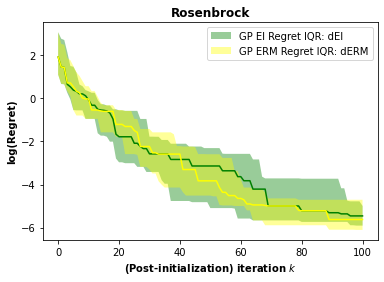

In [182]:
### Visualize!

title = obj_func

plt.figure()

plt.plot(median_loser, color = 'Green')
plt.plot(median_winner, color = 'Yellow')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_loser, upper_loser, facecolor = 'Green', alpha=0.4, label='GP EI Regret IQR: dEI')
plt.fill_between(xstar, lower_winner, upper_winner, facecolor = 'Yellow', alpha=0.4, label='GP ERM Regret IQR: dERM')

plt.title(title, weight = 'bold', family = 'Arial')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold', family = 'Arial') 
plt.ylabel('log(Regret)', weight = 'bold', family = 'Arial') 
plt.legend(loc=1) # add plot legend

plt.show()

In [183]:
time_lose, time_win

(3455.143899679184, 3516.657824754715)